In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from dnn_helper_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import itertools

# LOAD DATA

In [5]:
df = pd.read_csv('XRP_Data.csv').drop(['Date', 'binned price'], axis = 1)
df[['XRP_Change','XRP_Price']] = df[['XRP_Change','XRP_Price']].shift(1)
df.at[0,['XRP_Change','XRP_Price']] = [9.57, 0.1786]
print(df.shape)
df.head()

(253, 29)


,Positive Sentiment Averaged,Negative Sentiment Averaged,Overall Sentiment Averaged,Positive Sentiment Summed,Negative Sentiment Summed,Overall Sentiment Summed,Positive Sentiment RMS,Negative Sentiment RMS,Overall Sentiment RMS,XRP_Change,...,BTC_Price,BTC_Vol,ETH_Change,ETH_High,ETH_Low,ETH_Open,ETH_Price,ETH_Vol,ten day percent change,thirty day percent change
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.57,...,2731.2,42.31,12.53,232.59,200.80,200.81,225.97,352.31,0.000000,0.000000
1,0.176871,-0.072562,0.104308,0.176871,-0.072562,0.104308,0.176871,-0.072562,0.104308,-4.59,...,2702.0,23.76,-3.53,229.70,215.00,225.97,218.00,159.47,0.024648,0.024648
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.46,...,2790.3,16.86,3.11,228.20,217.07,218.00,224.79,96.19,0.018779,0.018779
3,0.163616,-0.102975,0.060641,0.163616,-0.102975,0.060641,0.163616,-0.102975,0.060641,-0.57,...,2860.0,18.99,-1.81,228.30,218.66,224.79,220.73,83.46,0.079812,0.079812
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.99,...,3256.4,50.56,15.01,259.90,219.23,220.73,253.87,234.87,0.058099,0.058099


 # MODEL TRAINING

For creating predicitve models, we will utilize deep neural networks. The functions to perform forwrard prop and backward prop are contained in the script file dnn_helper_functions. These functions are modified functions from my code utilized in my Deep Learning course on Coursera with Andrew Ng. You can see those notebooks [HERE](https://github.com/Mooseburger1/Deep-Learning) on my github for in depth details on how these functions work

In [5]:
def dnn_model(X, Y, layers_dims, learning_rate = 0.0075, lambd = 0.1, num_iterations = 3000, print_cost = True):
    '''
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguements:
    X -- data, numpy array of shape (number of examples, number of features)
    Y -- true "label" vector of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size of length (number of layers + 1)
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    '''
    
    np.random.seed(1)
    costs = []
    
    #initialize parameters
    parameters = initialize_parameters_deep(layers_dims)
    
    score = 0
    c = 100
    #Loop (gradient descent)
    for i in range(0, num_iterations):
        
        #Forward Propagation: [LINEAR->RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters, layers_dims)
        
        '''#Compute Accuracy Score
        s = accuracy(AL,Y)
        if s > score:
            score = s
            accurate_iter = i'''
        #Compute Cost
        cost = compute_cost(AL,Y,lambd,caches)
        if cost < c:
            iteration = i
            c = cost
            p = parameters
            
        #Backward Propagation
        grads = L_model_backward(AL, Y, lambd, caches)
        
        #Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        #Print cost every 100 training examples
        if print_cost and i % 200 == 0:
            print('Cost after iteration %i: %f' %(i, cost))
        #if print_cost and i % 10 == 0:
        costs.append(cost)
    fig = plt.figure(figsize = (15,8))        
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('iterations')
    plt.title('Model: '+ str(layers_dims)+' Learning rate: ' + str(learning_rate)+' Lambda: ' + str(lambd))
    #plt.text(len(costs)/2, max(costs)/2, 'Lowest cost: {:.2f} at iteration {}\n Highest Accuracy {:.2f} at iteration {}'.format(c, iteration,score,accurate_iter), fontsize = 20)
    plt.show()
    
    
    return parameters

# Make X (INDEPENDENT) & y (DEPENDENT) VARIABLES

For the first strategy on training our NN, we want to categorize our y values (XRP Price) in seperate bin ranges. That is, we don't want it to predict an exact price, but a **_Price Range_**. The price data spanned \$0.15 cents on the low end to \$2.77 on the high end. If we wanted to break this into 3 seperate ranges, for simplicity, we would label those ranges 0-2. For clarity: 
> [\$0.15 - \$1.025) = bin 0

> [\$1.025 - \$1.8975) = bin 1

> [\$1.8975 - \$2.77] = bin 2

Therefore, a XRP Price of \$1.09 would be classifed in bin 1 since it exists in between the range of \$1.025 and \$1.8975. Our NN can only predict between 0 and 1 however (utilizing RELU activation for the L-1 layers and Sigomoid activation for layer L). Because of this, we need to create a "One Hot" dependent variable list. All this means, utilizing our 3 bin range example, is that each XRP Price will be represented as an array of length "# of bins". All values of this array will be 0 except for the value at position = "bin #". For example:
> \$1.025 = **bin 1** out of 0-2 bins

> **bin 1** out of 0-2 bins = [0, 1, 0]

> $1.025 = [0, 1, 0]

For concreteness:
> \$0.23 = **bin 0** out of 0-2 bins

> **bin 0** out of 0-2 bins = [1, 0, 0]

> \$0.23 = [1, 0, 0]

Now 3 bin ranges might be a little too broad for price predictions (a price prediction between \$0.15 and \$1.025 isn't very accurate nor is it good investing advice). Let's create a function that will allow us to create however many bin ranges we desire.

In [6]:
def make_xy(df, cuts = 50, one_hots = True, future_price = 1):
    #set the dependent variable as XRP Price and shift it up by "future_price" days so as to represent predicting the future price in "future_price" days
    y = df.XRP_Price.shift(-future_price)[:-future_price]
    #set the independent variables as everything else
    X = df.iloc[:-future_price,:]
    
    #instantiate a scaler
    xscaler = MinMaxScaler()
    xscaler.fit(X)
    

    #function to create "one hot" arrays for each dependent variable (XRP Price)
    def one_hot(y, cuts = 50):
        data, bins = pd.cut(y, retbins = True, bins = cuts, labels = range(cuts))
        y = np.zeros((len(y),cuts))

        for pos in range(len(y)):
            y[pos, data[pos]] = 1
        return y, data, bins
    
    
    #scale independent variables
    X = xscaler.transform(X)
    
    
    if one_hots:
        y, data, bins = one_hot(y, cuts = cuts)
        return X, y, data, bins
    
    else:
        yscaler = MinMaxScaler()
        y = y.values.reshape(-1,1)
        yscaler.fit(y)
        y = yscaler.transform(y)
        return X, y, xscaler, yscaler

In [7]:
X, Y, data, bins = make_xy(df, one_hots = True)

We have made 50 different bin ranges with this initial pass. Let's see what those look like

In [8]:
bins_list = [(bins[i],bins[i+1]) for i in range(len(bins)-1)]
    
for pos, i in enumerate(bins_list):
    print(pos,i)

0 (0.1498825, 0.20485)
1 (0.20485, 0.2572)
2 (0.2572, 0.30955)
3 (0.30955, 0.3619)
4 (0.3619, 0.41425)
5 (0.41425, 0.4666)
6 (0.4666, 0.51895)
7 (0.51895, 0.5713)
8 (0.5713, 0.62365)
9 (0.62365, 0.6759999999999999)
10 (0.6759999999999999, 0.7283499999999999)
11 (0.7283499999999999, 0.7807)
12 (0.7807, 0.83305)
13 (0.83305, 0.8854)
14 (0.8854, 0.93775)
15 (0.93775, 0.9901)
16 (0.9901, 1.04245)
17 (1.04245, 1.0948)
18 (1.0948, 1.1471500000000001)
19 (1.1471500000000001, 1.1995)
20 (1.1995, 1.2518500000000001)
21 (1.2518500000000001, 1.3042)
22 (1.3042, 1.3565500000000001)
23 (1.3565500000000001, 1.4089)
24 (1.4089, 1.4612500000000002)
25 (1.4612500000000002, 1.5136)
26 (1.5136, 1.5659500000000002)
27 (1.5659500000000002, 1.6183)
28 (1.6183, 1.6706500000000002)
29 (1.6706500000000002, 1.723)
30 (1.723, 1.7753500000000002)
31 (1.7753500000000002, 1.8277)
32 (1.8277, 1.88005)
33 (1.88005, 1.9324000000000001)
34 (1.9324000000000001, 1.98475)
35 (1.98475, 2.0371)
36 (2.0371, 2.08945)
37 (2.08

with 50 cuts, each price(bin) range appears to be about \$0.05 cents in length with bin 0 being [0.1498 - 0.20485), bin 1 being [0.20485 - 0.2572), etc. etc. Let's randomly choose a Y value and ensure it has been One-Hot encoded properly

In [9]:
print('Dependent Variable Y at Position 151: ${}\n'.format(df.XRP_Price.shift(-1)[151]))
print('One-Hot Vector Representation for Dependent Variable Y at Position 151:\n',Y[151],'\n')
print('Vector Position of Value 1 in One-Hot Vector for Dependent Variable Y at Position 151: {}'.format(Y[151].argmax()))

Dependent Variable Y at Position 151: $1.97

One-Hot Vector Representation for Dependent Variable Y at Position 151:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] 

Vector Position of Value 1 in One-Hot Vector for Dependent Variable Y at Position 151: 34


Perfect. So we can see that a XRP Price of \$1.97 would fall in the price range of \$1.932 - \$1.984 which corresponds to bin 34. Inspecting the One-Hot vector implementation for this price point, we can in fact see that at position 34, the value 1 exists. Next, let's just throw our variables in a model and see initial performance. The first thing we will need to do is create our Train and Test sets. One of  the initial parameters we need to decide on however, is how big our Training and Test sets should be. We can try a few different percentages and analyze the results. Let's start with 60% Training size initially for this first pass. After initial analysis, we will break our data into Training Sets of 50%, 60%, 75% & 90%

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size = 0.6, test_size = 0.4, random_state = 42)

In [11]:
print('Training Input Size: {}\nTraining Ouput Size: {}\nTesting Input Size: {}\nTesting Ouput Size: {}'.format(X_train.shape, y_train.shape,X_test.shape,y_test.shape))

Training Input Size: (151, 29)
Training Ouput Size: (151, 50)
Testing Input Size: (101, 29)
Testing Ouput Size: (101, 50)


With a 60% Training Set size, we can see that our input independent variables **X** (X_train) has 151 samples, each with 29 features. Our output dependent variable **y** (y_train) has also 151 samples corresponding to each 151 input samples and 50 output responses. This corresponds to the 50 "one-hot" bin encoding we performed above. We would expect to see 49 of the 50 output responses to be 0 and one of the 50 to be equal to 1. As a result of this, our output layer L needs to be of size 50. Also note that our model expects the features to be the rows, and each observation to be a column. Because of this, when feeding X into our model, we will have to transpose it so it is of shape (29,151). We also need to choose our Neural Network's architectural structure. Our function has an arguement "layers_dims". This arguement accepts a list of any length, but at least 2. The first number must always be the number of input features. The last number must always be the size of our dependent variable y. If y for every observation is a single number, then it would be 1. In our current case, y for every observation is size 50 since it is one hot encoded for 50 different price ranges. Therefore our output layer size is 50. Everything else in between is fair game. For starters, let's start off with a model that has our input layer of size 29 for 29 features, 2 hidden layers of size 50 and 40, and our output layer of 50

Cost after iteration 0: 35.672177
Cost after iteration 200: 3.606656
Cost after iteration 400: 3.441716
Cost after iteration 600: 3.306604
Cost after iteration 800: 3.194794
Cost after iteration 1000: 3.108041
Cost after iteration 1200: 3.037894
Cost after iteration 1400: 2.974891
Cost after iteration 1600: 2.916846
Cost after iteration 1800: 2.864372
Cost after iteration 2000: 2.817557
Cost after iteration 2200: 2.774518
Cost after iteration 2400: 2.732479
Cost after iteration 2600: 2.691411
Cost after iteration 2800: 2.651162
Cost after iteration 3000: 2.610719
Cost after iteration 3200: 2.569057
Cost after iteration 3400: 2.525300
Cost after iteration 3600: 2.481130
Cost after iteration 3800: 2.437073
Cost after iteration 4000: 2.393349
Cost after iteration 4200: 2.350201
Cost after iteration 4400: 2.307792
Cost after iteration 4600: 2.266537
Cost after iteration 4800: 2.226417
Cost after iteration 5000: 2.187306
Cost after iteration 5200: 2.149066
Cost after iteration 5400: 2.11145

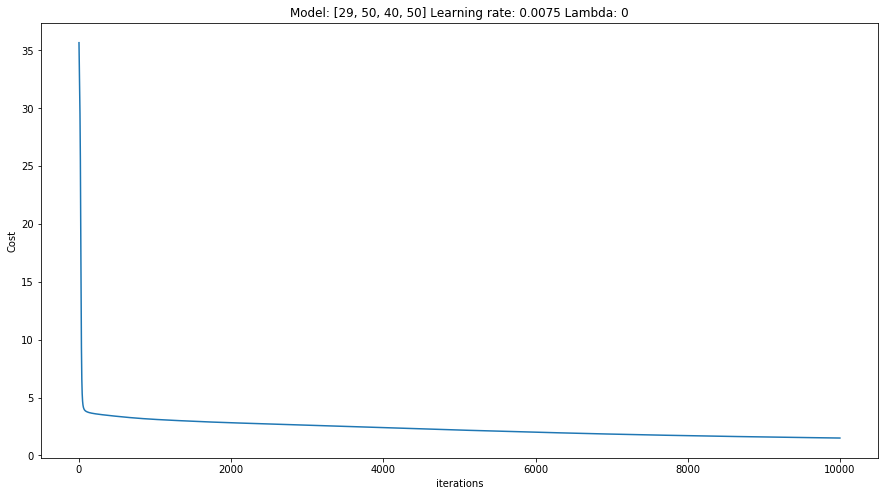

This Model's Train Set Accuracy is: 0.7019867549668874
This Model's Test Set Accuracy is: 0.504950495049505


In [12]:
#Train the model and return the best parameters
parameters = dnn_model(X_train.T, y_train.T, layers_dims=[29,50,40,50], learning_rate=0.0075, lambd = 0, num_iterations=10000, print_cost=True)

#Test the model on the Training Set
AL, _ = L_model_forward(X_train.T, parameters, [29,50,40,50])

#Test the model on the Test Set
AL_test, _test = L_model_forward(X_test.T, parameters, [29,50,40,50])

#Calculate Accuracy of the Training Set
train_score, train_df = accuracy(AL,y_train.T)

#Calculate Accuracy of the Test Set
test_score, test_df = accuracy(AL_test, y_test.T)

print('This Model\'s Train Set Accuracy is: {}'.format(train_score))
print('This Model\'s Test Set Accuracy is: {}'.format(test_score))

Not too bad for the first dry run for our NN. As we can see, the model achieved 70% accuracy on the Training Set and 50% accuracy on the test set. However with 30% and 50% error respectively, our model is suffering from both **High Bias** and **High Variance**. It is doing poorly on the training set, and therefore has high bias, and its performance on the test set is even worse, so it also has high variance. Because of this, regularization won't help very much since there is already high bias on the training set, and adding more training data won't help either (not that we really have more anyways). Our options are now as follows:
* Increase the model size: This technizque reduces bias, since it should allow you to fit the training set better
* Reduce or eliminate regularization
* Modify model architecture

Another thing to note is the cost value. After iteration 9800, we can see it is only at 1.514454. Scanning back up, we can see that it was steadily decreasing without jumping up and down. Because of this we can either increase the number of iterations to train our model, or simply increase the learning rate. Increasing iterations can be computationally expenseive. Conversely, increasing the learning rate to too high of a value might prevent the cost from ever converging to the minimum. Nonetheless, it is a value we can tweak as well

### Quick Note on Model Ouput and Score

As stated earlier, when testing this model, the output is a matrix of 151 observations and 50 responses from each observation. For Example, the response from the first observation looks like this:

In [13]:
print(AL.T[0].shape)
AL.T[0]

(50,)


array([8.63568069e-01, 1.80711312e-01, 3.71388688e-02, 1.48527234e-09,
       1.03445105e-08, 1.06046738e-04, 1.06231103e-02, 4.29304106e-03,
       8.17680998e-04, 4.85272436e-04, 2.38361004e-05, 1.88813712e-05,
       2.77522916e-04, 2.99742784e-05, 6.81292954e-07, 6.05408580e-06,
       1.09802496e-06, 6.67675555e-05, 8.67171757e-08, 5.76401684e-10,
       1.43399269e-07, 2.89937062e-09, 2.27834098e-07, 2.21991318e-07,
       3.85505070e-07, 2.42958000e-07, 3.36383400e-06, 1.28860768e-08,
       3.48729608e-11, 1.82127476e-09, 1.01679791e-07, 1.17924916e-07,
       1.86619343e-09, 2.95221827e-08, 5.31236226e-08, 3.75149232e-08,
       5.67036876e-12, 2.42159864e-08, 2.10936752e-07, 2.64129434e-07,
       1.90150572e-07, 7.71416197e-10, 1.61430491e-09, 2.26024142e-08,
       4.53736437e-10, 2.93969483e-09, 1.38267181e-07, 1.33350542e-11,
       1.60912867e-08, 6.17981909e-07])

From this array, the position with the largest value is replaced with the value 1, and all other values are set to 0. In this particular output response, we can see position 0 is the largest value at 0.8635. So this output response would be reencoded as:

In [14]:
print('\n Output Response for the First Observation is Encoded as: \n')
output = np.zeros(len(AL.T[0]))
output[AL.T[0].argmax()] = 1
output


 Output Response for the First Observation is Encoded as: 



array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

All 151 ouput observations are encoded this way. Once the position of the maximum value is found, a table is created containing all 151 observations and the location of their maximum value positions. A second column is created containing the location of the bin number of the true values. These two values are subtracted from each other, and the total number of 0's are added. 0, because if the predicted value is correct, it will equal the true value, resulting in 0. The total number of 0's are calculated and then divided by the total number of observation, resulting in the accuracy score. This table looks like this:

In [15]:
train_df.head(20)

,pred,true,score
0,0,0,0
1,0,0,0
2,1,1,0
3,0,0,0
4,6,6,0
5,14,18,4
6,1,1,0
7,0,1,1
8,9,8,1
9,49,49,0


One benefit of creating this table is not only  can we calculate the accuracy, but we can also see how wrong the predictions were when they were wrong. We can filter the table for all values where score does not equal 0, sort it, and then plot curves

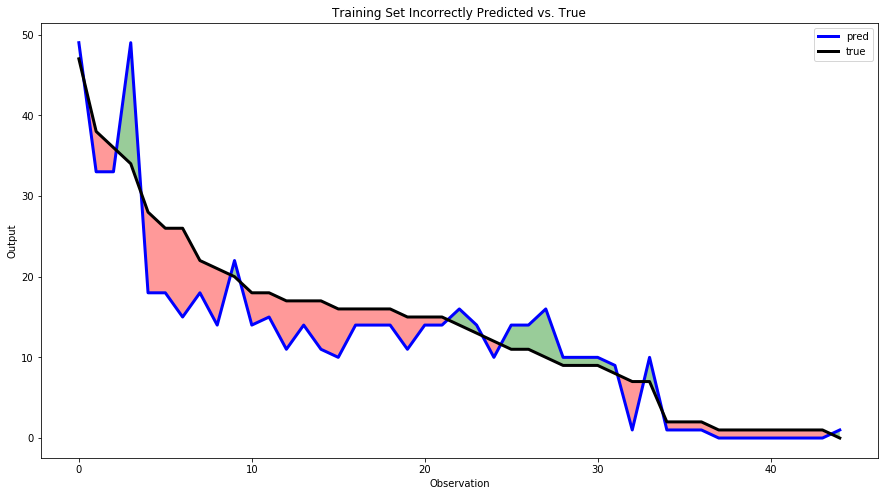

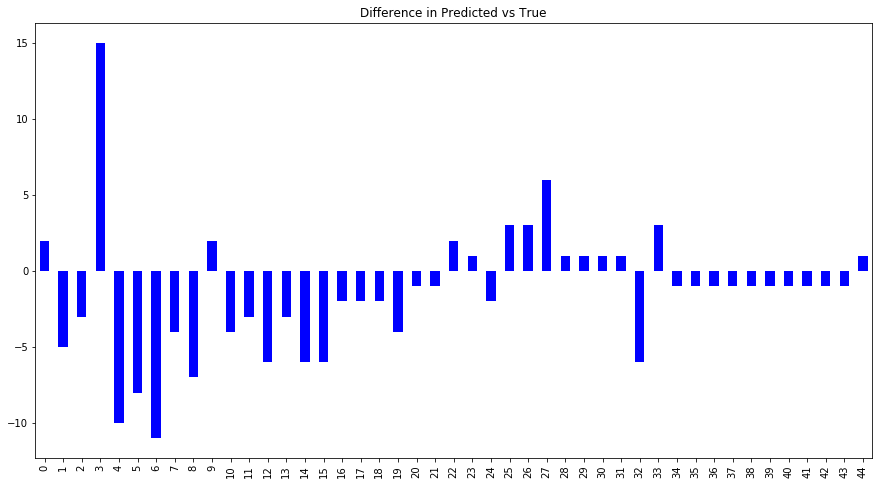

In [16]:
an = train_df[train_df.score != 0][['pred','true']].sort_values(by = 'true',ascending = False).reset_index().drop('index',axis = 1)
ax = an[['pred','true']].plot(figsize = (15,8), lw = 3, color = ['b','k'])
ax.fill_between(an.index, an.pred, an.true, where = (an.pred >= an.true), facecolor = 'g', alpha = 0.4, interpolate = True)
ax.fill_between(an.index, an.pred, an.true, where = (an.pred <= an.true), facecolor = 'r', alpha = 0.4, interpolate = True)
ax.set_xlabel('Observation')
ax.set_ylabel('Output')
ax.set_title('Training Set Incorrectly Predicted vs. True')
plt.show()


an['diff'] = an.pred - an.true
ax1 = an['diff'].plot(kind = 'bar',figsize = (15,8), color = 'b')
ax1.set_title('Difference in Predicted vs True')
plt.show()

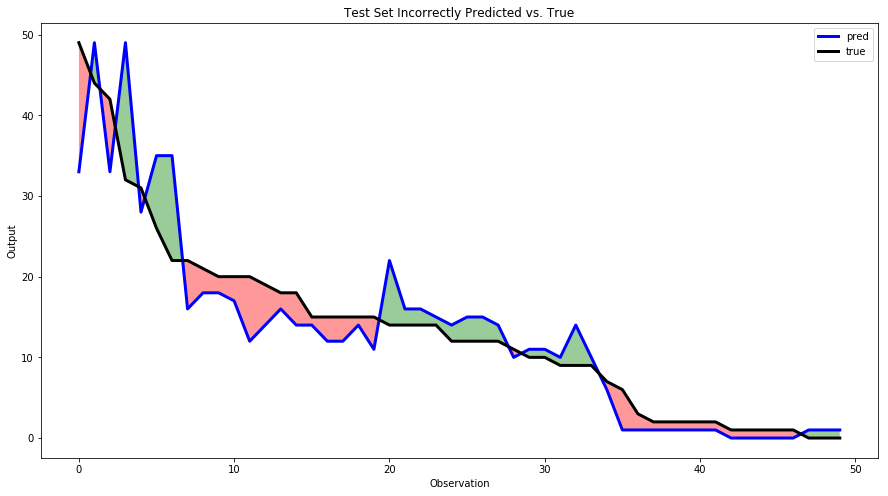

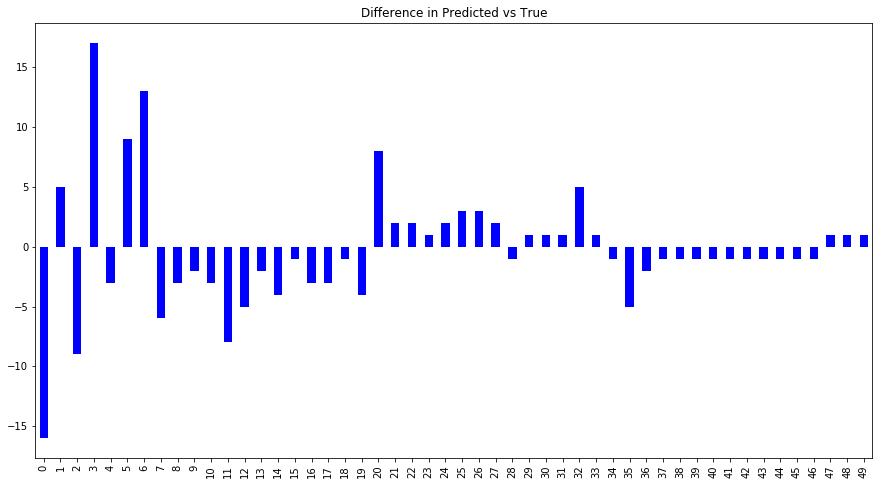

In [17]:
an = test_df[test_df.score != 0][['pred','true']].sort_values(by = 'true',ascending = False).reset_index().drop('index',axis = 1)
ax = an[['pred','true']].plot(figsize = (15,8), lw = 3, color = ['b','k'])
ax.fill_between(an.index, an.pred, an.true, where = (an.pred >= an.true), facecolor = 'g', alpha = 0.4, interpolate = True)
ax.fill_between(an.index, an.pred, an.true, where = (an.pred <= an.true), facecolor = 'r', alpha = 0.4, interpolate = True)
ax.set_xlabel('Observation')
ax.set_ylabel('Output')
ax.set_title('Test Set Incorrectly Predicted vs. True')
plt.show()


an['diff'] = an.pred - an.true
ax1 = an['diff'].plot(kind = 'bar',figsize = (15,8), color = 'b')
ax1.set_title('Difference in Predicted vs True')
plt.show()

From the graphs above we can see mostly that our model is under predicting the expected price range. Which this isn't a huge problem to have in the grand scheme of things. When investing it is always better to predict on the lower end than to over estimate. However when the model does over predict the expected price range, it is prediciting much higher than the actual range. this is seen on both the Training and Testing Data. The training data has a difference of as much as 15 price ranges. That would be the same as the model predicting \$0.88 - \$0.94 cents but the real value being \$0.15 to \$0.20 cents. That is dangerous. Let's start tweaking hyperparameters and model architecture to improve it. Let's also add some model statistics to help us evaluate performance

In [18]:
def run_model(X,y, nn_dims, learning_rate, lambd, iterations, train_set_size = [0.5, 0.6, 0.75, 0.9]):
    train_scores = []
    test_scores = []
    for size in train_set_size:
        print('\n-------------------------- TRAINING MODEL WITH {:.0f} ({}%) TRAINING SAMPLES --------------------------'.format(len(X)*size, size*100))
        X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = size, test_size = 1-size, random_state = 42)

        
        parameters = dnn_model(X_train.T, y_train.T, layers_dims = nn_dims, learning_rate=learning_rate, lambd = lambd, num_iterations=iterations, print_cost=False)
        
        #Test the model on the Training Set
        AL, _ = L_model_forward(X_train.T, parameters, nn_dims)

        #Test the model on the Test Set
        AL_test, _test = L_model_forward(X_test.T, parameters, nn_dims)

        #Calculate Accuracy of the Training Set
        print('\n\n\n******************************* TRAINING SET PERFORMANCE')
        train_score, train_df = accuracy(AL,y_train.T, True)
        print('This Model\'s Training Set Accuracy is: {}'.format(train_score))
        
        
        #Calculate Accuracy of the Test Set
        print('\n\n\n******************************* TEST SET PERFORMANCE')
        test_score, test_df = accuracy(AL_test, y_test.T, True)
        print('This Model\'s Test Set Accuracy is: {}\n\n\n'.format(test_score))
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print('\n\n\n\n************************************** NN MODEL {} PERFORMANCE **************************************'.format(nn_dims))
    fig = plt.figure(figsize = (15,8))
    plt.plot([len(X)*size for size in train_set_size], 1-np.array(train_scores), marker = '.', label = 'Training Set Error')
    plt.plot([len(X)*size for size in train_set_size], 1-np.array(test_scores), marker = '.', label = 'Test Set Error')
    plt.xlabel('Training Set Size (m)')
    plt.ylabel('Error')
    plt.title('Training Error')
    plt.legend()
    plt.show()

For the first tweak, we will both increase the learning rate and number of interations to drive our cost down. The overall architecture of the NN will remain the same, but we will now verify performance of the model at different training set sizes


-------------------------- TRAINING MODEL WITH 126 (50.0%) TRAINING SAMPLES --------------------------


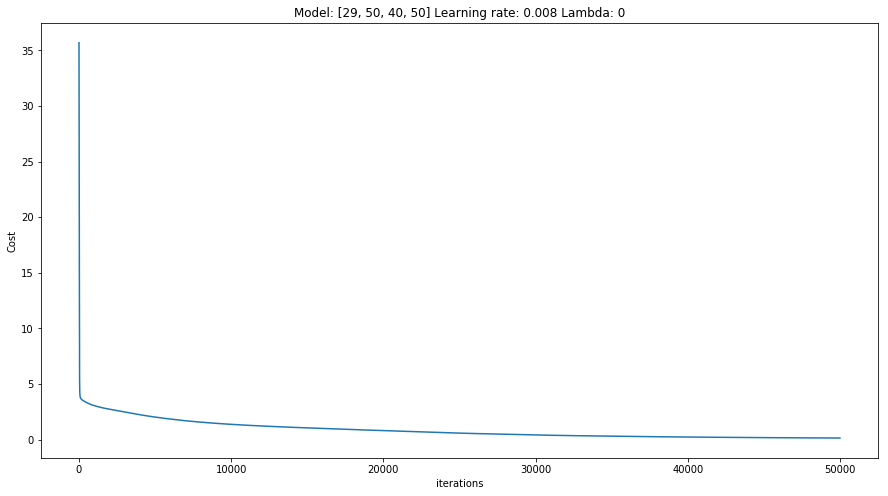




******************************* TRAINING SET PERFORMANCE


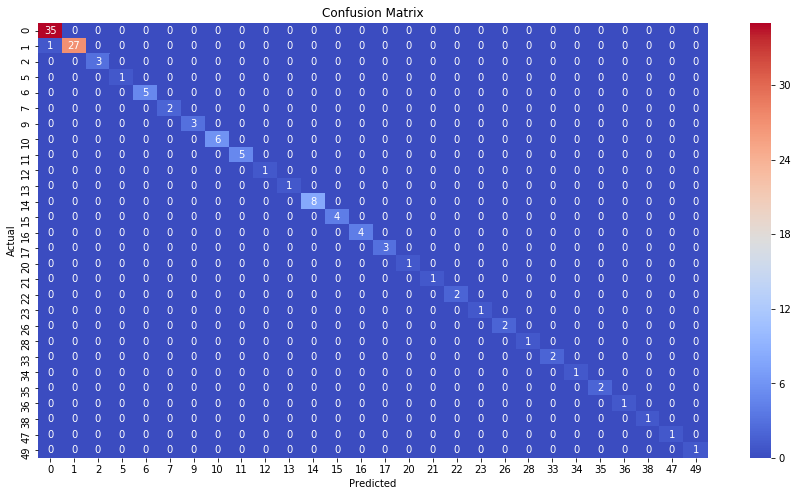

This Model's Training Set Accuracy is: 0.9920634920634921



******************************* TEST SET PERFORMANCE


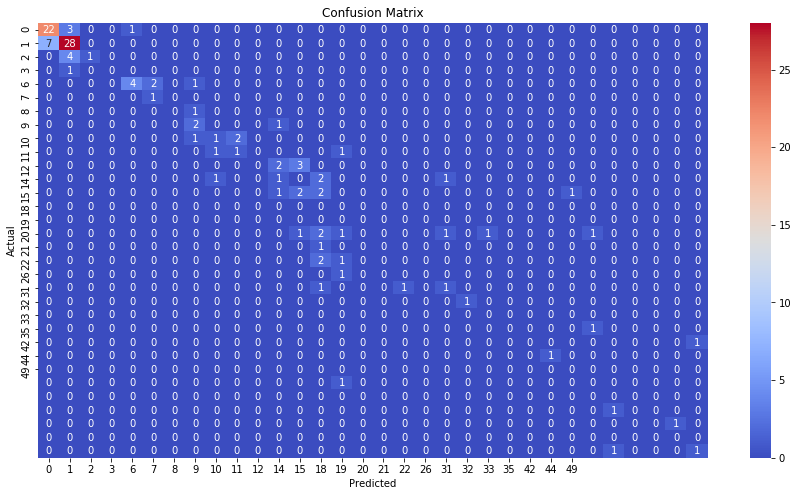

This Model's Test Set Accuracy is: 0.5317460317460317




-------------------------- TRAINING MODEL WITH 151 (60.0%) TRAINING SAMPLES --------------------------


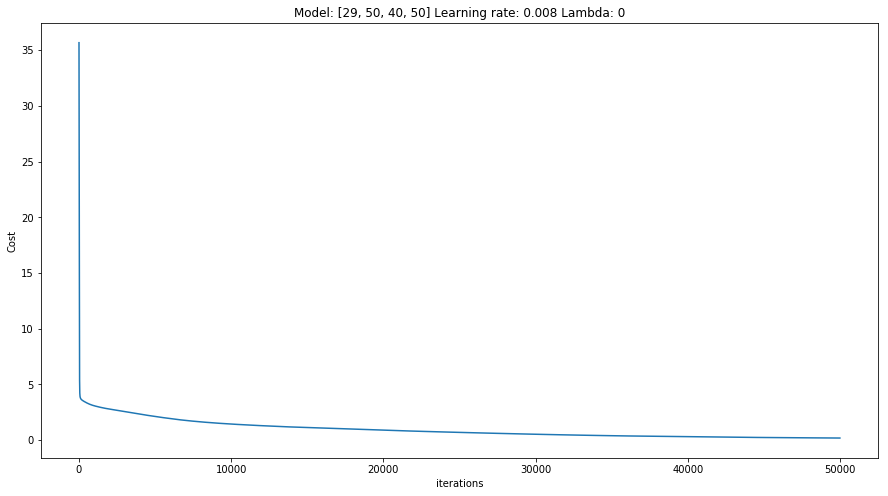




******************************* TRAINING SET PERFORMANCE


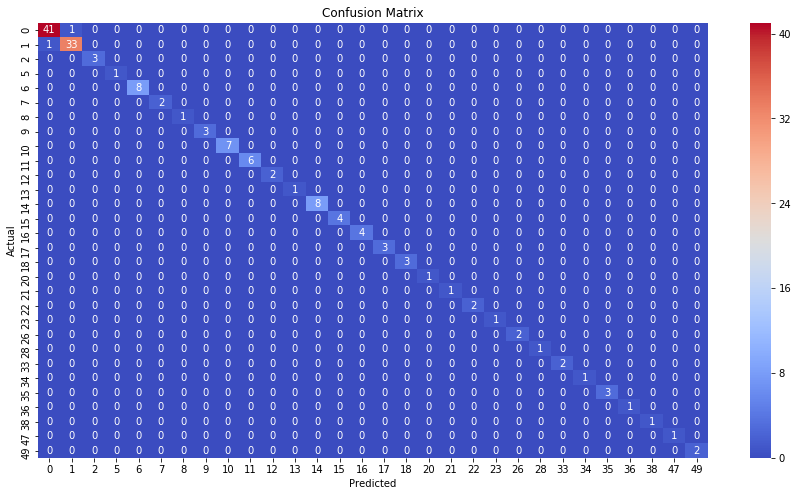

This Model's Training Set Accuracy is: 0.9867549668874173



******************************* TEST SET PERFORMANCE


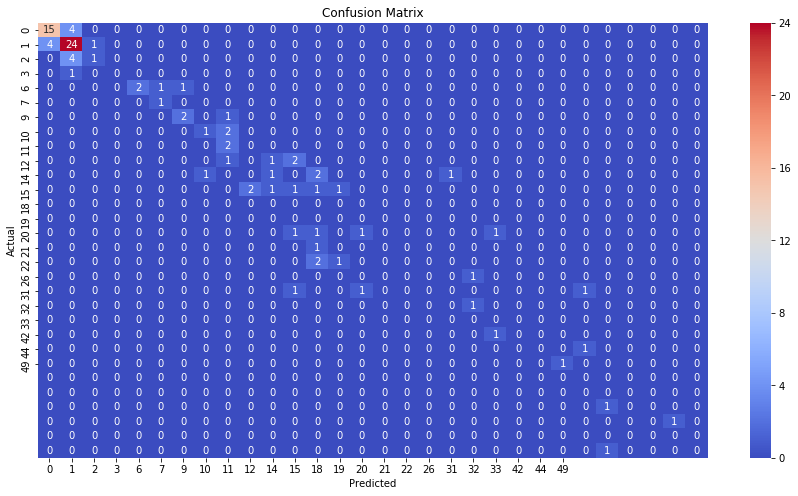

This Model's Test Set Accuracy is: 0.5247524752475248




-------------------------- TRAINING MODEL WITH 189 (75.0%) TRAINING SAMPLES --------------------------


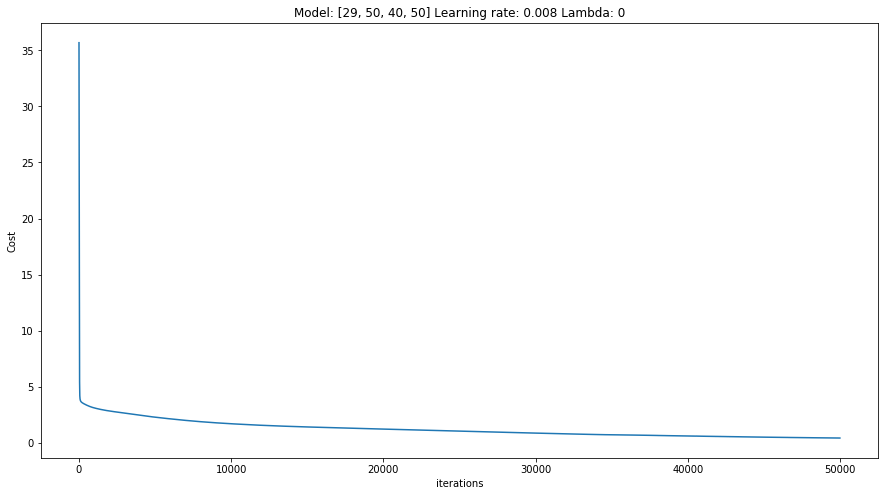




******************************* TRAINING SET PERFORMANCE


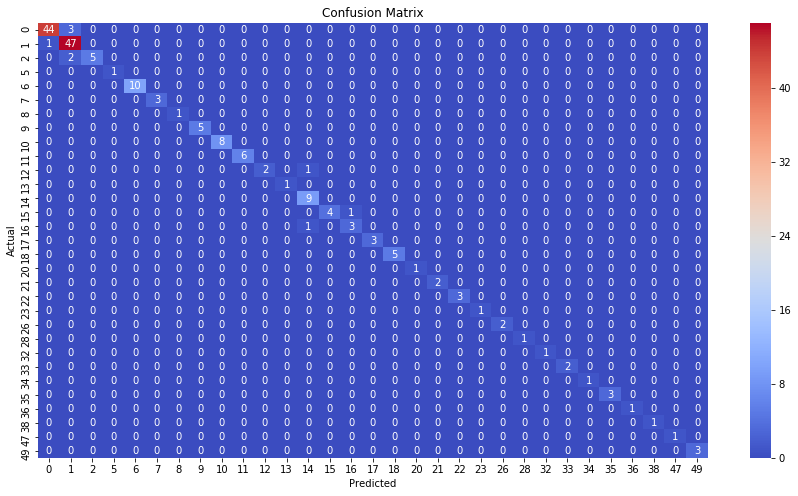

This Model's Training Set Accuracy is: 0.9523809523809523



******************************* TEST SET PERFORMANCE


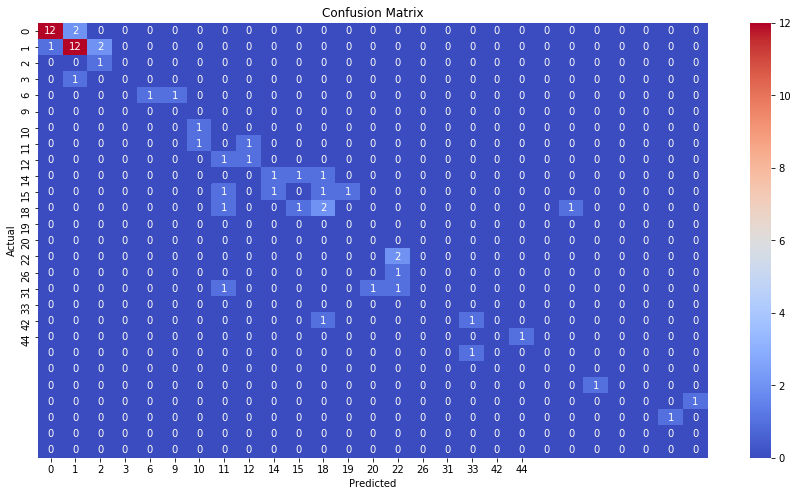

This Model's Test Set Accuracy is: 0.5555555555555556




-------------------------- TRAINING MODEL WITH 227 (90.0%) TRAINING SAMPLES --------------------------


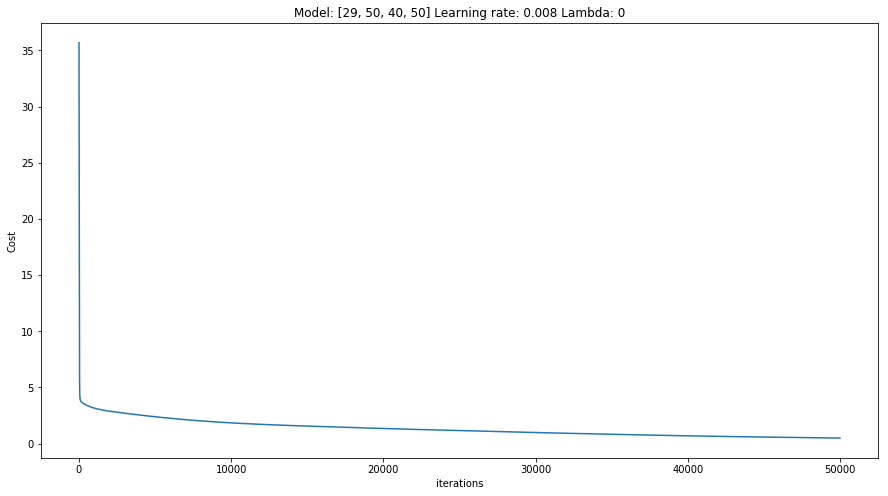




******************************* TRAINING SET PERFORMANCE


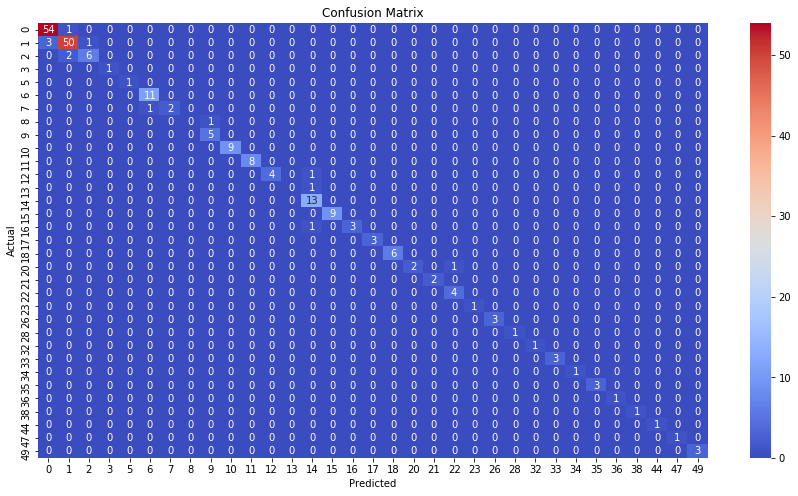

This Model's Training Set Accuracy is: 0.9424778761061947



******************************* TEST SET PERFORMANCE


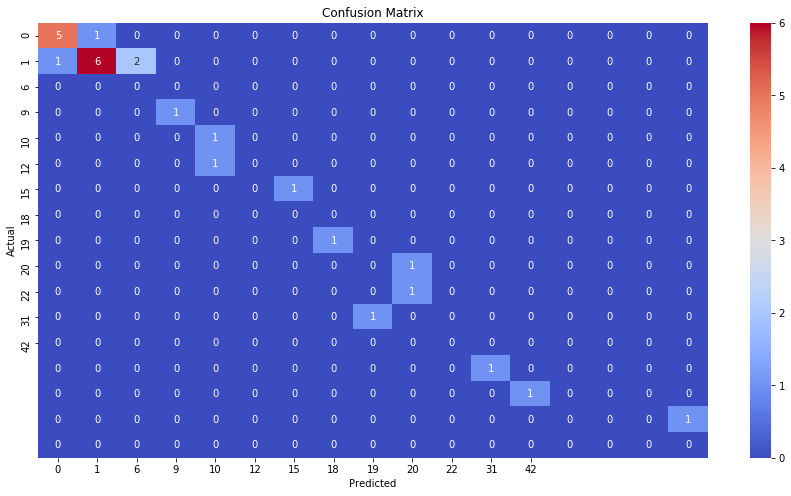

This Model's Test Set Accuracy is: 0.5769230769230769







************************************** NN MODEL [29, 50, 40, 50] PERFORMANCE **************************************


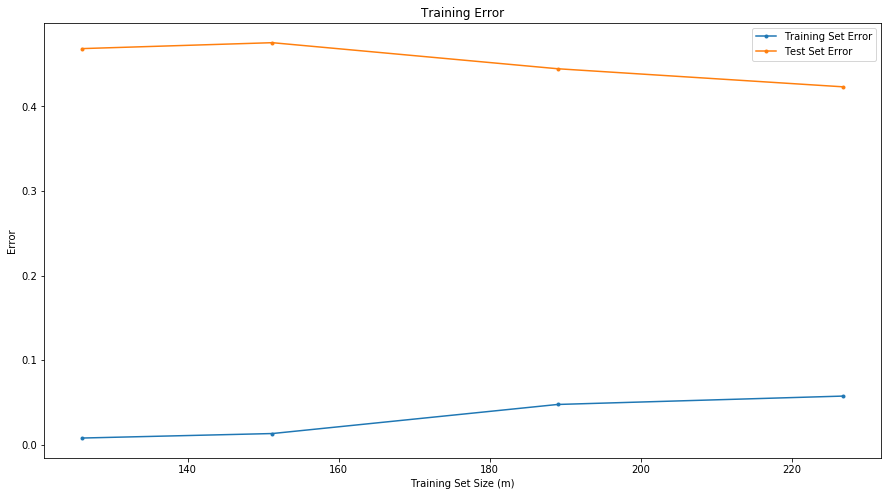

In [19]:
run_model(X, Y, nn_dims = [29,50,40,50], learning_rate = 0.008, lambd = 0, iterations = 50000)

There's a few takeaways from the models above. The first thing to notice is that the cost is reducing with each iteration and it's not making "quantum leaps" either up or down. It is a smooth continuous decreasing trend. This is the desired behavior. The next takeaway is the high accuracy on the training set but low accuracy on the test set. This is clear evidence of overfitting the training set. However, We are getting the expected overall results of the NN model architecture of 29:50:40:50 in that with increasing training set sizes, we get decreasing performance on the training set, yet increasing performance on the test set. The next thing to take away from the training pertains to the confusion matrices for each model. There are a total of 50 bins (0 - 49) but the training set doesn't contain at least one example from all 50 bins. In fact, it is unevenly skewed towards the lower price ranges, particulary bin 0. For each model, there is by far more samples of bin 0 than any other bin, as well as a lot of missing bins in the upper bin regions. This could also be a root cause to poor performance on the test set. The models aren't given a fairly even distribution of all the bin samples so it can't adapt well to new samples it hasn't seen before. Also notice that in the test set confusion matrices, the model is making predicitons on values that don't even exist within the test. This again appears to be an issue caused by unevenly represented bins within the training set. Before we fix the training set issue, let's see how our performance improves when implementing L2 Regularization to combat the overfitting problem. 

### Test Model With L2 Regularization


-------------------------- TRAINING MODEL WITH 126 (50.0%) TRAINING SAMPLES --------------------------


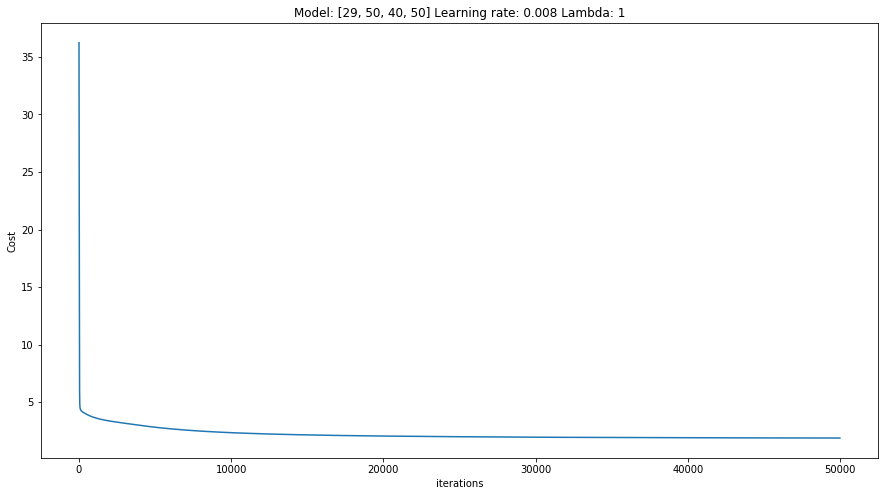




******************************* TRAINING SET PERFORMANCE


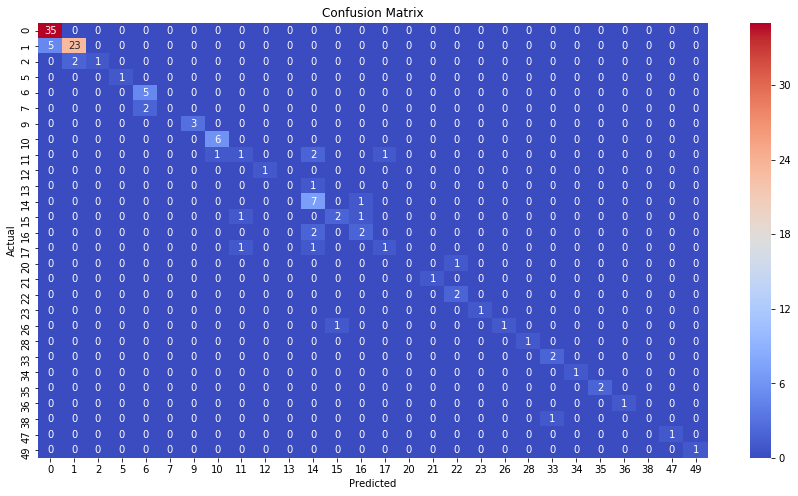

This Model's Training Set Accuracy is: 0.8095238095238095



******************************* TEST SET PERFORMANCE


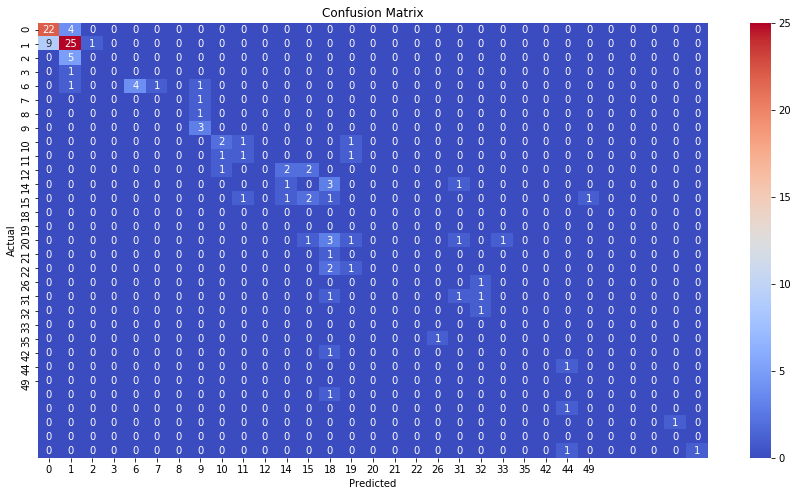

This Model's Test Set Accuracy is: 0.5079365079365079




-------------------------- TRAINING MODEL WITH 151 (60.0%) TRAINING SAMPLES --------------------------


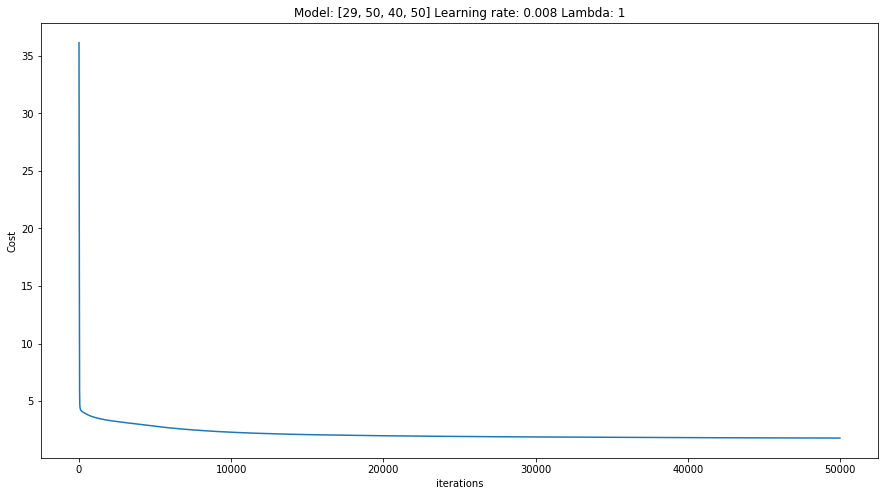




******************************* TRAINING SET PERFORMANCE


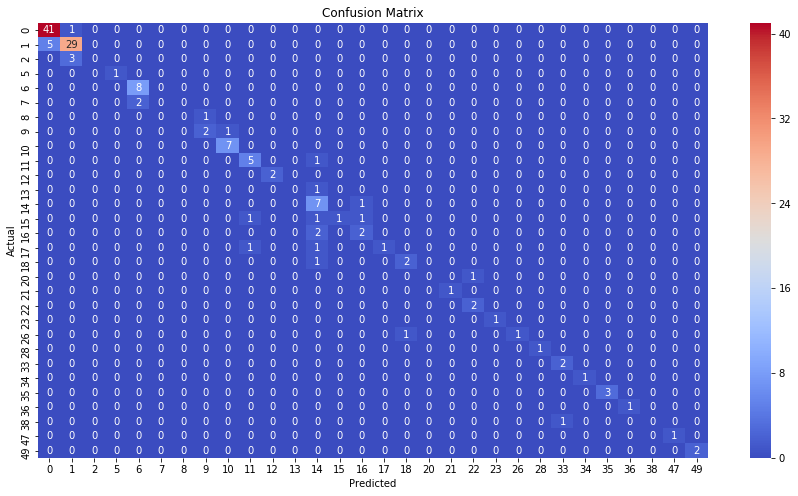

This Model's Training Set Accuracy is: 0.8211920529801324



******************************* TEST SET PERFORMANCE


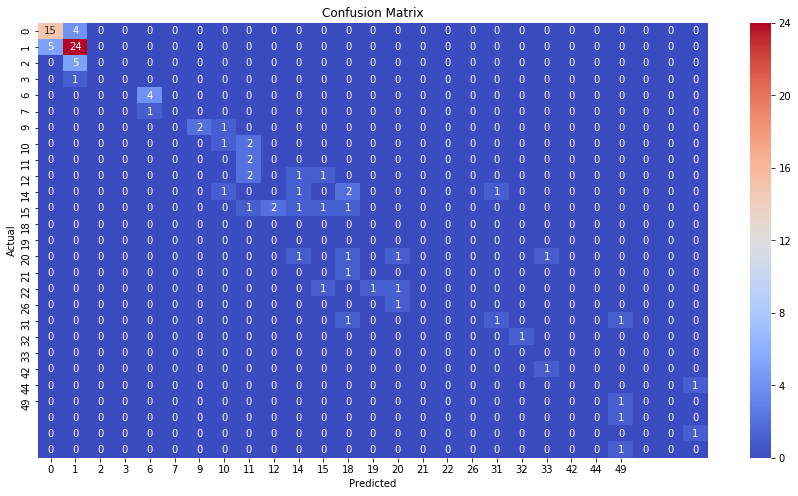

This Model's Test Set Accuracy is: 0.5346534653465347




-------------------------- TRAINING MODEL WITH 189 (75.0%) TRAINING SAMPLES --------------------------


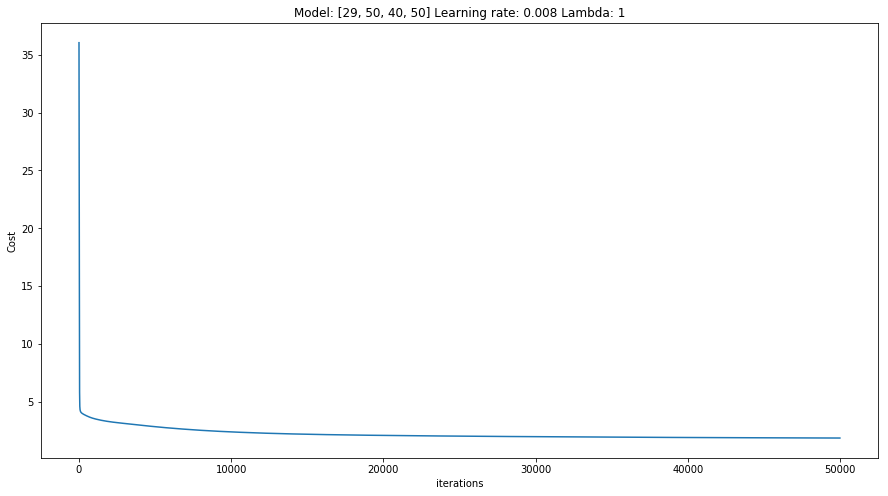




******************************* TRAINING SET PERFORMANCE


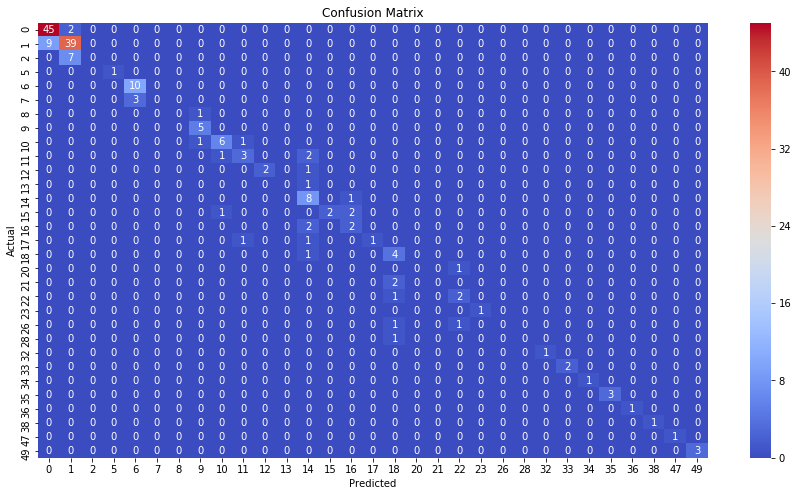

This Model's Training Set Accuracy is: 0.7619047619047619



******************************* TEST SET PERFORMANCE


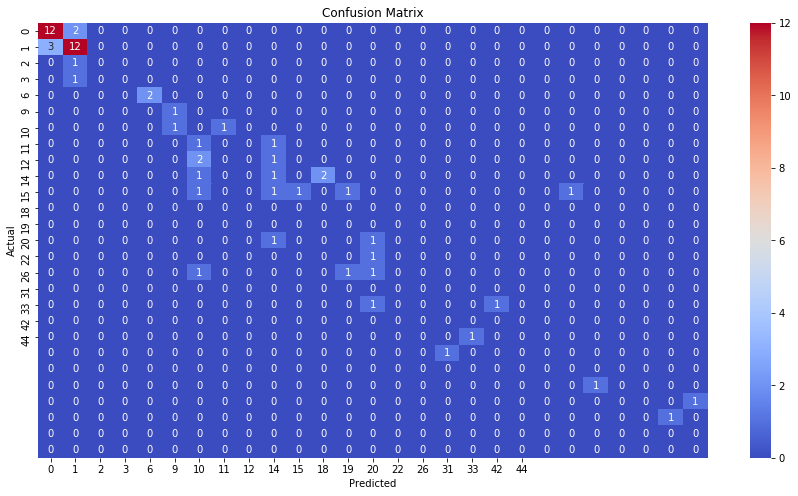

This Model's Test Set Accuracy is: 0.49206349206349204




-------------------------- TRAINING MODEL WITH 227 (90.0%) TRAINING SAMPLES --------------------------


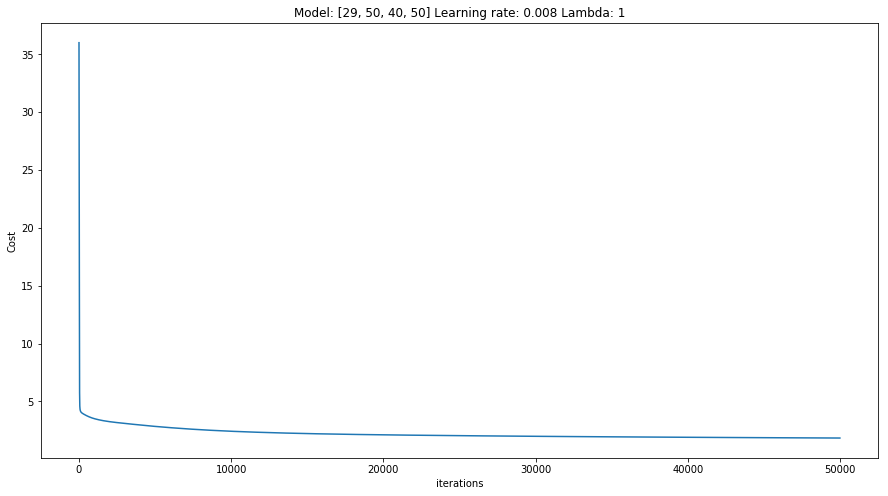




******************************* TRAINING SET PERFORMANCE


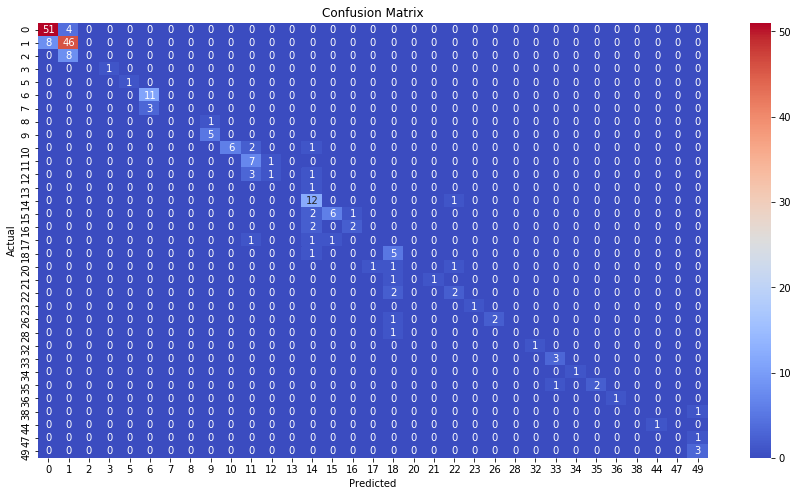

This Model's Training Set Accuracy is: 0.7610619469026548



******************************* TEST SET PERFORMANCE


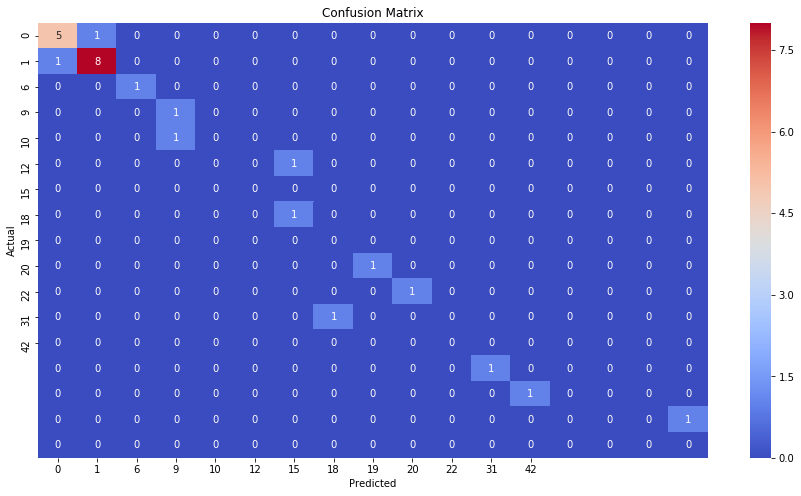

This Model's Test Set Accuracy is: 0.5769230769230769







************************************** NN MODEL [29, 50, 40, 50] PERFORMANCE **************************************


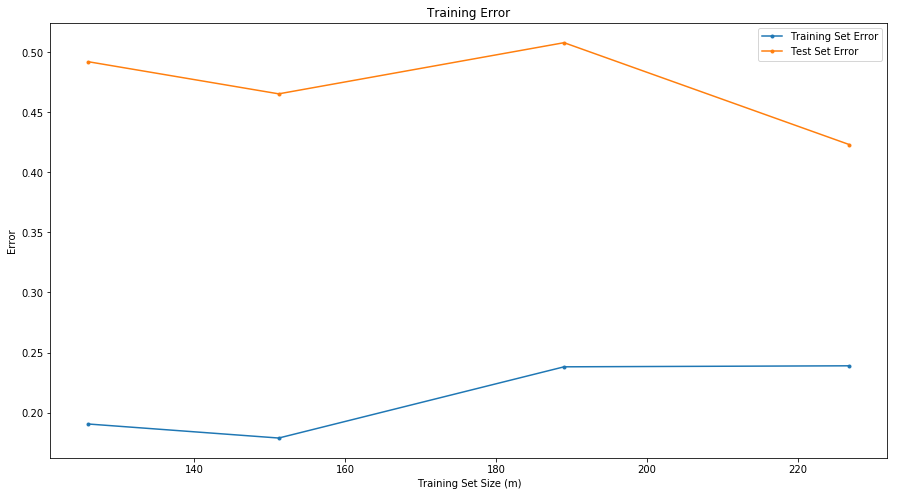

In [20]:
run_model(X, Y, nn_dims = [29,50,40,50], learning_rate = 0.008, lambd = 1, iterations = 50000)

Although only one new model is shown above, I tried several different values of lambda in which it prodcued the desired affect of lowering the training set accuracy (counteracting overfitting) but it had minimal affect on the Test Set accuracy. Again this is probably due in part to the skewed amount of samples for each bin. The following distribution shows just how uneven the samples are.

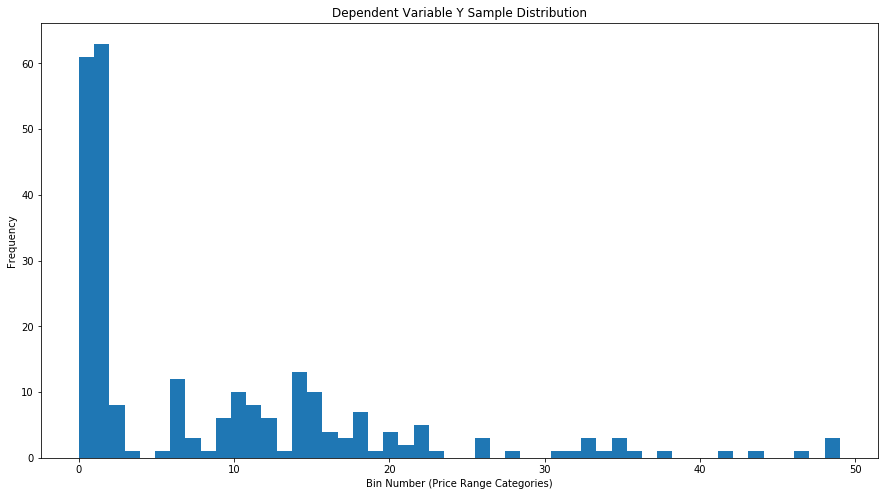

In [21]:
plt.figure(figsize = (15,8))
plt.hist(data, bins = 50)
plt.xlabel('Bin Number (Price Range Categories)')
plt.ylabel('Frequency')
plt.title('Dependent Variable ''Y'' Sample Distribution')
plt.show()

The above distribution on reinforces just how skewed the data is. Bins 0 and 1 are in order of magnitudes larger than all other bins (Price Ranges). There are several bins with only 1 sample as well as several bins with 0 samples to represent them. It's obvious that 50 seperate price ranges is too many, as there is not enough data in the higher price ranges to train the model with. Let's see how the distributions look with few price ranges. 

In [22]:
x30, y30, data30, bins30 = make_xy(df, cuts = 30, one_hots = True)

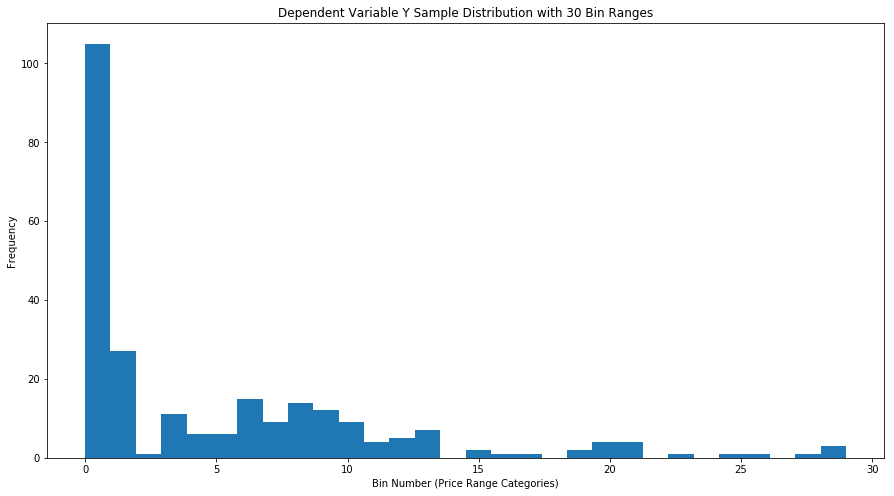

In [23]:
plt.figure(figsize = (15,8))
plt.hist(data30, bins = 30)
plt.xlabel('Bin Number (Price Range Categories)')
plt.ylabel('Frequency')
plt.title('Dependent Variable ''Y'' Sample Distribution with 30 Bin Ranges')
plt.show()

In [24]:
x20, y20, data20, bins20 = make_xy(df, cuts = 20, one_hots = True)

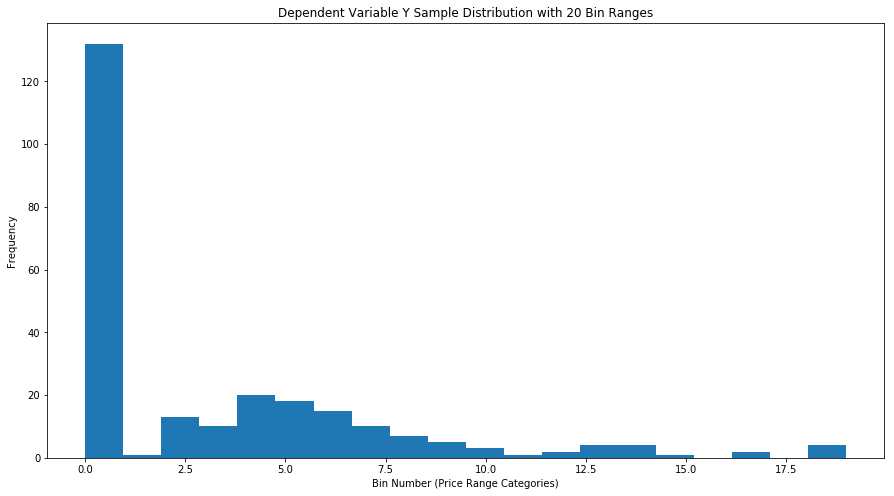

In [25]:
plt.figure(figsize = (15,8))
plt.hist(data20, bins = 20)
plt.xlabel('Bin Number (Price Range Categories)')
plt.ylabel('Frequency')
plt.title('Dependent Variable ''Y'' Sample Distribution with 20 Bin Ranges')
plt.show()

Reducing the amount of Price Ranges (bins) is creating more samples for each bin. However there are 2 drawbacks to doing this. 
1. The first bin will become larger when reducing price range bins This still doesn't alleviate the issue of the model being trained on primarily one sample type. It might not generalize very well to unseen samples.
2. The price ranges become larger, making the predictions very inaccurate. 

Remember that 50 price ranges (bins) correlated to price ranges of approximately 0.05 cents. Predicting a price with a maximum error of 0.05 cents is more than tolerable. Let's see how the prices look with only 20 price range bins

In [26]:
bins_list = [(bins20[i],bins20[i+1]) for i in range(len(bins20)-1)]
    
for pos, i in enumerate(bins_list):
    print(pos,i)

0 (0.1498825, 0.28337500000000004)
1 (0.28337500000000004, 0.41425)
2 (0.41425, 0.5451250000000001)
3 (0.5451250000000001, 0.676)
4 (0.676, 0.8068750000000001)
5 (0.8068750000000001, 0.9377500000000001)
6 (0.9377500000000001, 1.0686250000000002)
7 (1.0686250000000002, 1.1995000000000002)
8 (1.1995000000000002, 1.3303750000000003)
9 (1.3303750000000003, 1.4612500000000004)
10 (1.4612500000000004, 1.5921250000000002)
11 (1.5921250000000002, 1.7230000000000003)
12 (1.7230000000000003, 1.8538750000000004)
13 (1.8538750000000004, 1.9847500000000002)
14 (1.9847500000000002, 2.115625)
15 (2.115625, 2.2465)
16 (2.2465, 2.3773750000000002)
17 (2.3773750000000002, 2.5082500000000003)
18 (2.5082500000000003, 2.6391250000000004)
19 (2.6391250000000004, 2.77)


With 20 different price ranges, there's about 0.13 cents error in our prediction. That might not sound like much, but keep in mind XRP predominantly traded around 0.15 to 0.25 cents. With a range of 0.13 cents, if the model is over-predicting, that could be a potential loss up to 50% on investment. This risk is alleviated if and only if we can create a model that is very accurate so the potential for it to over predict is attenuated greatly. Let's see how we can do with 20 price ranges (bins)

### Train Model With Only 20 Price Ranges


-------------------------- TRAINING MODEL WITH 126 (50.0%) TRAINING SAMPLES --------------------------


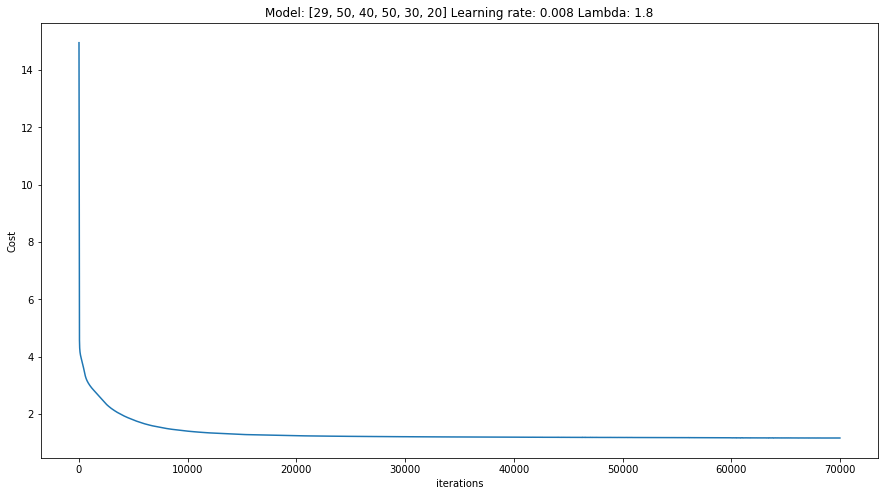




******************************* TRAINING SET PERFORMANCE


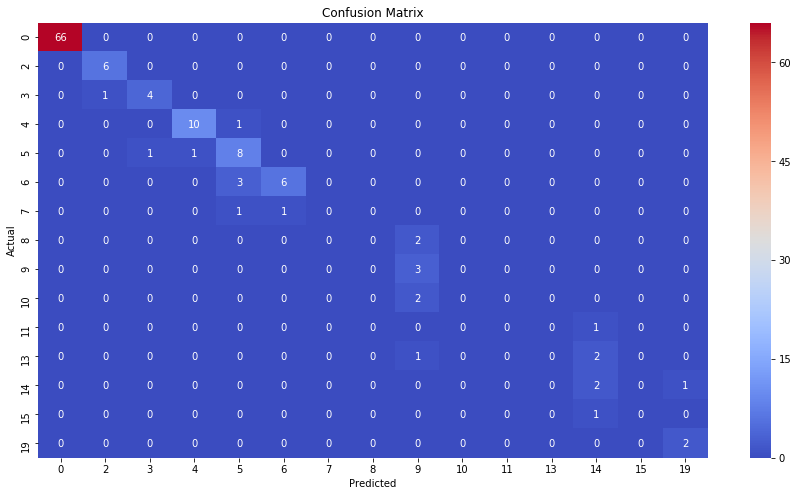

This Model's Training Set Accuracy is: 0.8492063492063492



******************************* TEST SET PERFORMANCE


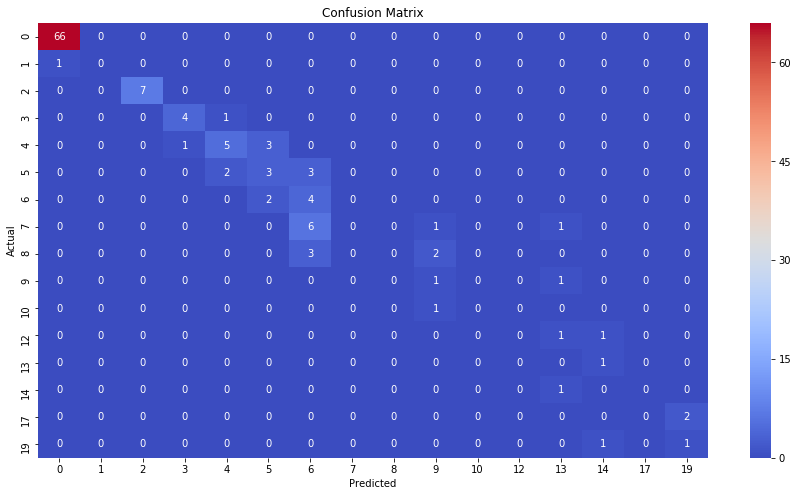

This Model's Test Set Accuracy is: 0.7222222222222222




-------------------------- TRAINING MODEL WITH 151 (60.0%) TRAINING SAMPLES --------------------------


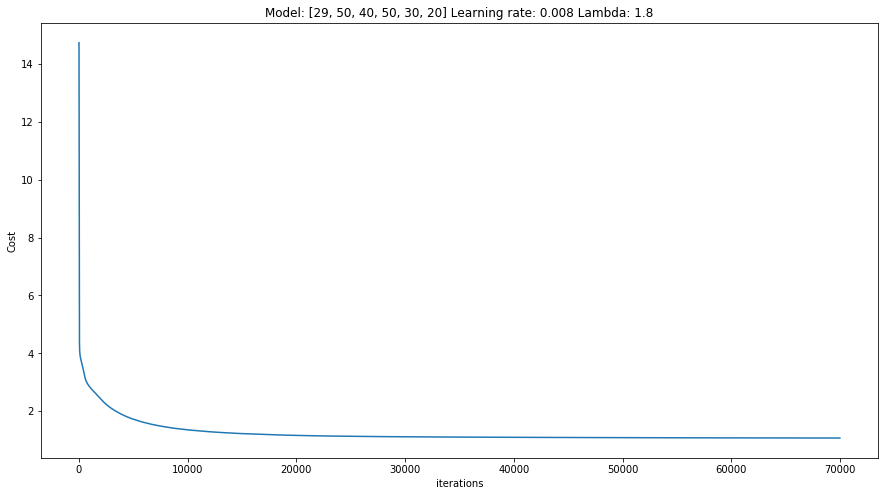




******************************* TRAINING SET PERFORMANCE


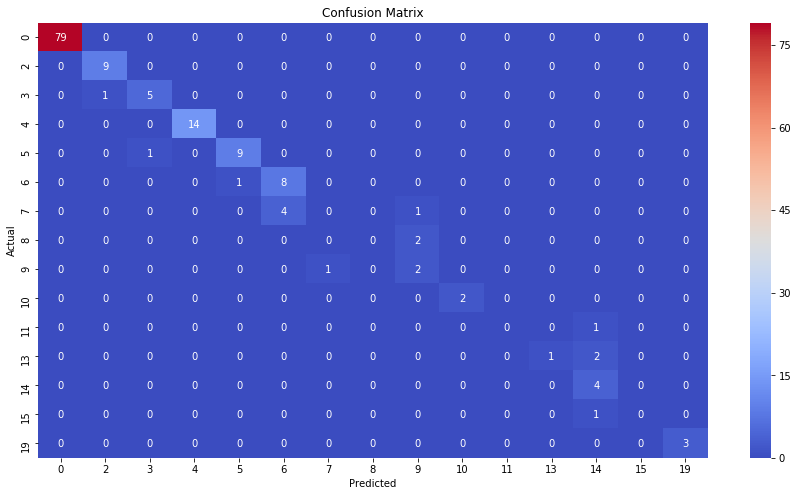

This Model's Training Set Accuracy is: 0.9006622516556292



******************************* TEST SET PERFORMANCE


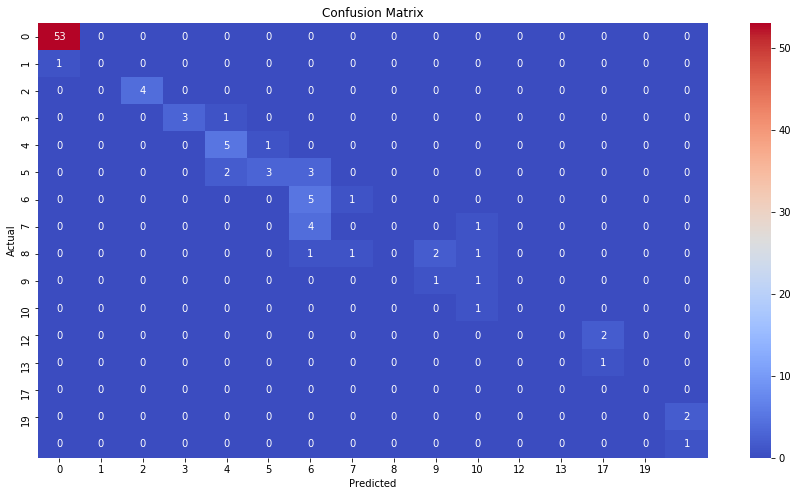

This Model's Test Set Accuracy is: 0.7524752475247525




-------------------------- TRAINING MODEL WITH 189 (75.0%) TRAINING SAMPLES --------------------------


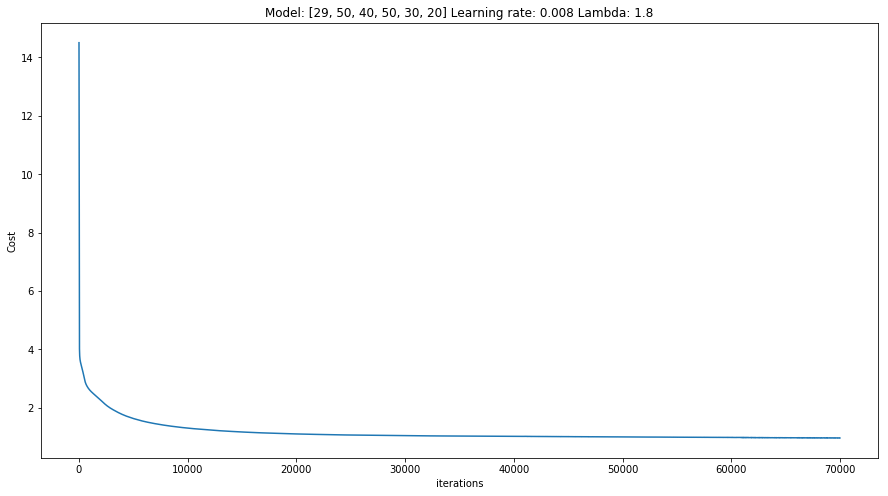




******************************* TRAINING SET PERFORMANCE


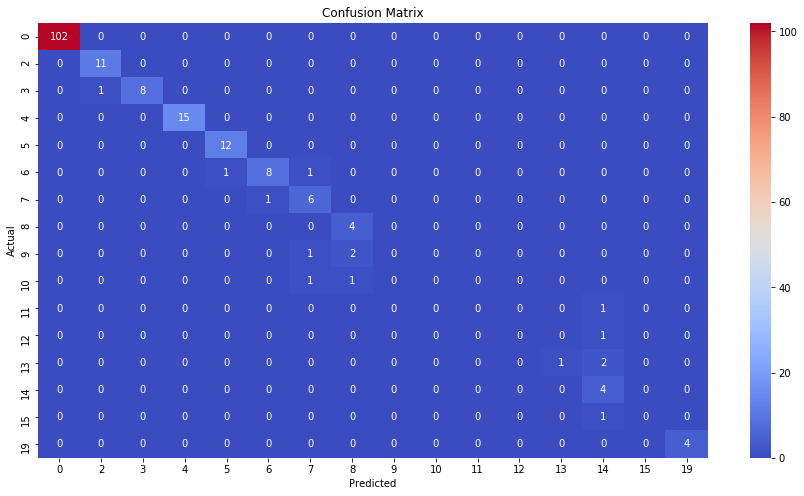

This Model's Training Set Accuracy is: 0.9259259259259259



******************************* TEST SET PERFORMANCE


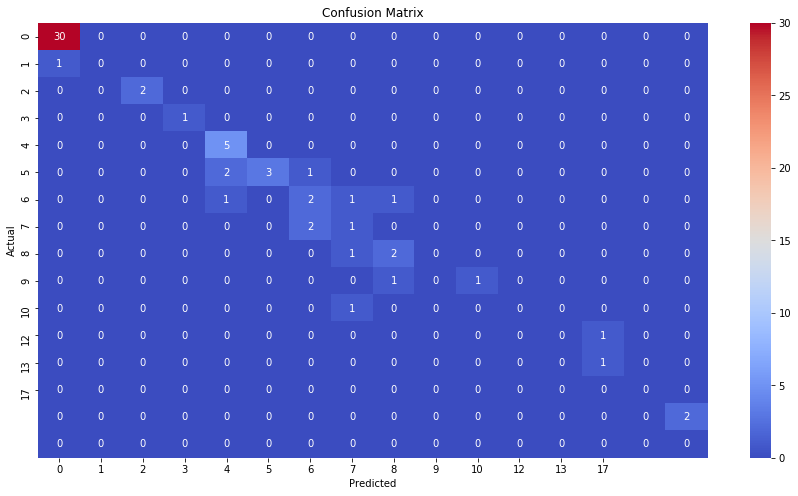

This Model's Test Set Accuracy is: 0.7301587301587301




-------------------------- TRAINING MODEL WITH 227 (90.0%) TRAINING SAMPLES --------------------------


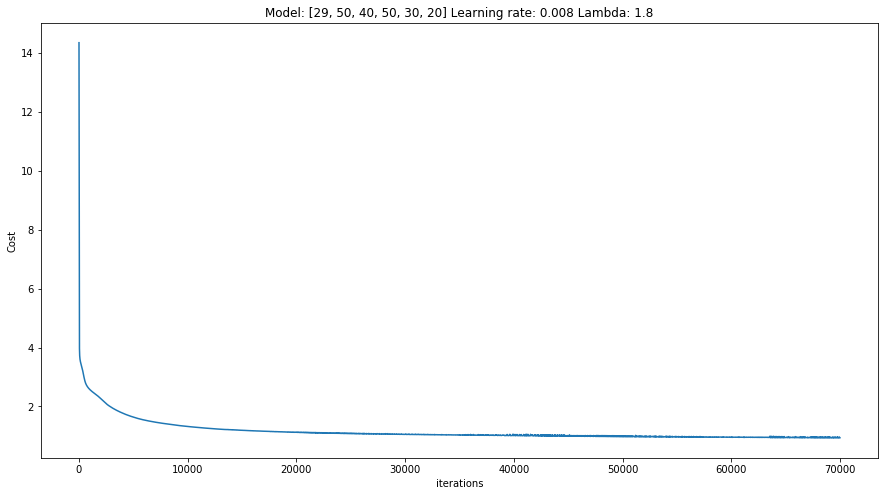




******************************* TRAINING SET PERFORMANCE


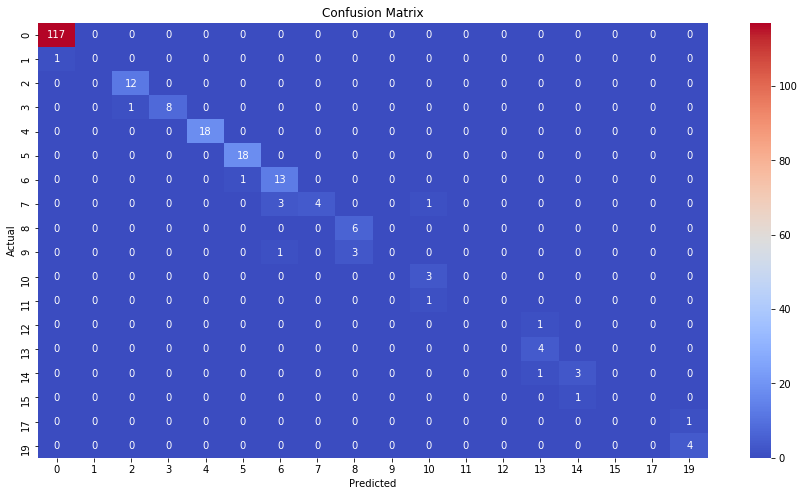

This Model's Training Set Accuracy is: 0.9292035398230089



******************************* TEST SET PERFORMANCE


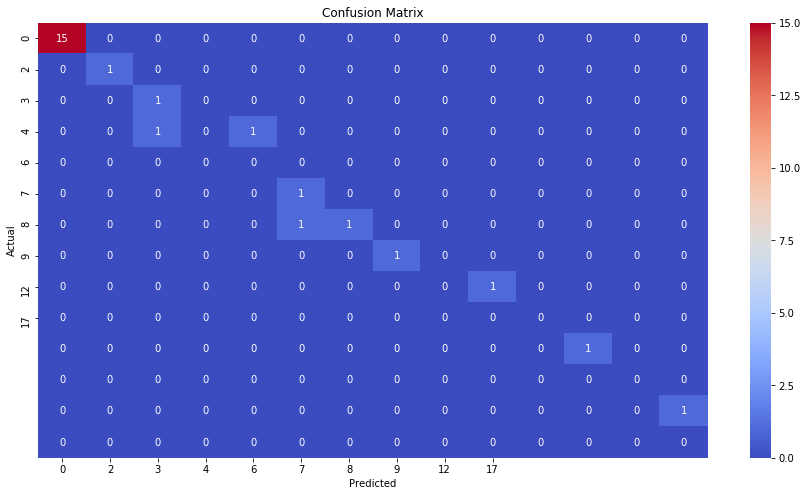

This Model's Test Set Accuracy is: 0.7692307692307693







************************************** NN MODEL [29, 50, 40, 50, 30, 20] PERFORMANCE **************************************


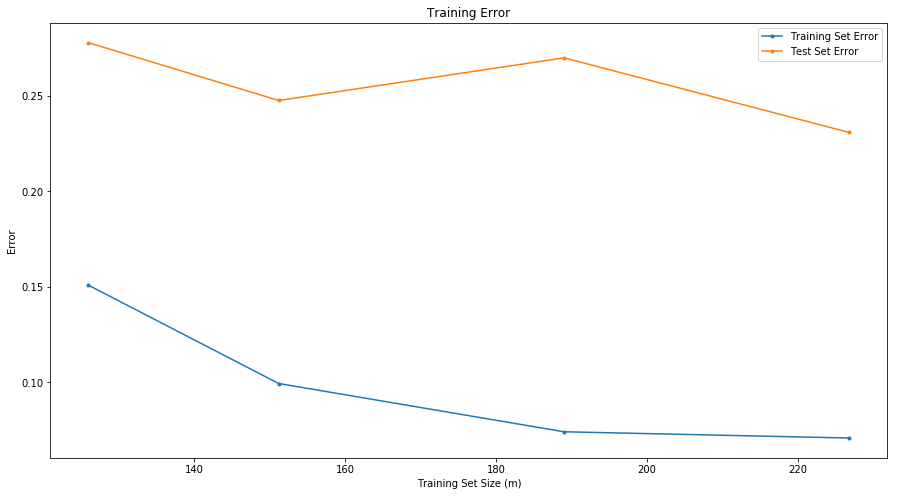

In [27]:
run_model(x20, y20, nn_dims = [29,50,40,50,30,20], learning_rate = 0.008, lambd = 1.8, iterations = 70000)

Trying various models out above, the best results I was able to achieve was 75% on the test set at 60% training examples, 72% at 75% training examples and 77% at 90% training examples. 77% isn't a horrible score. In fact it is 20% more than the accuracy we were able to achieve with the 50 bins model. However as pointed out early, at 20 price range intervals (bins), the margin for error was already small since the ranges are so wide. It is now evident that we need to rethink our strategy on how to better improve our model 

### Regression with NN

Due to unbalanced data, a multi-class classification NN just didn't provide the desired results. So now we will pivot to a regression model. Even though it is a regression model, in order to prevent having to rework our neural network script file, we will need to scale the output data (dependent variable). Our model utilizes both RELU and sigmoid funcations whcih restricts output values between 0 and 1. Therefore, we will simply normalize our output data to 1. This is already done in our make_xy function. We just need to pass a False arguement to "one_hots"

In [28]:
X, Y, xscaler, yscaler = make_xy(df, one_hots = False)

In [29]:
Y[0:20]

array([[0.00683859],
       [0.00844317],
       [0.00806113],
       [0.01203438],
       [0.01062082],
       [0.01012416],
       [0.01658071],
       [0.01180516],
       [0.01081184],
       [0.0095511 ],
       [0.00741165],
       [0.0051958 ],
       [0.00580707],
       [0.00210124],
       [0.00317096],
       [0.00210124],
       [0.0017192 ],
       [0.        ],
       [0.00252149],
       [0.01623687]])

With our output data scaled between 0 and 1 (the input data is also scaled), we will now run through the same process of creating our train and test sets, then running our data through a model

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size = 0.7, test_size = 0.3, random_state = 42)

Cost after iteration 0: 0.692695
Cost after iteration 200: 0.501287
Cost after iteration 400: 0.444818
Cost after iteration 600: 0.414116
Cost after iteration 800: 0.388698
Cost after iteration 1000: 0.370136
Cost after iteration 1200: 0.358680
Cost after iteration 1400: 0.350865
Cost after iteration 1600: 0.345544
Cost after iteration 1800: 0.341668
Cost after iteration 2000: 0.338952
Cost after iteration 2200: 0.337076
Cost after iteration 2400: 0.335742
Cost after iteration 2600: 0.334725
Cost after iteration 2800: 0.333905
Cost after iteration 3000: 0.333203
Cost after iteration 3200: 0.332591
Cost after iteration 3400: 0.332050
Cost after iteration 3600: 0.331569
Cost after iteration 3800: 0.331126
Cost after iteration 4000: 0.330672
Cost after iteration 4200: 0.330244
Cost after iteration 4400: 0.329846
Cost after iteration 4600: 0.329446
Cost after iteration 4800: 0.328997
Cost after iteration 5000: 0.328571
Cost after iteration 5200: 0.328194
Cost after iteration 5400: 0.327768

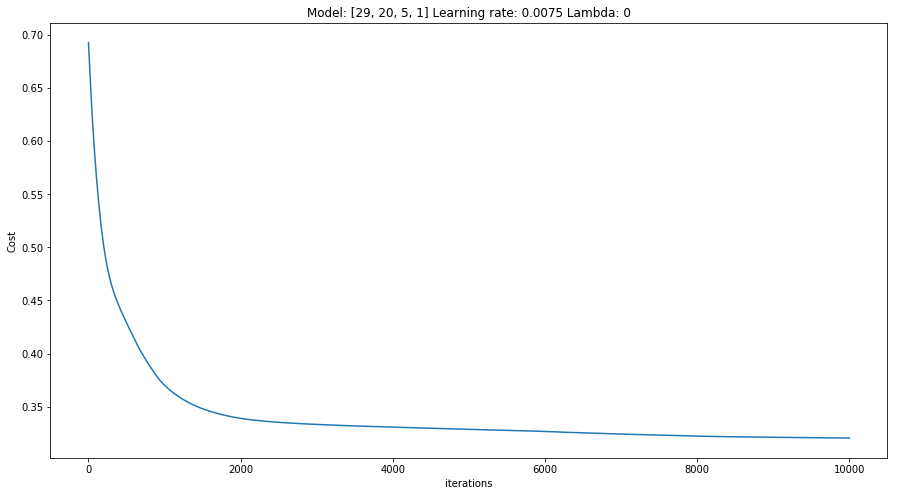

In [31]:
#Train the model and return the best parameters
parameters = dnn_model(X_train.T, y_train.T, layers_dims=[29,20,5,1], learning_rate=0.0075, lambd = 0, num_iterations=10000, print_cost=True)

#Test the model on the Training Set
AL, _ = L_model_forward(X_train.T, parameters, [29,20,7,5,1])

#Test the model on the Test Set
AL_test, _test = L_model_forward(X_test.T, parameters, [29,20,7,5,1])



We are still getting the desired affect on our cost when running several iterations of forward/back prop. The cost is dropping with each iteration. But it does appear to be reaching a local minima of 0.32. This might not be significant enough. Let's look at some performance metrics of our model

In [32]:
#Unscale the true and predicted price values
unscaled_pred = yscaler.inverse_transform(AL.T)
unscaled_y = yscaler.inverse_transform(y_train)

In [33]:
train = pd.DataFrame()
train['true'] = np.squeeze(unscaled_y)
train['pred'] = np.squeeze(unscaled_pred)
train['error'] = train.pred - train.true
train['error_percentage'] = train['error'] / train['true']
train.sort_values('true', ascending = True, inplace = True)
train = train.reset_index().drop('index', axis = 1)
train.head(10)

,true,pred,error,error_percentage
0,0.1525,0.245622,0.093122,0.610636
1,0.1580,0.216018,0.058018,0.367201
2,0.1608,0.210865,0.050065,0.311349
3,0.1661,0.217730,0.051630,0.310835
4,0.1677,0.253045,0.085345,0.508914
5,0.1704,0.190826,0.020426,0.119868
6,0.1708,0.275117,0.104317,0.610757
7,0.1710,0.271782,0.100782,0.589366
8,0.1729,0.210720,0.037820,0.218740
9,0.1736,0.201042,0.027442,0.158079


For the first few predictions we can see there's not too terrible of prediction performance from our model. There's a .09, .05, 0.05, etc, price difference between true and predicted. That might not seem like much, but due to already being at a low price point, 0.09, 0.05, etc corresponds to a 61%, 36%, etc price over prediction. Let's see how the error percentage looks like thorugh the whole XRP Price range

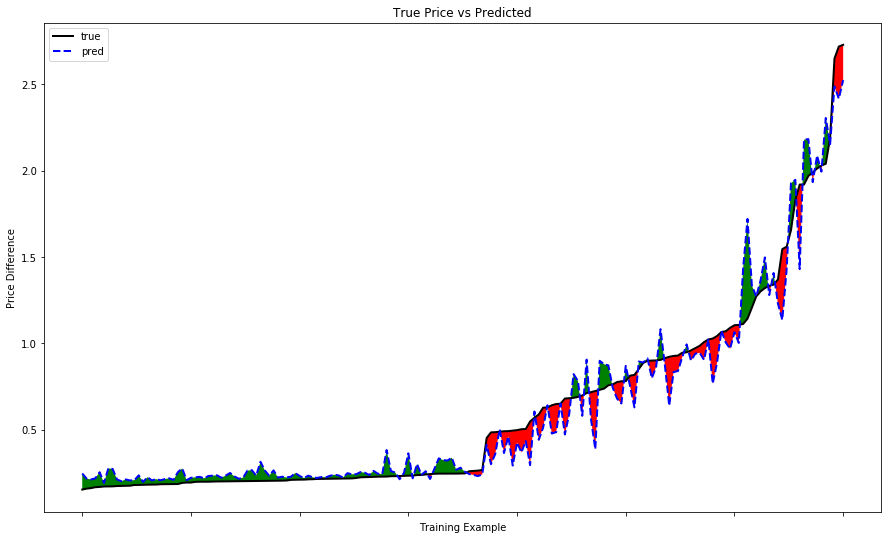

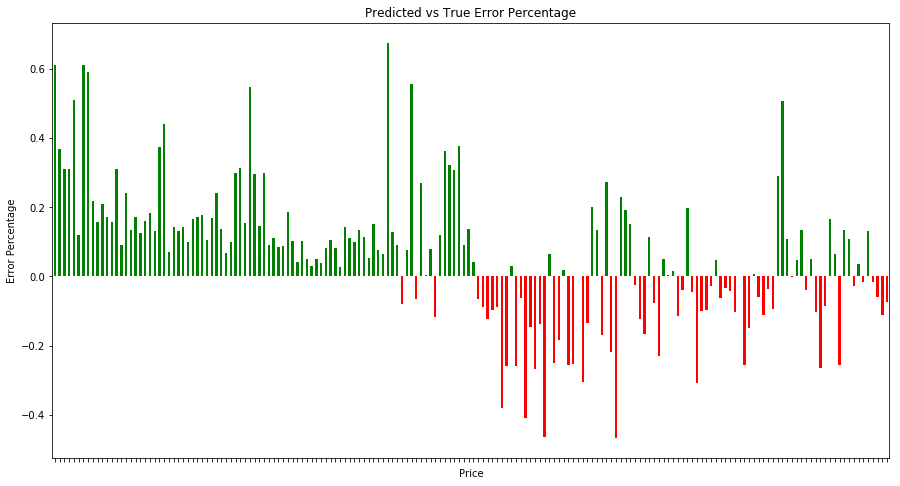

In [34]:
colors = []
for i in train.error:
    if i <= 0:
        colors.append('r')
    else:
        colors.append('g')

ax = train.true.plot(figsize = (15,9), lw = 2, color = 'k', ls = '-')
train.pred.plot(ax = ax, linestyle = '--', lw = 2, color = 'blue')
ax.fill_between(train.index, train.true, train.pred, where =(train.pred > train.true), facecolor = 'g', interpolate = True)
ax.fill_between(train.index, train.true, train.pred, where =(train.pred < train.true), facecolor = 'r', interpolate = True)
ax.set_ylabel('Price')
ax.set_xlabel('Training Example')
ax.set_ylabel('Price Difference')
ax.set_title('True Price vs Predicted')
ax.set_xticklabels([])
ax.legend()
plt.show()

colors = []
for i in train.error:
    if i <= 0:
        colors.append('r')
    else:
        colors.append('g')
ax = train.error_percentage.plot(kind = 'bar', figsize = (15,8), color = colors)
ax.set_xticklabels([])
ax.set_title('Predicted vs True Error Percentage')
ax.set_xlabel('Price')
ax.set_ylabel('Error Percentage')
plt.show()

When overlaying the predicted price over the true price, the difference doesn't appear that far off. However we can see when plotting the error percentage above, because of such small price points, the smallest price difference can correspond to a high percentage error. This wouldn't be such a bad thing if the model was under predicting, but we can see above that the model is mostly over predicting in the lower price regions. Not only that, but it is over predicting in upwards of 60%. Let's see how this error breaks down for difference price range intervals

In [35]:
print('The Mean Squared Error is {}'.format(mean_squared_error(train.true, train.pred)**0.5))

train['bins'] = pd.cut(train.true, bins = 25)
train.groupby('bins').error_percentage.describe().sort_values('mean')

The Mean Squared Error is 0.12098612480543561


,count,mean,std,min,25%,50%,75%,max
bins,,,,,,,,
"(0.462, 0.565]",10.0,-0.235285,0.157570,-0.462632,-0.352830,-0.257942,-0.139847,0.030288
"(1.493, 1.596]",2.0,-0.175096,0.127987,-0.265596,-0.220346,-0.175096,-0.129845,-0.084595
"(0.565, 0.668]",7.0,-0.122389,0.144221,-0.255565,-0.250975,-0.184116,0.010508,0.063890
"(0.256, 0.359]",4.0,-0.092294,0.023768,-0.121918,-0.102098,-0.091480,-0.081676,-0.064299
"(0.359, 0.462]",1.0,-0.087610,NaN,-0.087610,-0.087610,-0.087610,-0.087610,-0.087610
"(0.977, 1.08]",7.0,-0.085590,0.092528,-0.254433,-0.125344,-0.060667,-0.020449,0.007555
"(2.627, 2.73]",3.0,-0.082263,0.026032,-0.111186,-0.093039,-0.074891,-0.067802,-0.060713
"(0.771, 0.874]",6.0,-0.071751,0.131313,-0.230635,-0.154759,-0.099936,0.019585,0.113607
"(0.874, 0.977]",13.0,-0.043010,0.112936,-0.306925,-0.096628,-0.040047,0.003792,0.197125


The price ranges of (0.565 - 0.668], (1.493 - 1.596], and (0.462 - 0.565] are the highest average "under predicted" price ranges at -12.2%, -17.5%, and -0.23% respectively. On the other end of the spectrum, the price ranges of (1.08 - 1.184], (1.596 - 1.699], (0.15 - 0.256] are the highest average "over predicted" price ranges at 11%, 16.5%, and 18.3% respectively. It is pretty evident that this model is very noisy and needs to be refined. Let's tweak some of the hyperparameters

In [36]:
def regression_model(X,y, nn_dims, learning_rate, lambd, iterations, yscaler = yscaler):
    train_set_size = [0.5, 0.6, 0.75, 0.9]
    train_scores = []
    test_scores = []
    parameters_list = []
    for size in train_set_size:
        print('\n-------------------------- TRAINING MODEL WITH {:.0f} ({}%) TRAINING SAMPLES --------------------------'.format(len(X)*size, size*100))
        X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = size, test_size = 1-size, random_state = 42)
        
        parameters = dnn_model(X_train.T, y_train.T, layers_dims = nn_dims, learning_rate=learning_rate, lambd = lambd, num_iterations=iterations, print_cost=False)
        parameters_list.append(parameters)
        #Test the model on the Training Set
        AL, _ = L_model_forward(X_train.T, parameters, nn_dims)

        #Test the model on the Test Set
        AL_test, _test = L_model_forward(X_test.T, parameters, nn_dims)
        
        train_unscaled_pred = yscaler.inverse_transform(AL.T)
        train_unscaled_y = yscaler.inverse_transform(y_train)
        
        test_unscaled_pred = yscaler.inverse_transform(AL_test.T)
        test_unscaled_y = yscaler.inverse_transform(y_test)
        
       
        def performance(unscaled_pred, unscaled_y):
            df = pd.DataFrame()
            df['true'] = np.squeeze(unscaled_y)
            df['pred'] = np.squeeze(unscaled_pred)
            df['error'] = df.pred - df.true
            df['error_percentage'] = df['error'] / df['true']
            unsorted = df
            df.sort_values('true', ascending = True, inplace = True)
            df = df.reset_index().drop('index', axis = 1)

            ax = df.true.plot(figsize = (15,9), lw = 1, color = 'k', ls = '-')
            df.pred.plot(ax = ax, linestyle = '-', lw = 1, color = 'blue')
            ax.fill_between(df.index, df.true, df.pred, where =(df.pred > df.true), facecolor = 'g', interpolate = True)
            ax.fill_between(df.index, df.true, df.pred, where =(df.pred < df.true), facecolor = 'r', interpolate = True)

            ax.set_xlabel('Training Example')
            ax.set_ylabel('Price')
            ax.set_title('True Price vs Predicted')
            ax.legend()
            plt.show()

            colors = []
            for i in df.error:
                if i <= 0:
                    colors.append('r')
                else:
                    colors.append('g')
            ax = df.error_percentage.plot(kind = 'bar', figsize = (15,8), color = colors)
            ax.set_xticklabels([])
            ax.set_title('Predicted vs True Error Percentage')
            ax.set_xlabel('Price')
            ax.set_ylabel('Error Percentage')
            plt.show()
            
            rmse = mean_squared_error(df.true, df.pred)**0.5
            print('RMSE For These Parameters: {}'.format(rmse))
            df['bins'] = pd.cut(df.true, bins = 25)
            print('\n\n\nError Statistics By Price Ranges\n\n')
            print(df.groupby('bins').error_percentage.describe().sort_values('mean'))
            return rmse, unsorted
            
        print('\n\n\n\n\n********************************************* Training Set Performance *********************************************')    
        train_rmse, train_df = performance(train_unscaled_pred, train_unscaled_y)
        
        print('\n\n\n\n\n********************************************* Test Set Performance *********************************************')
        test_rmse, test_df = performance(test_unscaled_pred, test_unscaled_y)
                  
        train_scores.append(train_rmse)
        test_scores.append(test_rmse)
                  
    fig = plt.figure(figsize = (15,8))
    plt.plot(train_set_size, train_scores, label = 'Training Set RMSE', marker = 'o')
    plt.plot(train_set_size, test_scores, label = 'Test Set RMSE', marker = 'o')
    plt.xlabel('Train Set Size')
    plt.ylabel('RMSE')
    plt.title('Training Error')
    plt.legend()
    plt.show()
    return parameters_list, train_df


-------------------------- TRAINING MODEL WITH 126 (50.0%) TRAINING SAMPLES --------------------------


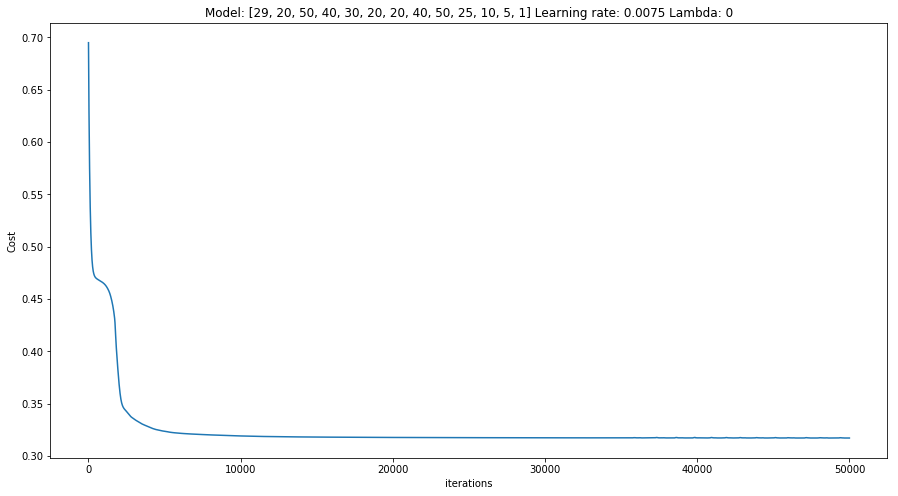






********************************************* Training Set Performance *********************************************


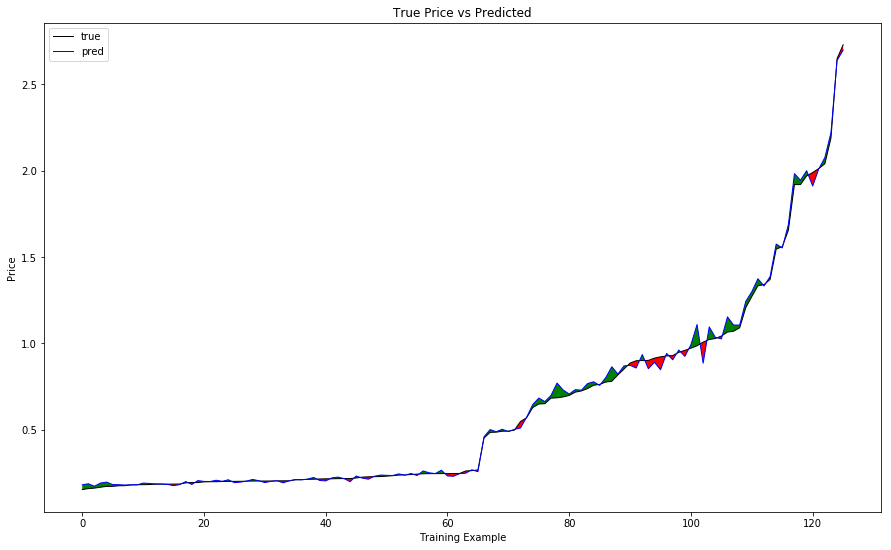

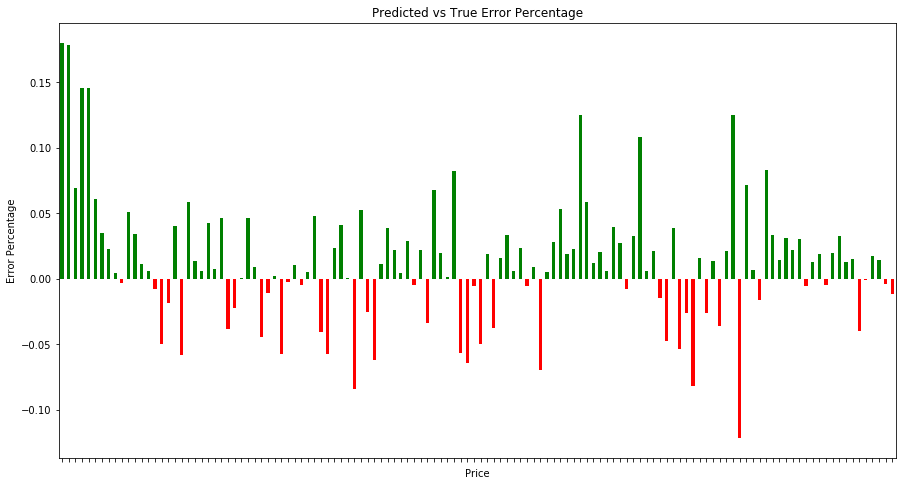

RMSE For These Parameters: 0.02959550073799851



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.256, 0.359]    3.0 -0.022632  0.036516 -0.049498 -0.043420 -0.037342   
(0.874, 0.977]   11.0 -0.017851  0.036857 -0.081640 -0.041661 -0.026182   
(2.627, 2.73]     2.0 -0.007685  0.005085 -0.011281 -0.009483 -0.007685   
(0.462, 0.565]    6.0 -0.000475  0.036525 -0.069548 -0.002593  0.007461   
(1.905, 2.008]    4.0  0.005508  0.031302 -0.039498 -0.000161  0.014247   
(1.493, 1.596]    2.0  0.007187  0.016524 -0.004498  0.001344  0.007187   
(2.008, 2.111]    2.0  0.008472  0.013213 -0.000871  0.003800  0.008472   
(1.287, 1.39]     3.0  0.012519  0.018250 -0.005788  0.003423  0.012633   
(2.111, 2.214]    1.0  0.014294       NaN  0.014294  0.014294  0.014294   
(1.08, 1.184]     1.0  0.014423       NaN  0.014423  0.014423  0.014423   
(0.15, 0.256]  

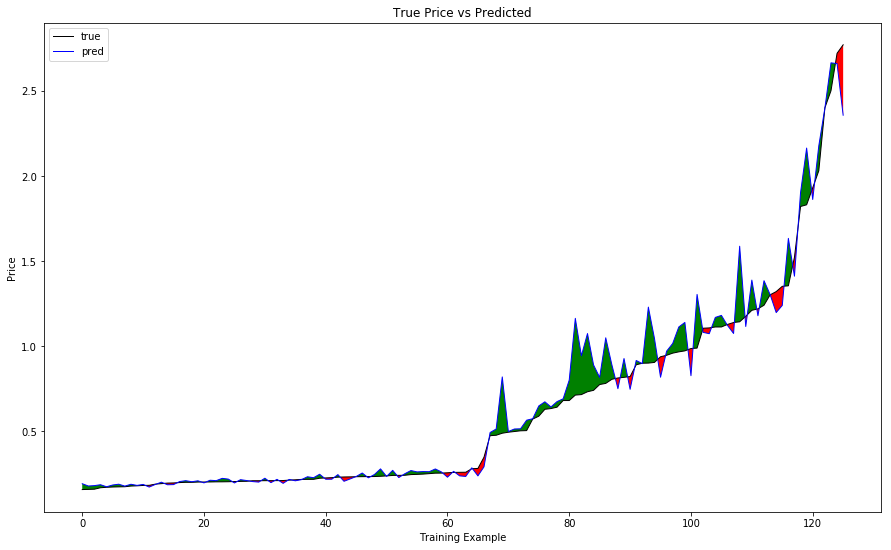

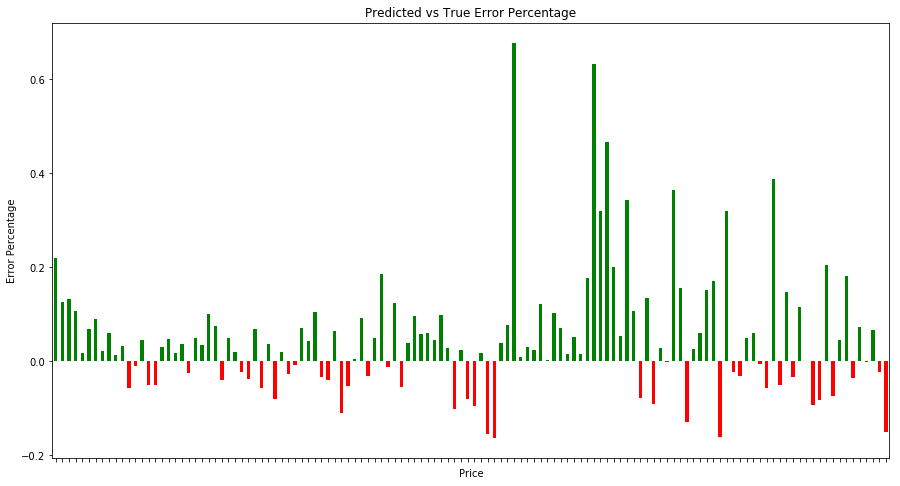

RMSE For These Parameters: 0.11639206930855683



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.262, 0.366]    3.0 -0.100053  0.102848 -0.163198 -0.159392 -0.155586   
(2.665, 2.77]     2.0 -0.085830  0.089852 -0.149365 -0.117597 -0.085830   
(1.516, 1.62]     1.0 -0.073223       NaN -0.073223 -0.073223 -0.073223   
(2.352, 2.456]    1.0 -0.000672       NaN -0.000672 -0.000672 -0.000672   
(1.307, 1.411]    3.0  0.009835  0.169878 -0.093378 -0.088199 -0.083019   
(0.784, 0.889]    4.0  0.018434  0.119454 -0.091425 -0.080888  0.014790   
(0.154, 0.262]   64.0  0.025523  0.067852 -0.110139 -0.027976  0.031794   
(1.098, 1.202]    8.0  0.041856  0.146642 -0.056622 -0.035826 -0.013539   
(1.725, 1.829]    1.0  0.044598       NaN  0.044598  0.044598  0.044598   
(1.202, 1.307]    4.0  0.057803  0.087199 -0.033218 -0.007284  0.058801   
(0.575, 0.68]  

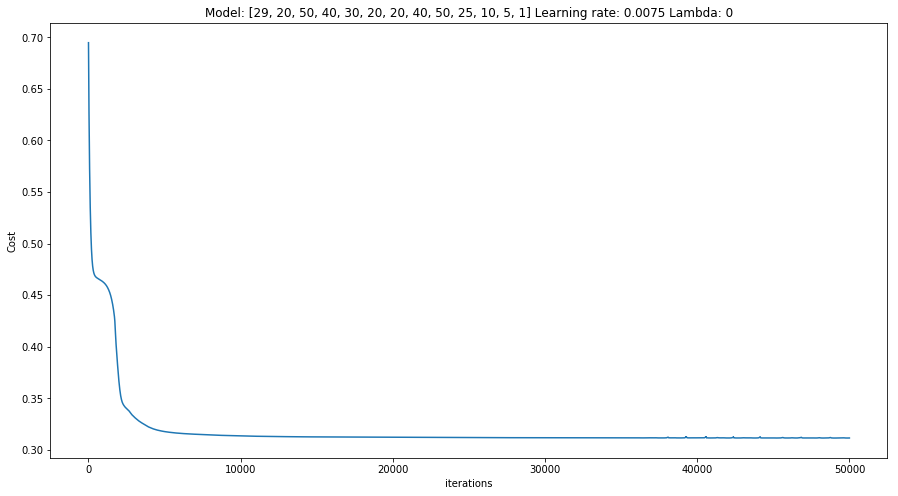






********************************************* Training Set Performance *********************************************


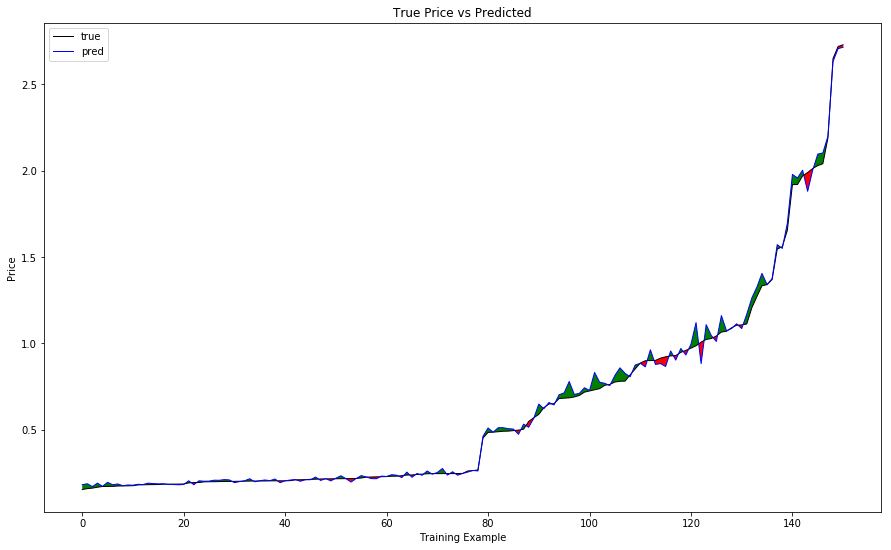

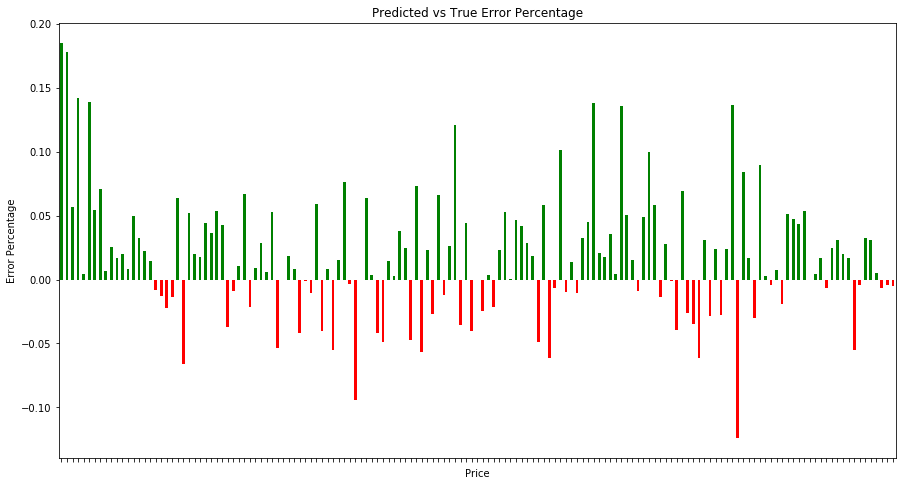

RMSE For These Parameters: 0.032496679491807026



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.256, 0.359]    3.0 -0.014195  0.015544 -0.024695 -0.023123 -0.021551   
(0.874, 0.977]   11.0 -0.006428  0.039029 -0.061122 -0.031448 -0.026183   
(2.627, 2.73]     3.0 -0.005345  0.000874 -0.006325 -0.005695 -0.005065   
(1.905, 2.008]    4.0  0.003171  0.039141 -0.054881 -0.001023  0.018483   
(2.111, 2.214]    1.0  0.004783       NaN  0.004783  0.004783  0.004783   
(1.493, 1.596]    2.0  0.005154  0.016127 -0.006250 -0.000548  0.005154   
(1.08, 1.184]     4.0  0.008796  0.030304 -0.019251 -0.008011  0.001628   
(0.462, 0.565]    9.0  0.015103  0.043900 -0.061604  0.000091  0.028595   
(0.565, 0.668]    5.0  0.017644  0.048015 -0.010668 -0.009698 -0.006569   
(0.15, 0.256]    76.0  0.018648  0.051980 -0.093978 -0.011001  0.014396   
(1.287, 1.39] 

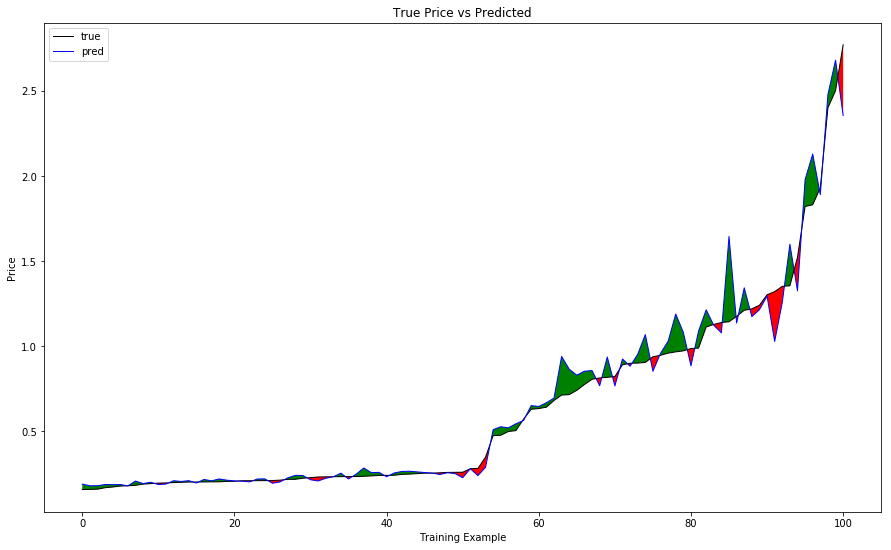

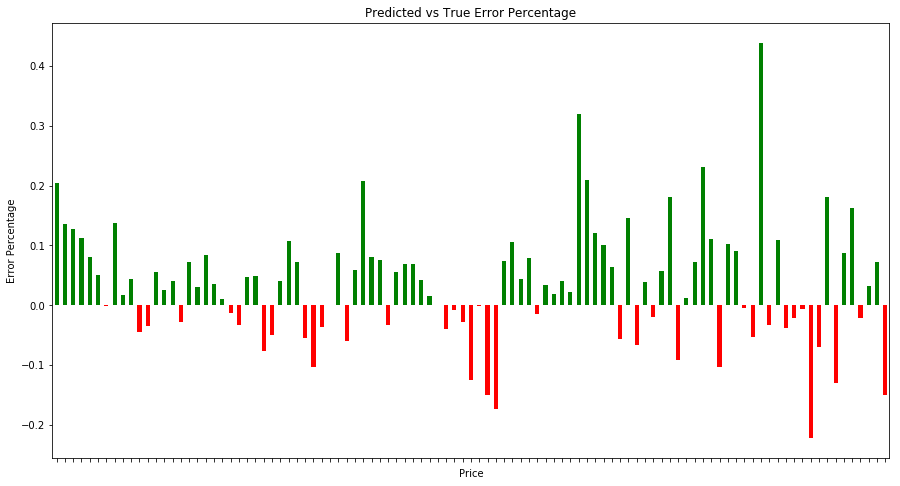

RMSE For These Parameters: 0.10280797922711653



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.665, 2.77]     1.0 -0.149862       NaN -0.149862 -0.149862 -0.149862   
(1.516, 1.62]     1.0 -0.129761       NaN -0.129761 -0.129761 -0.129761   
(0.262, 0.366]    3.0 -0.107702  0.093299 -0.172635 -0.161159 -0.149683   
(1.307, 1.411]    3.0 -0.037042  0.203265 -0.221874 -0.145889 -0.069904   
(1.202, 1.307]    4.0  0.011211  0.066699 -0.037605 -0.025259 -0.013445   
(0.784, 0.889]    4.0  0.021846  0.102163 -0.066897 -0.058968  0.003887   
(0.154, 0.262]   51.0  0.030895  0.070168 -0.125358 -0.028564  0.039966   
(0.575, 0.68]     3.0  0.031516  0.010740  0.019625  0.027019  0.034413   
(2.352, 2.456]    1.0  0.032652       NaN  0.032652  0.032652  0.032652   
(0.889, 0.993]   11.0  0.053891  0.103066 -0.102769 -0.003436  0.057460   
(0.471, 0.575] 

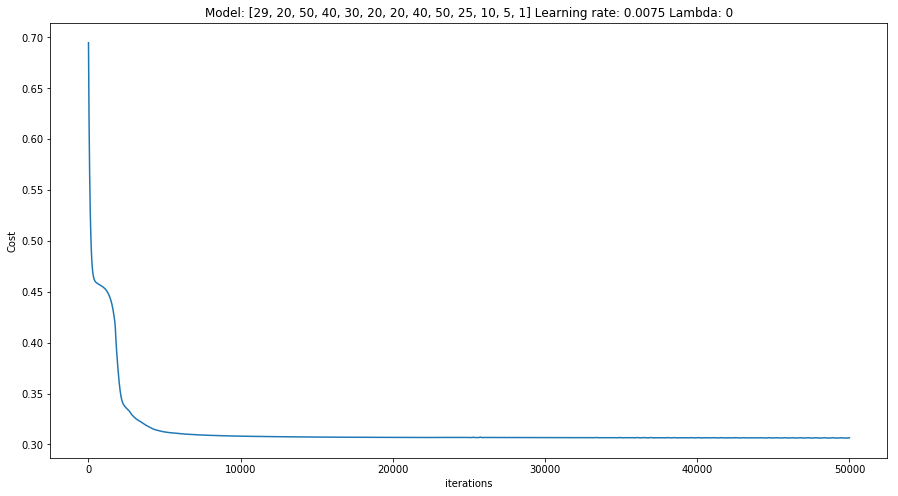






********************************************* Training Set Performance *********************************************


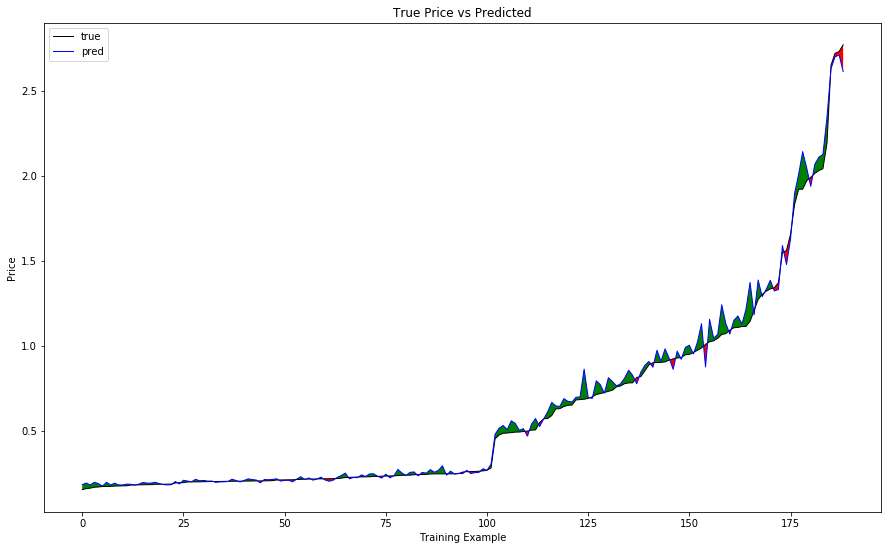

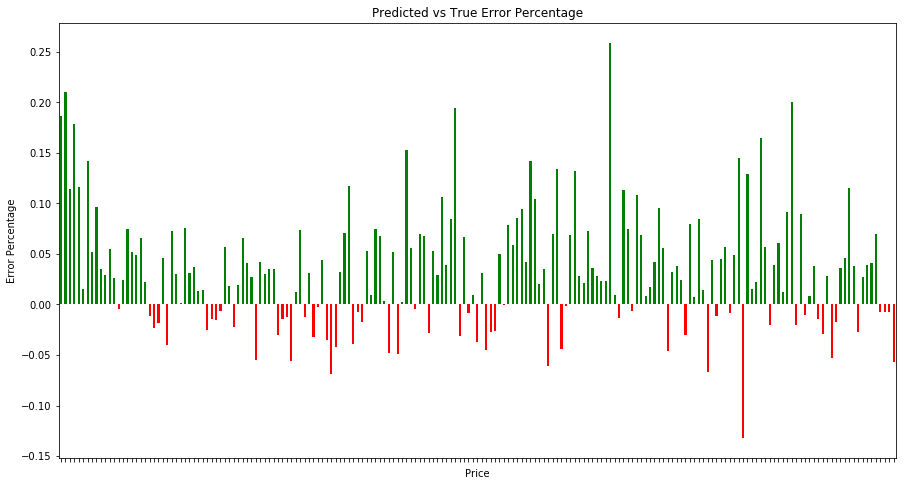

RMSE For These Parameters: 0.04927002763951985



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.665, 2.77]     3.0 -0.023910  0.028469 -0.056783 -0.032202 -0.007621   
(1.618, 1.723]    1.0 -0.017224       NaN -0.017224 -0.017224 -0.017224   
(1.514, 1.618]    2.0 -0.012690  0.057209 -0.053143 -0.032917 -0.012690   
(2.561, 2.665]    1.0 -0.007499       NaN -0.007499 -0.007499 -0.007499   
(1.304, 1.409]    4.0  0.000706  0.029226 -0.029364 -0.017886 -0.002842   
(0.257, 0.362]    7.0  0.008811  0.045719 -0.044988 -0.026296 -0.000630   
(1.932, 2.037]    4.0  0.019125  0.031118 -0.026822  0.013329  0.032272   
(1.2, 1.304]      3.0  0.019702  0.061071 -0.020436 -0.015439 -0.010443   
(0.781, 0.885]    4.0  0.019876  0.045271 -0.046269  0.012238  0.034915   
(0.885, 0.99]    14.0  0.031001  0.053517 -0.066742 -0.004885  0.033756   
(0.15, 0.257]  

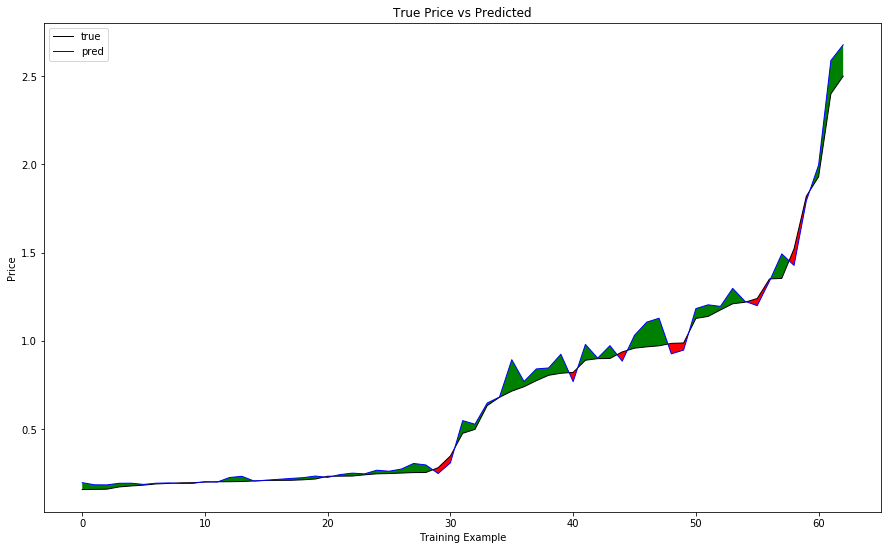

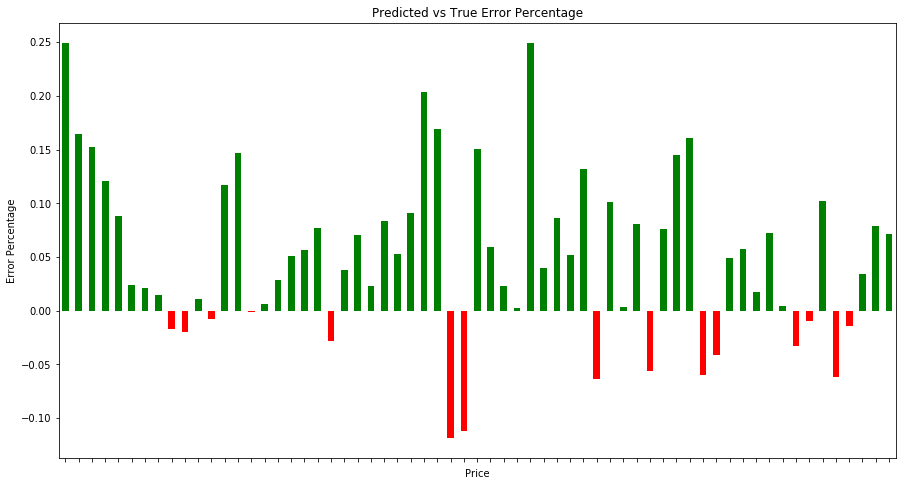

RMSE For These Parameters: 0.06452022576614959



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.344, 0.438]    1.0 -0.112504       NaN -0.112504 -0.112504 -0.112504   
(1.469, 1.563]    1.0 -0.062013       NaN -0.062013 -0.062013 -0.062013   
(1.75, 1.844]     1.0 -0.014619       NaN -0.014619 -0.014619 -0.014619   
(1.188, 1.282]    3.0  0.014626  0.053238 -0.032655 -0.014206  0.004244   
(1.844, 1.938]    1.0  0.034480       NaN  0.034480  0.034480  0.034480   
(0.907, 1.0]      6.0  0.037528  0.102710 -0.060143 -0.052215  0.017614   
(1.094, 1.188]    3.0  0.041457  0.021386  0.017257  0.033277  0.049296   
(1.282, 1.375]    2.0  0.046577  0.079101 -0.009356  0.018610  0.046577   
(0.813, 0.907]    5.0  0.050626  0.079576 -0.063591  0.003158  0.080892   
(0.719, 0.813]    3.0  0.059318  0.024036  0.040070  0.045847  0.051625   
(0.155, 0.251] 

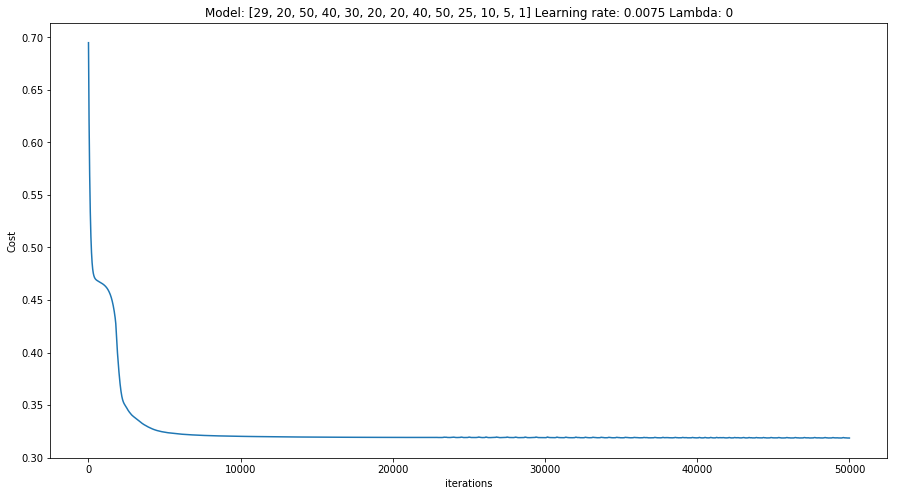






********************************************* Training Set Performance *********************************************


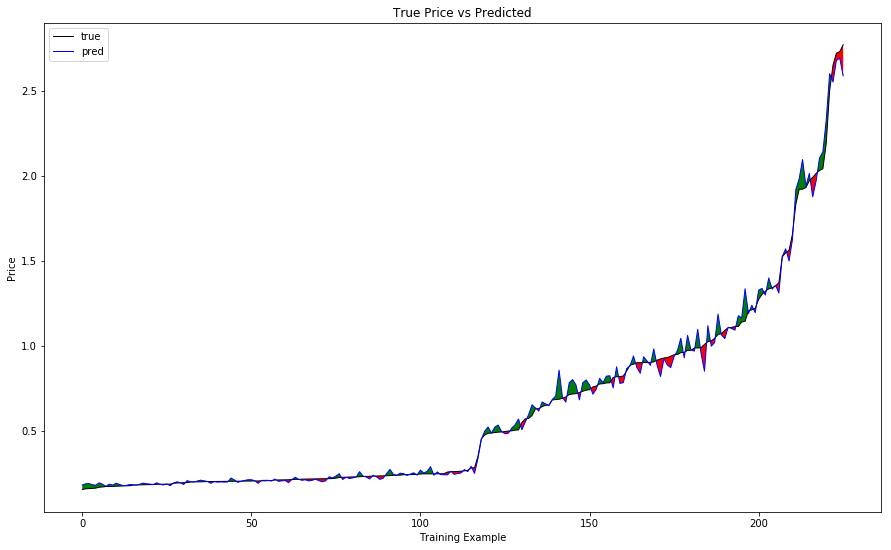

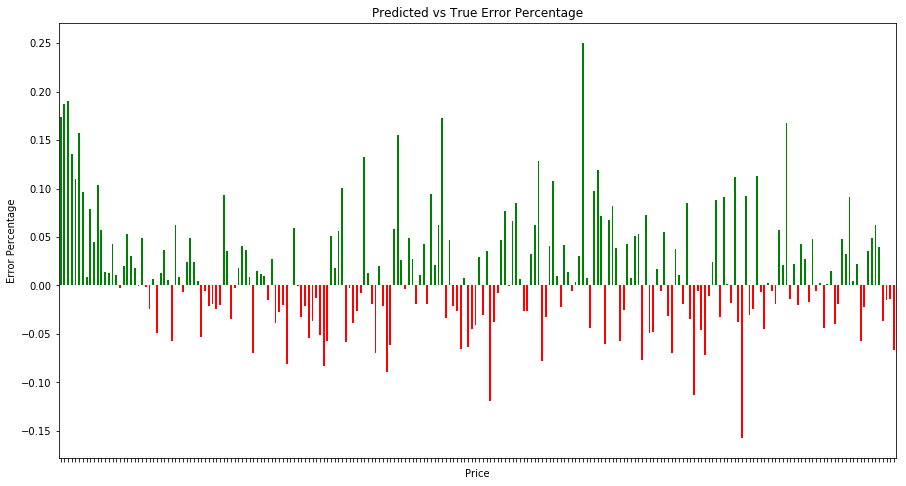

RMSE For These Parameters: 0.04392063702190872



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.561, 2.665]    1.0 -0.037169       NaN -0.037169 -0.037169 -0.037169   
(2.665, 2.77]     3.0 -0.031939  0.029622 -0.066138 -0.040772 -0.015406   
(0.257, 0.362]    9.0 -0.029232  0.048465 -0.119286 -0.045404 -0.037729   
(1.618, 1.723]    1.0 -0.019643       NaN -0.019643 -0.019643 -0.019643   
(0.99, 1.095]     7.0 -0.008387  0.090561 -0.157450 -0.037922 -0.023920   
(0.362, 0.467]    1.0 -0.008061       NaN -0.008061 -0.008061 -0.008061   
(1.514, 1.618]    3.0 -0.007786  0.028735 -0.039982 -0.019308  0.001366   
(1.932, 2.037]    4.0 -0.005467  0.042799 -0.057744 -0.031114 -0.000083   
(0.781, 0.885]    6.0 -0.005099  0.061233 -0.076472 -0.048730 -0.015406   
(1.304, 1.409]    5.0 -0.003229  0.033861 -0.044360 -0.017094 -0.005943   
(0.885, 0.99]  

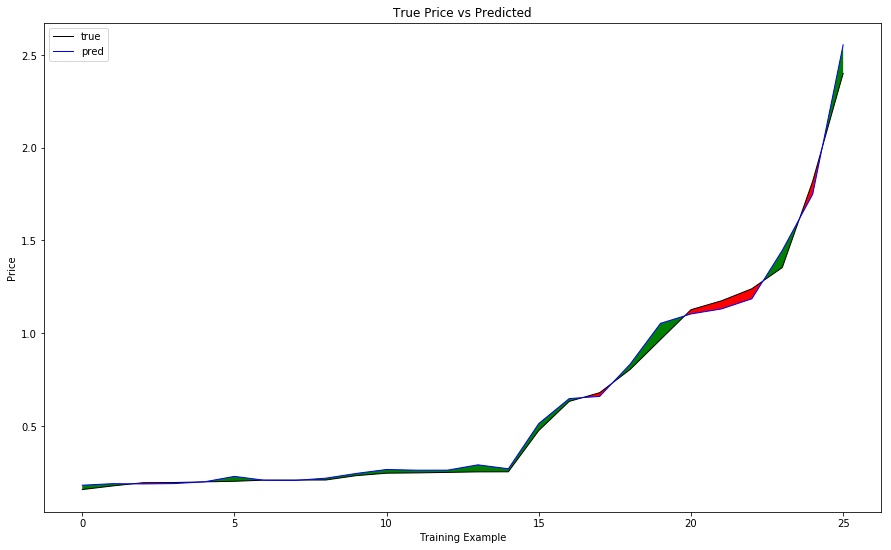

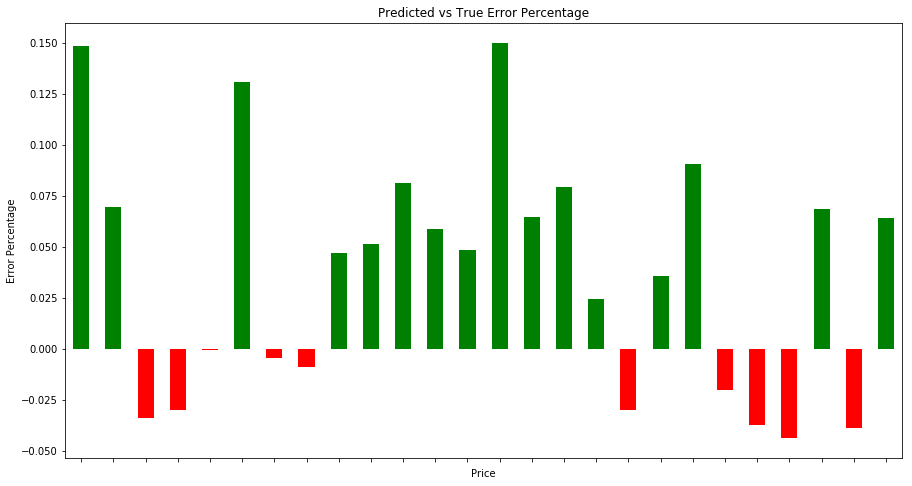

RMSE For These Parameters: 0.04709051666302975



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(1.234, 1.324]    1.0 -0.043718       NaN -0.043718 -0.043718 -0.043718   
(1.772, 1.862]    1.0 -0.038932       NaN -0.038932 -0.038932 -0.038932   
(1.144, 1.234]    1.0 -0.037314       NaN -0.037314 -0.037314 -0.037314   
(1.055, 1.144]    1.0 -0.020308       NaN -0.020308 -0.020308 -0.020308   
(0.606, 0.696]    2.0 -0.002727  0.038286 -0.029800 -0.016263 -0.002727   
(0.786, 0.875]    1.0  0.035734       NaN  0.035734  0.035734  0.035734   
(0.156, 0.248]   11.0  0.040906  0.062558 -0.034094 -0.006724  0.047020   
(2.31, 2.4]       1.0  0.064300       NaN  0.064300  0.064300  0.064300   
(1.324, 1.414]    1.0  0.068647       NaN  0.068647  0.068647  0.068647   
(0.427, 0.517]    1.0  0.079329       NaN  0.079329  0.079329  0.079329   
(0.248, 0.337] 

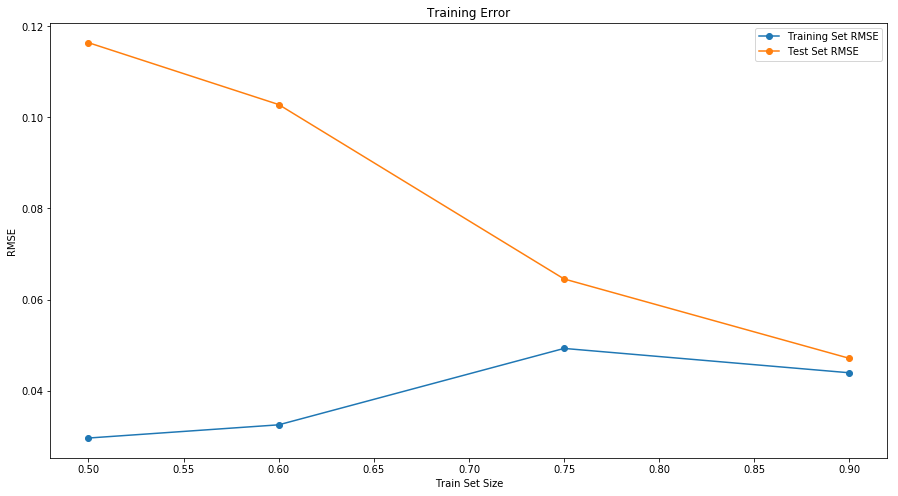

In [37]:
parameters, df = regression_model(X,Y, [29,20,50,40,30,20,20,40,50,25,10,5,1], 0.0075, 0, 50000, yscaler)

After playing around with several different NN architectures and hyperparameters, we've found a respectable performing model. At 90% training examples, RMSE for the training set was at 0.04 and the RMSE for the test set was 0.047. These regression NNs still suffer from the same problem as the multi-class classification models in that there just isn't a uniform distribution of samples. Because of this, this model still might not generalize very well to unseen data. But this is why the price ranges are broken down into their individual statistics. From the individual range statistics, we can account for the error in our predictions based off of the  average percentage error for each range. E.g. from the test set statistics, if our model predicts a price in the range of 0.965 to 1.055, there's on average a 9% average over prediction for this price range. Adjusting for this average error should improve prediction accuracy.

# UPDATE

So it's been about a month and a half since training these networks and I've accumulated more training examples. Previous models were suffering from nearly homogenous training samples on the lower price end. And as such, they didn't perform well on examples outside of the overly represented price ranges. I've also added 2 new features to train the model on, 10 and 30 day price performance. With our new examples, let's see how much we can improve our models

In [6]:
df2 = pd.read_csv('XRP_Data_Updated.csv').drop(['Date','binned price'], axis = 1)
df2[['XRP_Change','XRP_Price']] = df2[['XRP_Change','XRP_Price']].shift(1)
df2.at[0,['XRP_Change','XRP_Price']] = [9.57, 0.1786]
print('There are {} new training samples'.format(len(df2)-len(df)))
print(df2.shape)

There are 56 new training samples
(309, 32)


In [39]:
X,Y,xscaler,yscaler = make_xy(df2, one_hots = False)


-------------------------- TRAINING MODEL WITH 154 (50.0%) TRAINING SAMPLES --------------------------


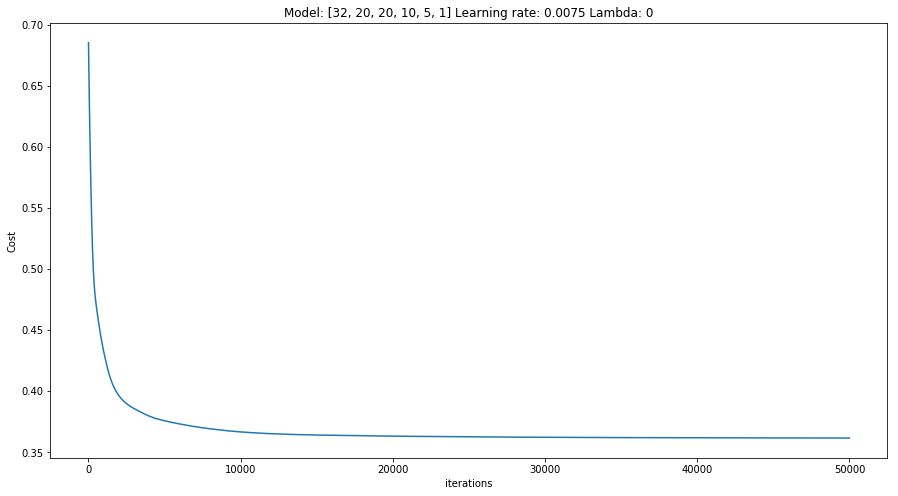






********************************************* Training Set Performance *********************************************


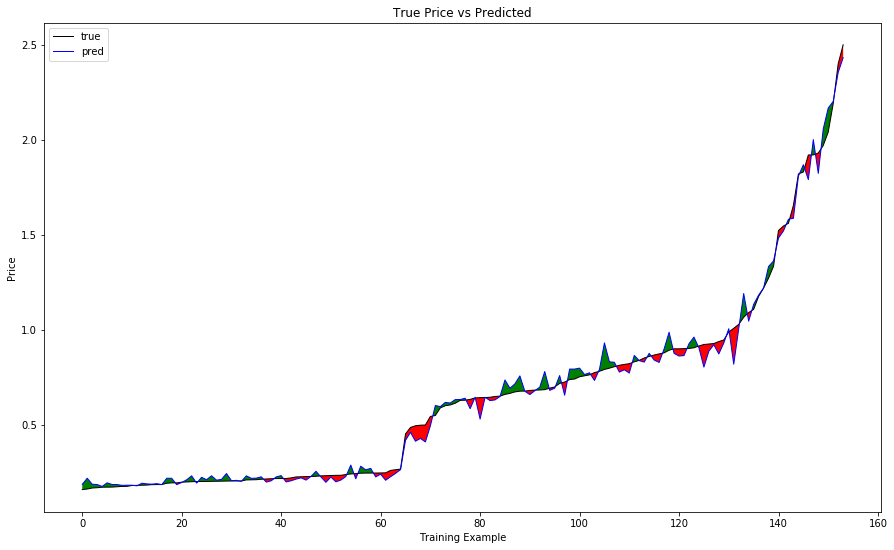

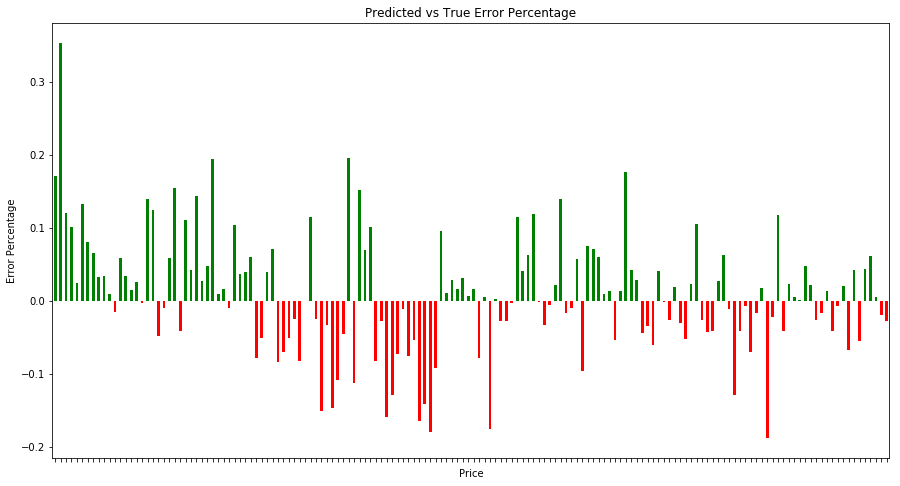

RMSE For These Parameters: 0.04502647193147251



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.439, 0.533]    5.0 -0.122625  0.055591 -0.179179 -0.164834 -0.140563   
(0.252, 0.345]    3.0 -0.070918  0.058862 -0.128571 -0.100918 -0.073265   
(1.563, 1.657]    1.0 -0.041542       NaN -0.041542 -0.041542 -0.041542   
(0.907, 1.001]    7.0 -0.036719  0.049099 -0.129042 -0.055149 -0.017139   
(1.001, 1.095]    4.0 -0.033302  0.124987 -0.187857 -0.078073 -0.031474   
(2.406, 2.5]      1.0 -0.027192       NaN -0.027192 -0.027192 -0.027192   
(1.844, 1.938]    3.0 -0.027013  0.060159 -0.067619 -0.061570 -0.055521   
(2.313, 2.406]    1.0 -0.018980       NaN -0.018980 -0.018980 -0.018980   
(1.47, 1.563]     3.0 -0.009735  0.020731 -0.025937 -0.021416 -0.016895   
(0.814, 0.907]   15.0 -0.002306  0.047562 -0.060236 -0.037626 -0.025585   
(2.125, 2.219] 

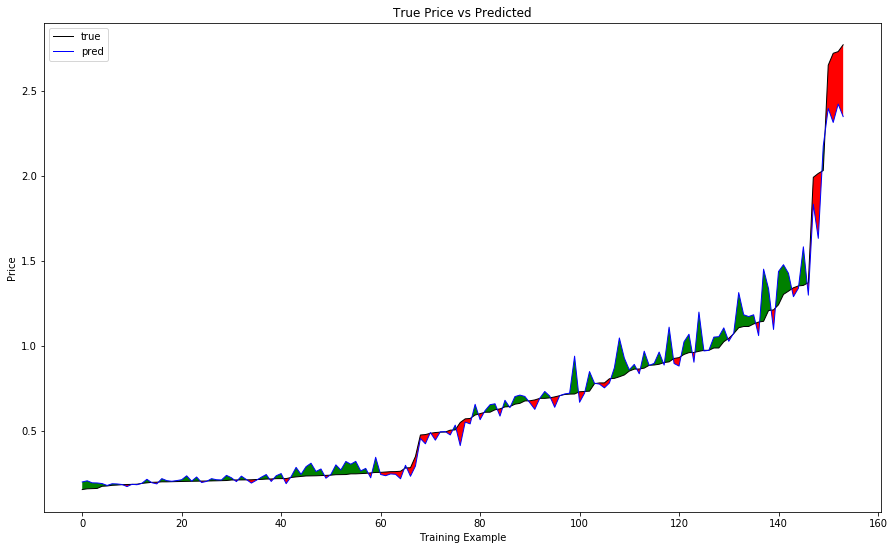

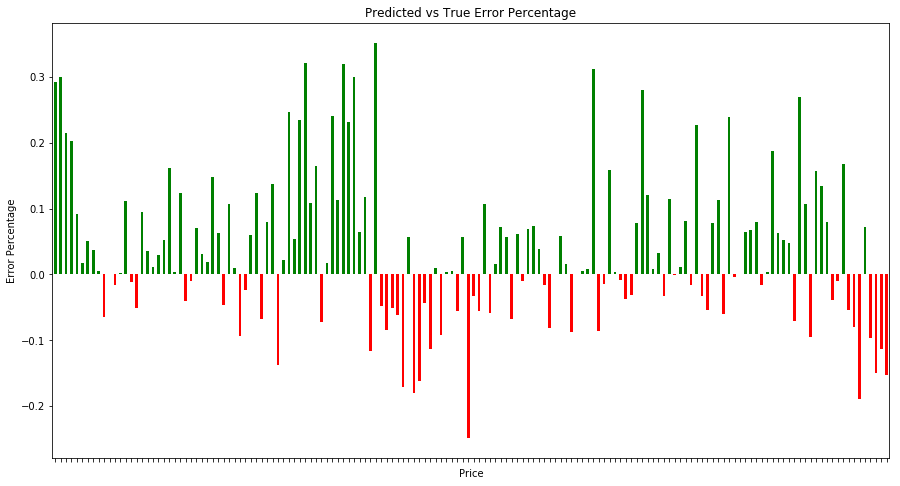

RMSE For These Parameters: 0.09622766967326922



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.665, 2.77]     3.0 -0.138434  0.021997 -0.152524 -0.151107 -0.149691   
(2.561, 2.665]    1.0 -0.096000       NaN -0.096000 -0.096000 -0.096000   
(0.257, 0.362]    6.0 -0.094673  0.093408 -0.179484 -0.168435 -0.112122   
(1.932, 2.037]    3.0 -0.065987  0.131085 -0.189820 -0.134635 -0.079450   
(0.467, 0.571]   11.0 -0.051748  0.081407 -0.248525 -0.073982 -0.043099   
(0.676, 0.781]   15.0  0.016377  0.101782 -0.087841 -0.025710  0.001131   
(0.99, 1.095]     3.0  0.022246  0.050960 -0.016568 -0.006608  0.003352   
(0.571, 0.676]   12.0  0.028384  0.055818 -0.067754 -0.011432  0.047953   
(1.304, 1.409]    5.0  0.028913  0.093342 -0.053604 -0.039146 -0.010331   
(0.885, 0.99]    14.0  0.051093  0.093561 -0.059697 -0.013169  0.037985   
(0.781, 0.885] 

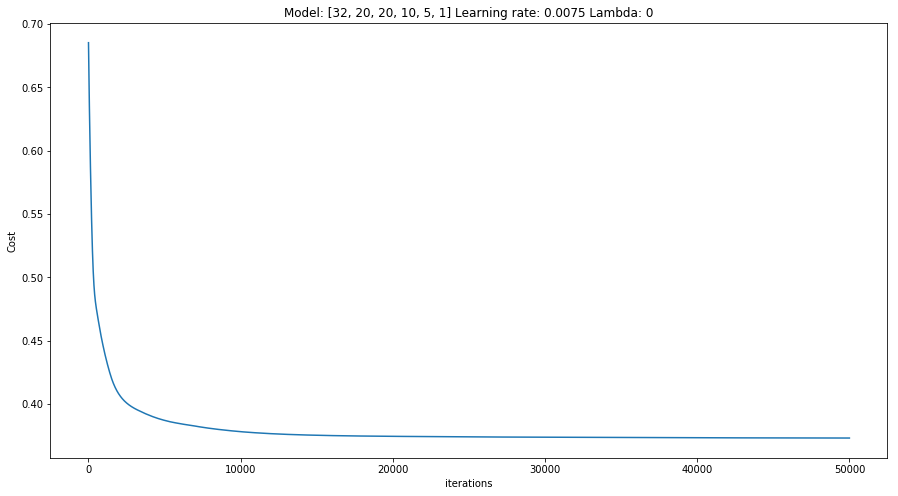






********************************************* Training Set Performance *********************************************


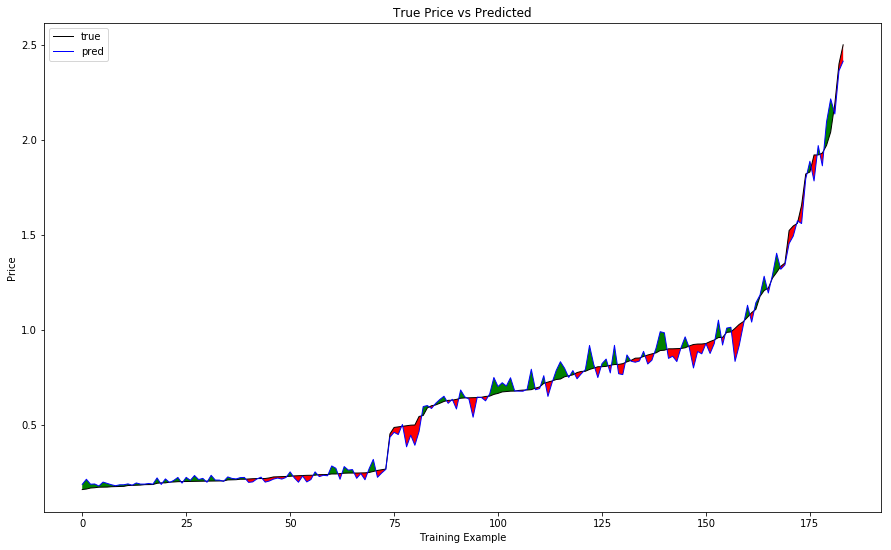

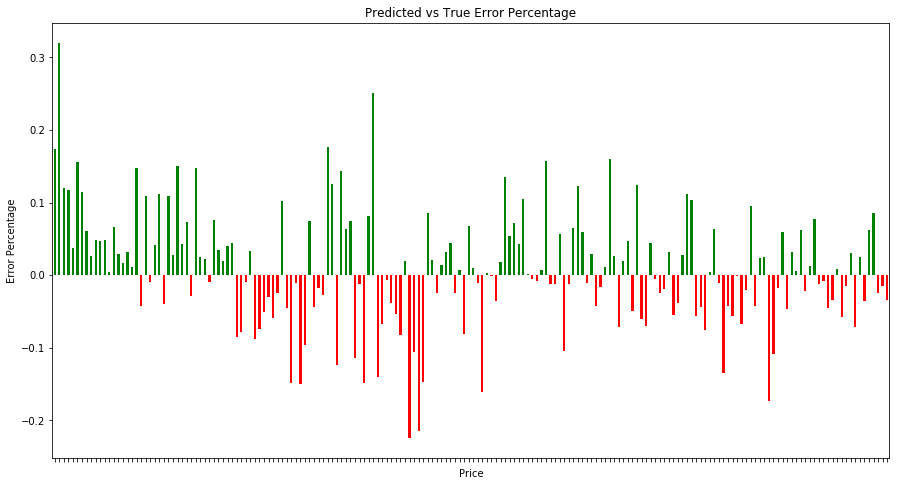

RMSE For These Parameters: 0.047797258368973285



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.439, 0.533]    7.0 -0.099836  0.090620 -0.224285 -0.160187 -0.082509   
(1.563, 1.657]    1.0 -0.058157       NaN -0.058157 -0.058157 -0.058157   
(1.001, 1.095]    5.0 -0.056952  0.088516 -0.173064 -0.108056 -0.046047   
(2.406, 2.5]      1.0 -0.034527       NaN -0.034527 -0.034527 -0.034527   
(1.844, 1.938]    3.0 -0.026834  0.049020 -0.071335 -0.053106 -0.034878   
(2.125, 2.219]    1.0 -0.024797       NaN -0.024797 -0.024797 -0.024797   
(1.47, 1.563]     3.0 -0.023776  0.028257 -0.045103 -0.039800 -0.034498   
(0.907, 1.001]   11.0 -0.020820  0.059331 -0.134063 -0.049188 -0.020352   
(2.313, 2.406]    1.0 -0.015316       NaN -0.015316 -0.015316 -0.015316   
(0.814, 0.907]   18.0  0.003443  0.064522 -0.075658 -0.051880 -0.012158   
(0.533, 0.626]

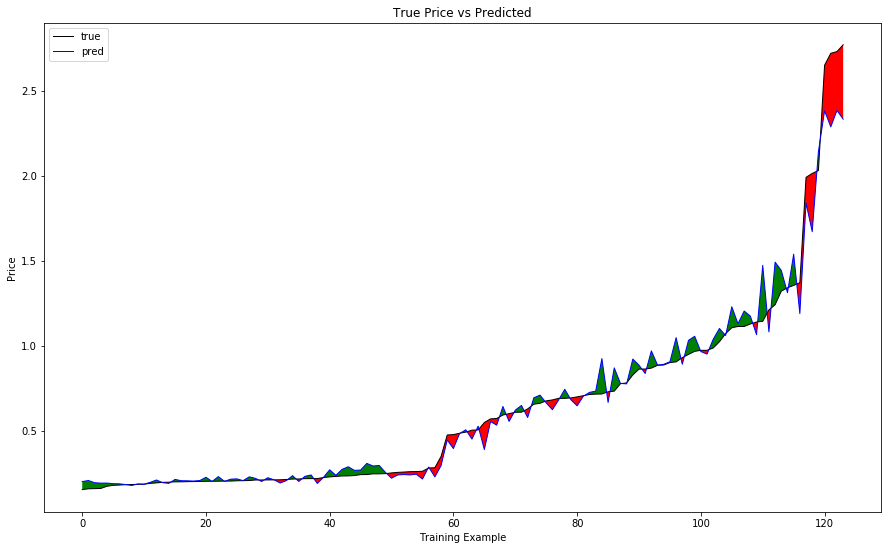

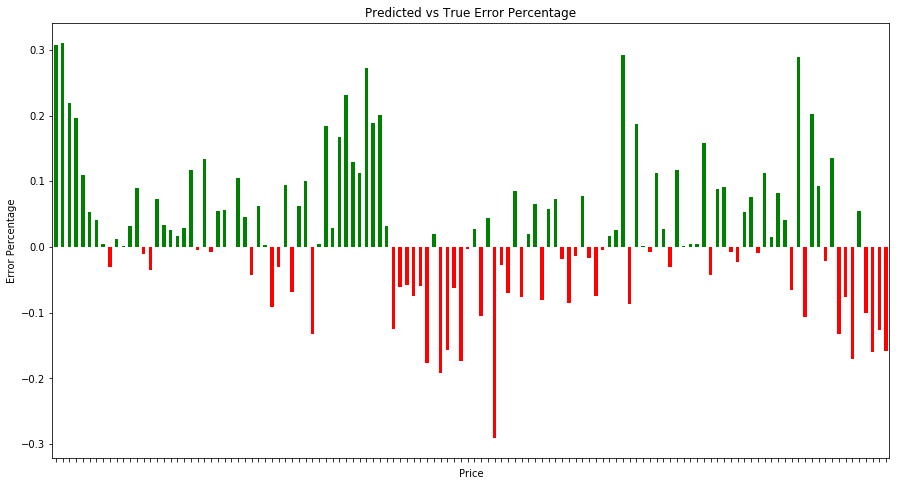

RMSE For These Parameters: 0.10078844167060658



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.665, 2.77]     3.0 -0.148025  0.018290 -0.159234 -0.158578 -0.157921   
(0.257, 0.362]    6.0 -0.106736  0.082430 -0.191753 -0.171992 -0.116015   
(2.561, 2.665]    1.0 -0.101231       NaN -0.101231 -0.101231 -0.101231   
(0.467, 0.571]    9.0 -0.073160  0.105791 -0.290916 -0.104539 -0.062152   
(1.932, 2.037]    3.0 -0.063874  0.113001 -0.170344 -0.123154 -0.075963   
(0.571, 0.676]    8.0  0.015935  0.067001 -0.081050 -0.032526  0.039122   
(1.304, 1.409]    4.0  0.018479  0.120803 -0.132817 -0.049518  0.035460   
(0.676, 0.781]   13.0  0.024025  0.108250 -0.086361 -0.016340 -0.004660   
(0.99, 1.095]     2.0  0.033244  0.061126 -0.009978  0.011633  0.033244   
(0.885, 0.99]     9.0  0.036331  0.065442 -0.042058 -0.007354  0.005156   
(0.781, 0.885] 

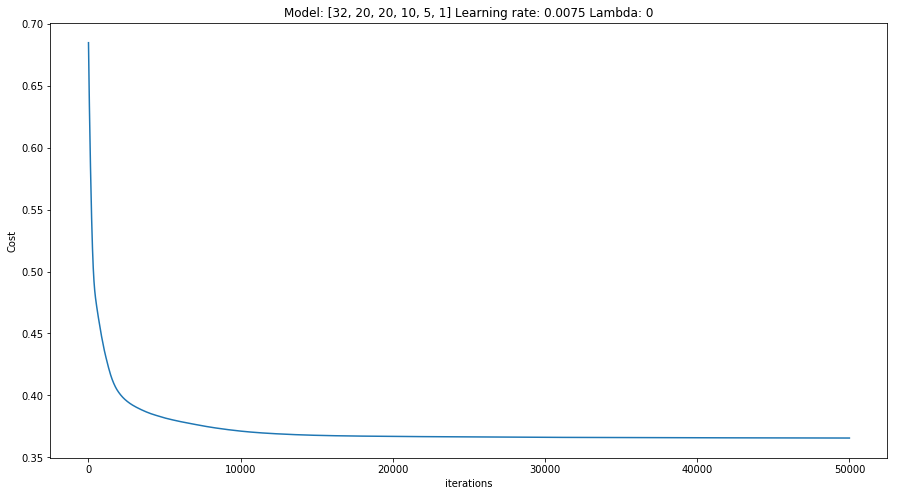






********************************************* Training Set Performance *********************************************


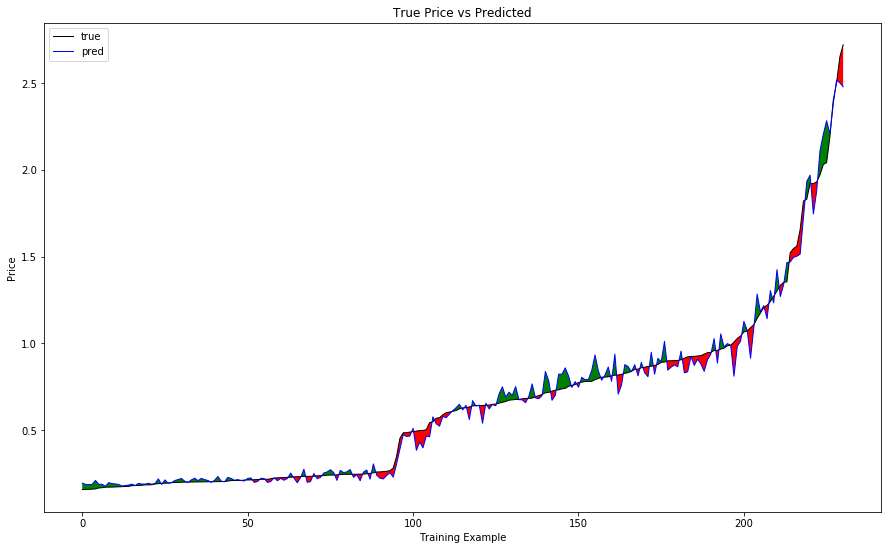

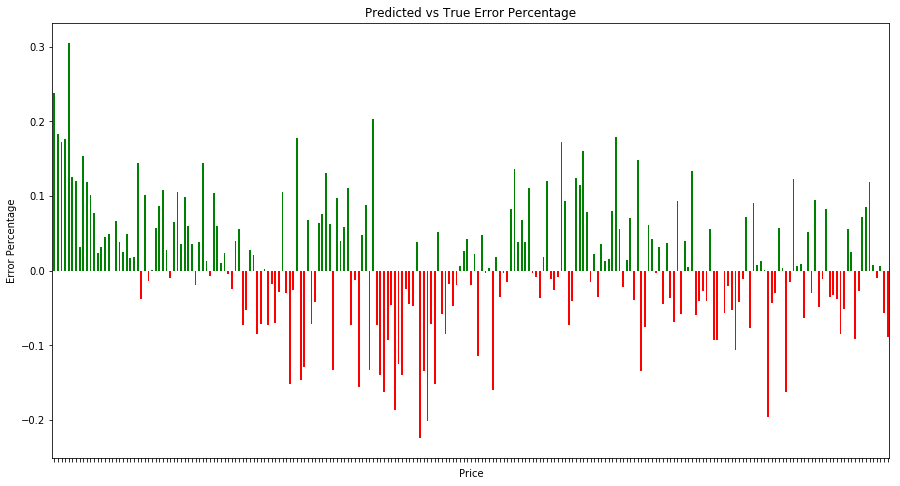

RMSE For These Parameters: 0.05749215085488903



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.362, 0.465]    1.0 -0.139152       NaN -0.139152 -0.139152 -0.139152   
(0.26, 0.362]     5.0 -0.122593  0.056223 -0.187136 -0.163045 -0.124574   
(1.592, 1.695]    1.0 -0.085429       NaN -0.085429 -0.085429 -0.085429   
(0.465, 0.567]   10.0 -0.080893  0.094558 -0.224299 -0.146988 -0.059582   
(2.617, 2.72]     2.0 -0.072682  0.023180 -0.089073 -0.080878 -0.072682   
(1.49, 1.592]     3.0 -0.035128  0.002348 -0.037511 -0.036283 -0.035054   
(0.977, 1.08]     7.0 -0.027880  0.080694 -0.195668 -0.036713  0.000929   
(0.875, 0.977]   21.0 -0.015078  0.063873 -0.105749 -0.056348 -0.027683   
(1.08, 1.182]     4.0 -0.011843  0.117145 -0.161950 -0.051480 -0.004466   
(2.31, 2.412]     1.0 -0.009643       NaN -0.009643 -0.009643 -0.009643   
(1.182, 1.285] 

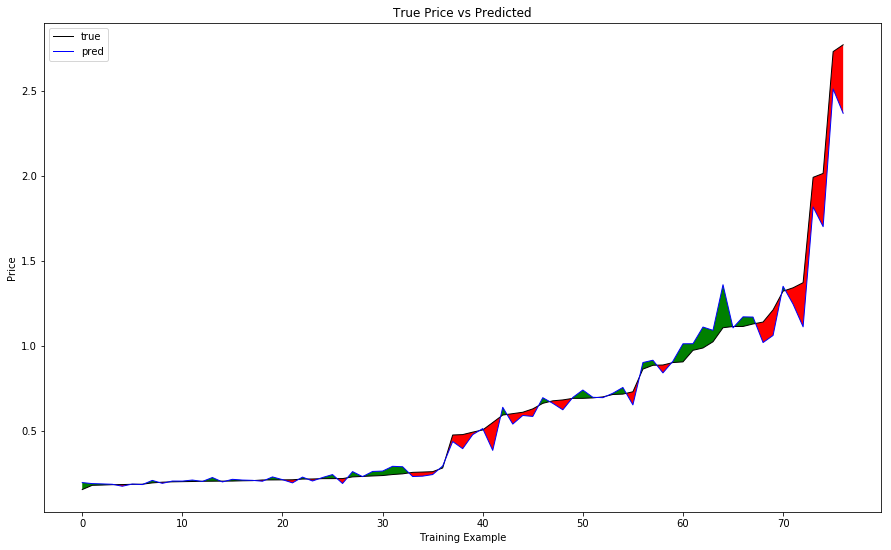

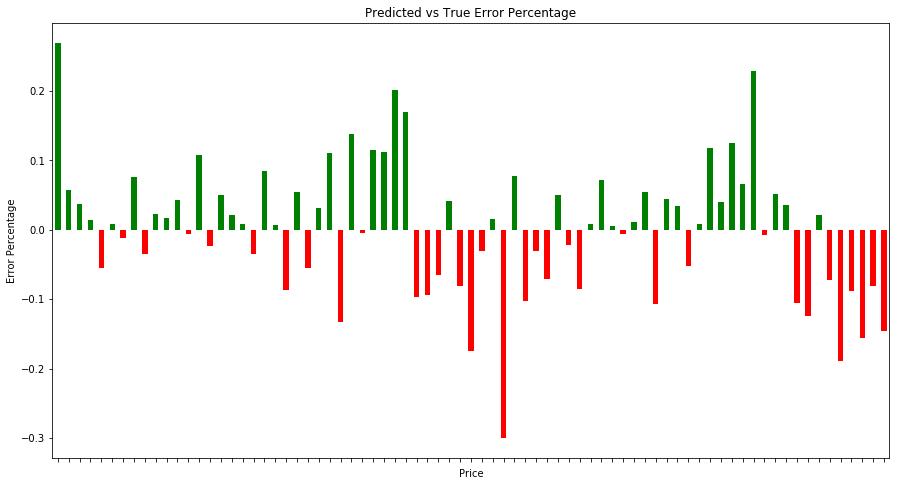

RMSE For These Parameters: 0.09062616575866435



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(1.2, 1.304]      1.0 -0.124368       NaN -0.124368 -0.124368 -0.124368   
(1.932, 2.037]    2.0 -0.121581  0.048118 -0.155606 -0.138594 -0.121581   
(0.467, 0.571]    5.0 -0.113893  0.125614 -0.299883 -0.174035 -0.081119   
(2.665, 2.77]     2.0 -0.113105  0.045859 -0.145533 -0.129319 -0.113105   
(1.304, 1.409]    3.0 -0.079966  0.105945 -0.189580 -0.130890 -0.072200   
(0.571, 0.676]    6.0 -0.016471  0.069094 -0.102507 -0.060883 -0.026601   
(0.257, 0.362]    2.0 -0.012301  0.075730 -0.065850 -0.039076 -0.012301   
(0.676, 0.781]    8.0 -0.006071  0.061663 -0.106353 -0.026232  0.006603   
(0.15, 0.257]    35.0  0.031852  0.086598 -0.133245 -0.017811  0.021142   
(0.781, 0.885]    2.0  0.039248  0.007861  0.033689  0.036468  0.039248   
(1.095, 1.2]   

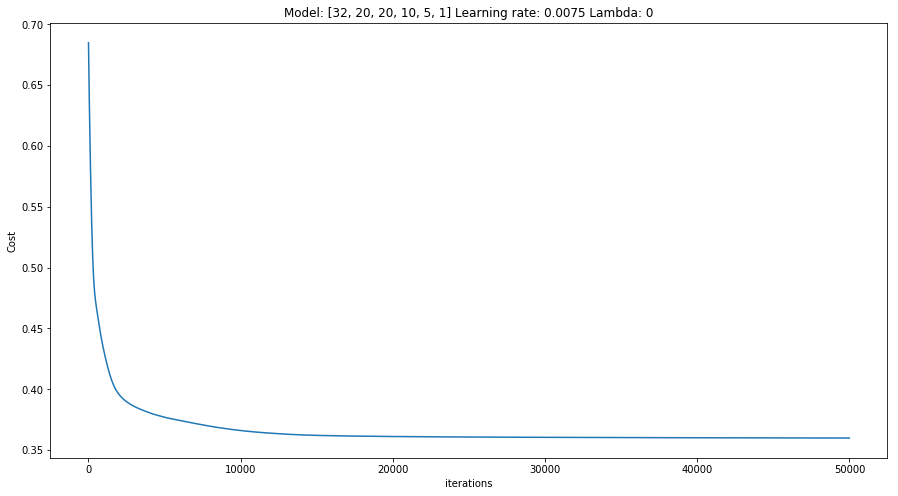






********************************************* Training Set Performance *********************************************


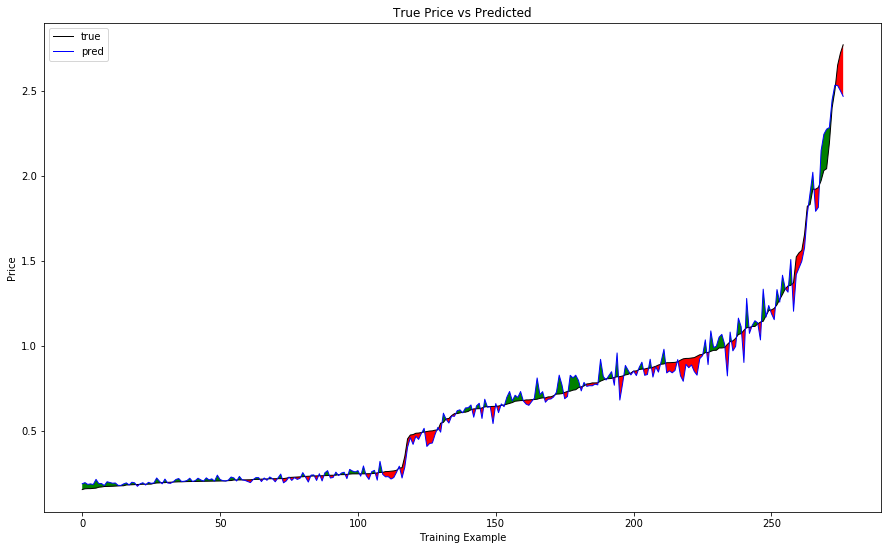

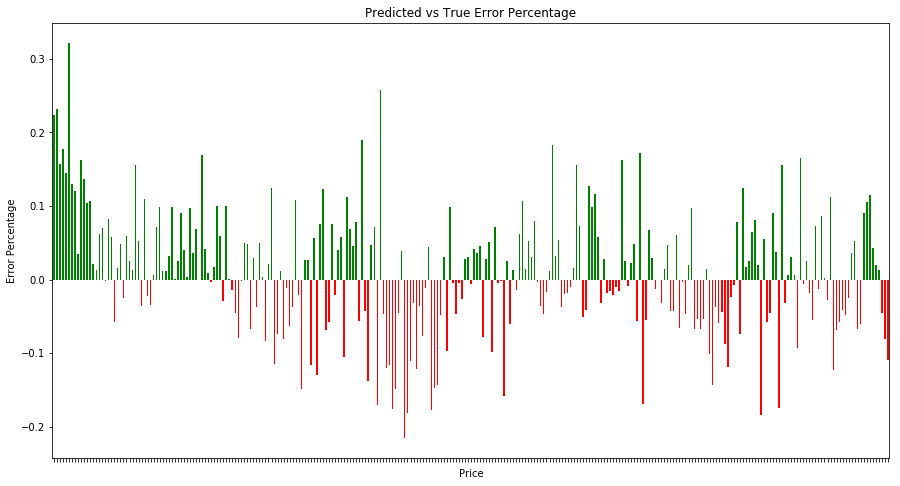

RMSE For These Parameters: 0.05994845429944895



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.257, 0.362]    8.0 -0.120454  0.082485 -0.215385 -0.177282 -0.134277   
(0.362, 0.467]    1.0 -0.111050       NaN -0.111050 -0.111050 -0.111050   
(2.665, 2.77]     2.0 -0.095301  0.020179 -0.109570 -0.102436 -0.095301   
(1.514, 1.618]    3.0 -0.055817  0.014015 -0.068640 -0.063297 -0.057955   
(0.467, 0.571]   15.0 -0.051572  0.077430 -0.177494 -0.109227 -0.047463   
(1.618, 1.723]    1.0 -0.047622       NaN -0.047622 -0.047622 -0.047622   
(2.561, 2.665]    1.0 -0.045298       NaN -0.045298 -0.045298 -0.045298   
(0.99, 1.095]     7.0 -0.039606  0.109034 -0.184416 -0.115688 -0.045254   
(1.723, 1.828]    1.0 -0.024972       NaN -0.024972 -0.024972 -0.024972   
(0.885, 0.99]    25.0 -0.017752  0.070267 -0.143482 -0.066934 -0.037349   
(1.828, 1.932] 

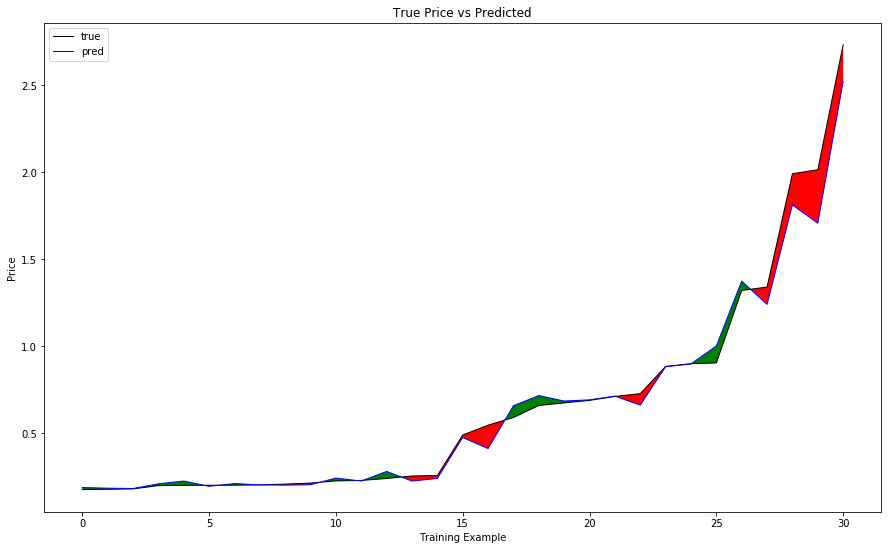

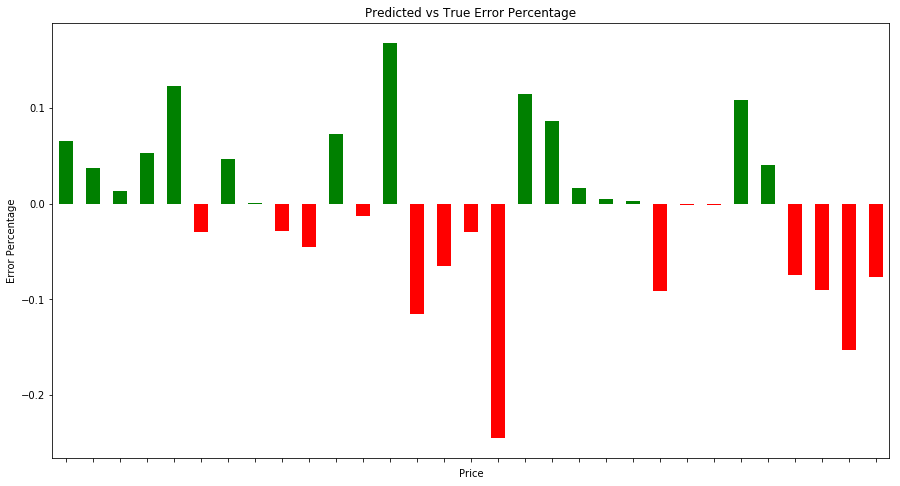

RMSE For These Parameters: 0.08571733570588325



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.484, 0.586]    2.0 -0.137198  0.152526 -0.245050 -0.191124 -0.137198   
(1.913, 2.015]    2.0 -0.121292  0.044329 -0.152637 -0.136965 -0.121292   
(2.628, 2.73]     1.0 -0.077076       NaN -0.077076 -0.077076 -0.077076   
(0.688, 0.79]     3.0 -0.027944  0.054497 -0.090858 -0.044235  0.002388   
(1.301, 1.403]    2.0 -0.016921  0.081390 -0.074472 -0.045697 -0.016921   
(0.79, 0.892]     1.0 -0.001313       NaN -0.001313 -0.001313 -0.001313   
(0.175, 0.28]    15.0  0.018789  0.073462 -0.115044 -0.029507  0.013296   
(0.892, 0.994]    2.0  0.053027  0.077457 -0.001743  0.025642  0.053027   
(0.586, 0.688]    3.0  0.072207  0.050558  0.016135  0.051154  0.086173   
(0.28, 0.382]     0.0       NaN       NaN       NaN       NaN       NaN   
(0.382, 0.484] 

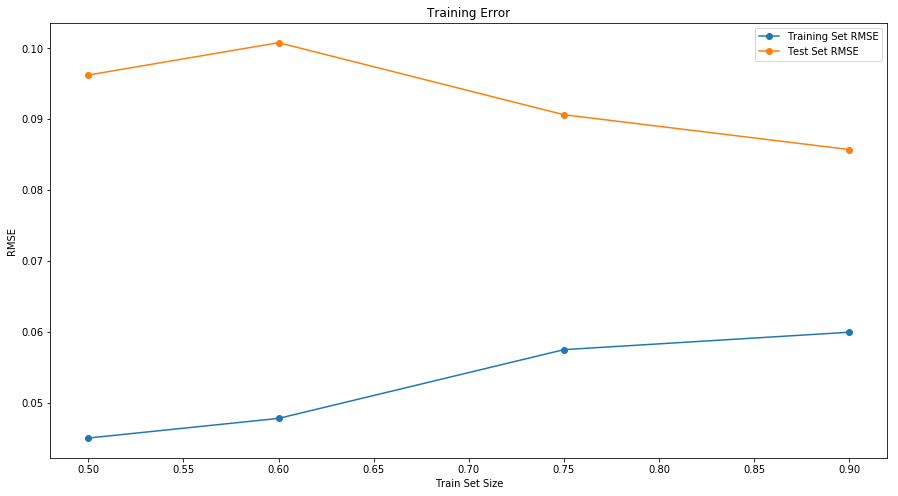

In [40]:
parameters, df = regression_model(X,Y, [32,20,20,10,5,1], 0.0075, 0, 50000, yscaler)

So adding more training data didn't greatly improve our model, but at least it should show some improvement to new data with the added observations. However, the prediction from these models are only for next day prices. A day trader might be interested in day to day prices, but most investors are interested in the long term. Let's train a model to predict prices well in the future. Let's try predicting 30 day prices

### FUTURE PRICE PREDICTION

In [41]:
#Create new independent and dependent variables where the dependent variable is XRP Price 
#30 days in the future of each observation
X,Y,xscaler,yscaler = make_xy(df2, one_hots = False, future_price = 30)


-------------------------- TRAINING MODEL WITH 140 (50.0%) TRAINING SAMPLES --------------------------


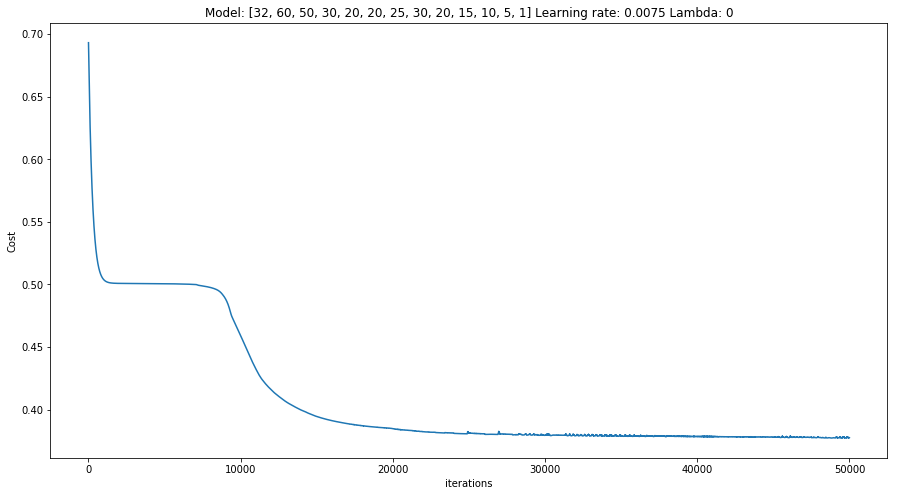






********************************************* Training Set Performance *********************************************


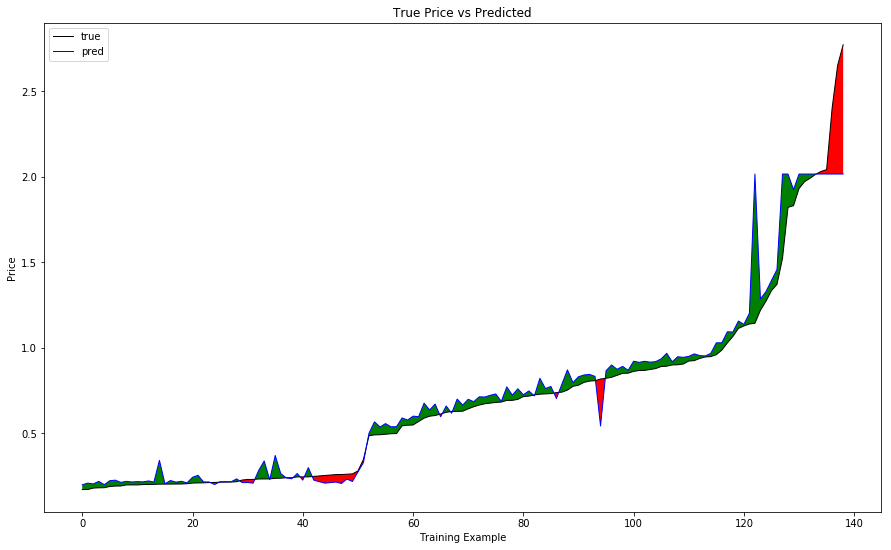

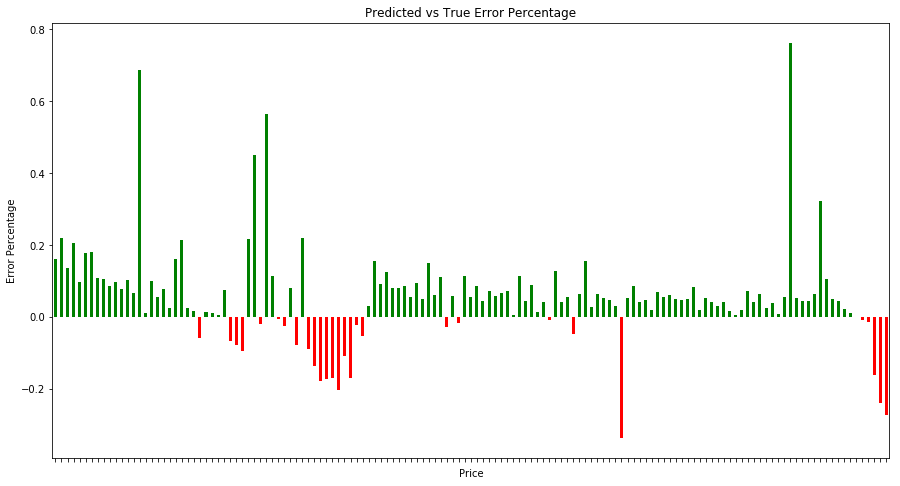

RMSE For These Parameters: 0.13462775083649126



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.666, 2.77]     1.0 -0.272641       NaN -0.272641 -0.272641 -0.272641   
(2.562, 2.666]    1.0 -0.239704       NaN -0.239704 -0.239704 -0.239704   
(2.354, 2.458]    1.0 -0.160506       NaN -0.160506 -0.160506 -0.160506   
(0.275, 0.379]    2.0 -0.038427  0.021758 -0.053812 -0.046119 -0.038427   
(1.938, 2.042]    5.0  0.003190  0.014469 -0.012627 -0.007495  0.000886   
(0.795, 0.899]   16.0  0.029086  0.098881 -0.336238  0.045243  0.049662   
(0.899, 1.003]   10.0  0.034769  0.019656  0.006105  0.020263  0.036281   
(1.834, 1.938]    1.0  0.043930       NaN  0.043930  0.043930  0.043930   
(1.003, 1.107]    2.0  0.044050  0.027626  0.024516  0.034283  0.044050   
(1.21, 1.314]     2.0  0.049238  0.007068  0.044240  0.046739  0.049238   
(1.314, 1.418] 

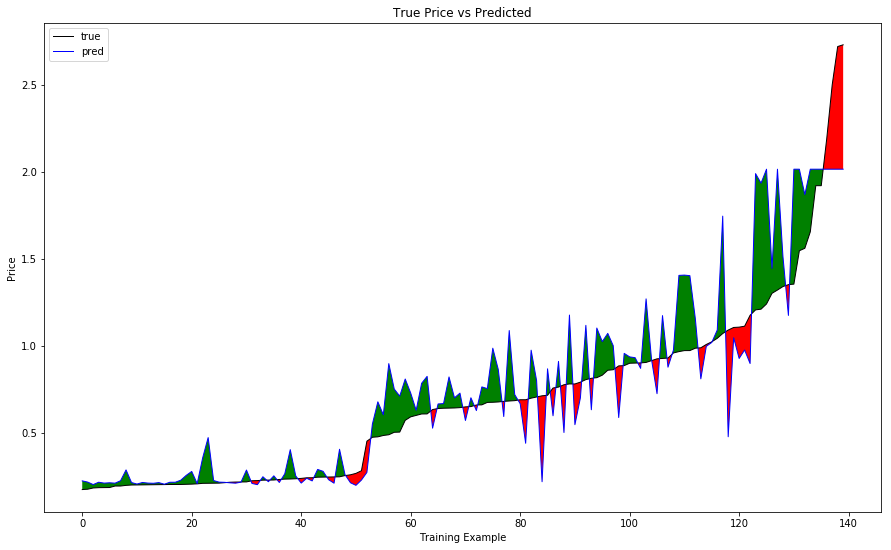

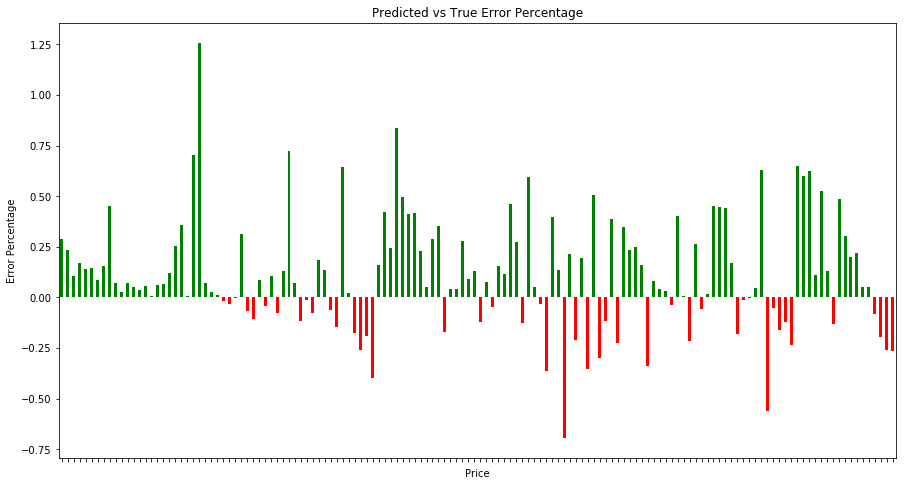

RMSE For These Parameters: 0.24747888305879573



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.628, 2.73]     2.0 -0.260627  0.001919 -0.261984 -0.261305 -0.260627   
(2.423, 2.525]    1.0 -0.194086       NaN -0.194086 -0.194086 -0.194086   
(0.275, 0.377]    1.0 -0.190642       NaN -0.190642 -0.190642 -0.190642   
(1.093, 1.196]    4.0 -0.143903  0.076249 -0.236101 -0.181151 -0.142936   
(2.116, 2.219]    1.0 -0.080007       NaN -0.080007 -0.080007 -0.080007   
(0.684, 0.787]   11.0 -0.046508  0.369557 -0.693992 -0.327171 -0.033150   
(0.991, 1.093]    5.0  0.019877  0.422788 -0.562883 -0.010622 -0.003595   
(1.912, 2.014]    2.0  0.049367  0.000000  0.049367  0.049367  0.049367   
(0.377, 0.48]     3.0  0.061337  0.419348 -0.398184 -0.119656  0.158872   
(0.787, 0.889]    9.0  0.087018  0.256630 -0.335967 -0.114357  0.160237   
(0.17, 0.275]  

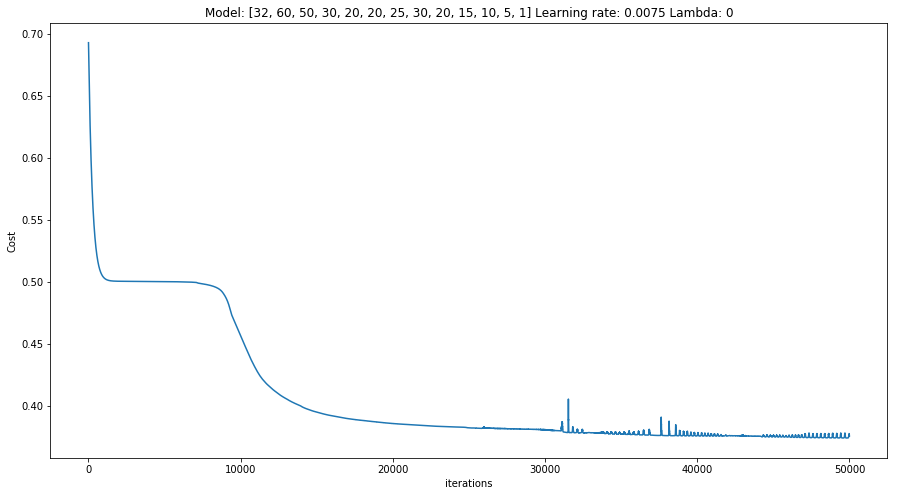






********************************************* Training Set Performance *********************************************


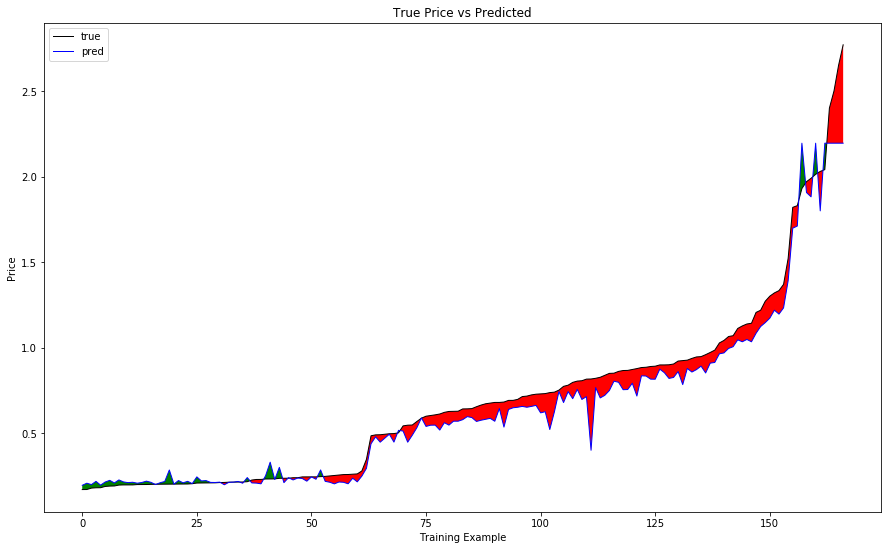

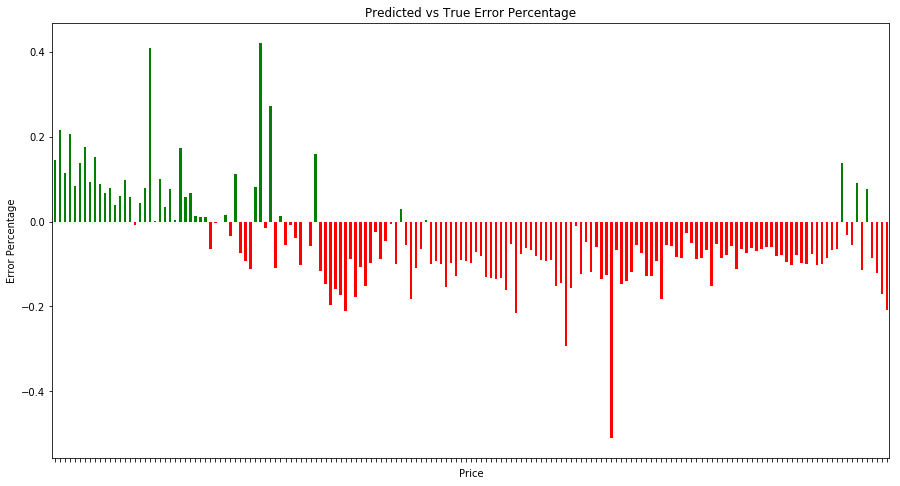

RMSE For These Parameters: 0.10329499269952744



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.666, 2.77]     1.0 -0.207589       NaN -0.207589 -0.207589 -0.207589   
(2.562, 2.666]    1.0 -0.171706       NaN -0.171706 -0.171706 -0.171706   
(0.275, 0.379]    2.0 -0.129651  0.030476 -0.151201 -0.140426 -0.129651   
(0.795, 0.899]   19.0 -0.124394  0.100378 -0.509900 -0.132458 -0.118102   
(2.458, 2.562]    1.0 -0.122008       NaN -0.122008 -0.122008 -0.122008   
(0.587, 0.691]   19.0 -0.108555  0.045762 -0.214410 -0.132589 -0.098927   
(0.691, 0.795]   14.0 -0.106136  0.067547 -0.292674 -0.139141 -0.090371   
(1.314, 1.418]    3.0 -0.093279  0.014622 -0.103058 -0.101683 -0.100309   
(1.21, 1.314]     3.0 -0.091798  0.011886 -0.098998 -0.098657 -0.098317   
(1.418, 1.522]    1.0 -0.085907       NaN -0.085907 -0.085907 -0.085907   
(2.354, 2.458] 

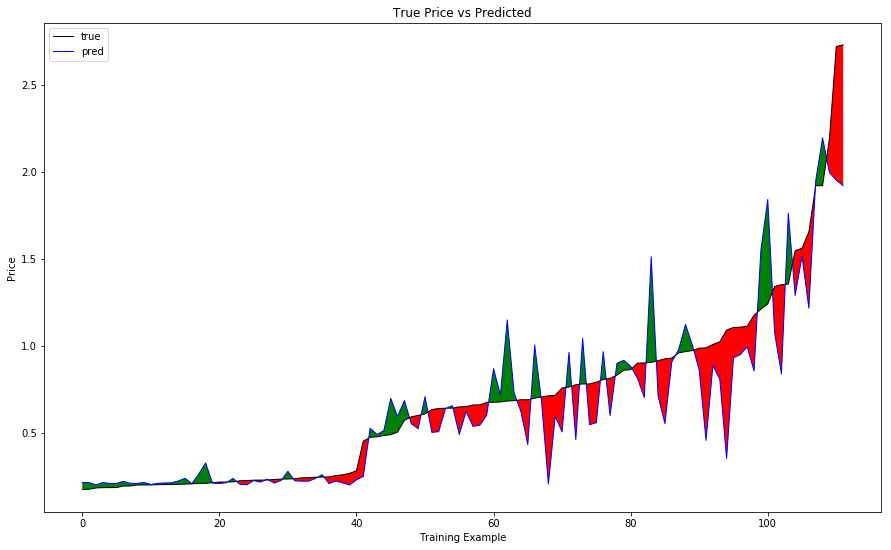

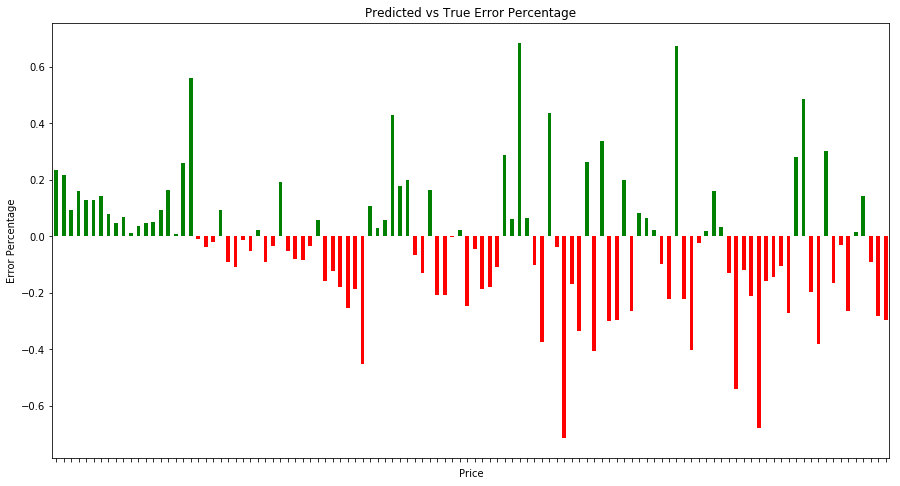

RMSE For These Parameters: 0.22605926964747822



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(0.991, 1.093]    3.0 -0.336329  0.299349 -0.678076 -0.444219 -0.210361   
(2.628, 2.73]     2.0 -0.289644  0.010149 -0.296821 -0.293232 -0.289644   
(1.605, 1.707]    1.0 -0.265285       NaN -0.265285 -0.265285 -0.265285   
(0.275, 0.377]    1.0 -0.185846       NaN -0.185846 -0.185846 -0.185846   
(1.093, 1.196]    4.0 -0.169846  0.071636 -0.272300 -0.186548 -0.150312   
(0.684, 0.787]   11.0 -0.127158  0.353822 -0.713293 -0.354025 -0.169515   
(0.377, 0.48]     3.0 -0.104162  0.302749 -0.450737 -0.210624  0.029489   
(1.503, 1.605]    2.0 -0.097919  0.096504 -0.166158 -0.132038 -0.097919   
(1.298, 1.4]      3.0 -0.092489  0.352591 -0.379931 -0.289203 -0.198476   
(2.116, 2.219]    1.0 -0.088905       NaN -0.088905 -0.088905 -0.088905   
(0.889, 0.991] 

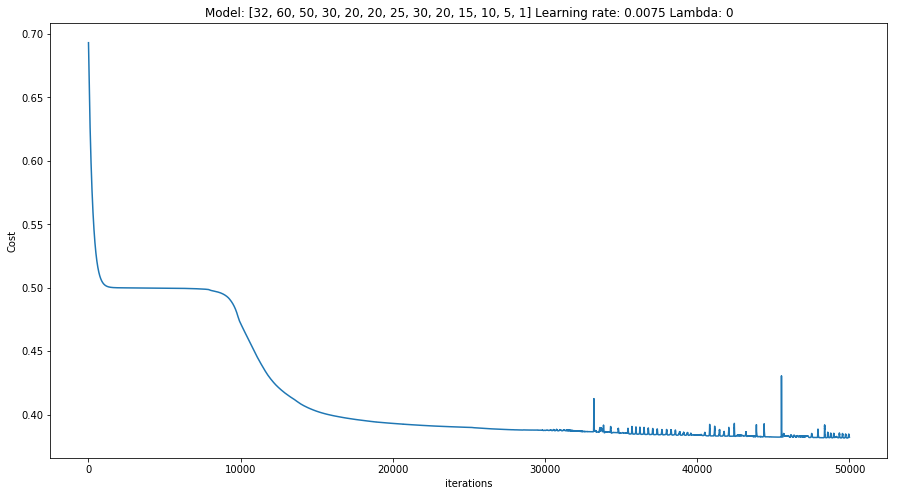






********************************************* Training Set Performance *********************************************


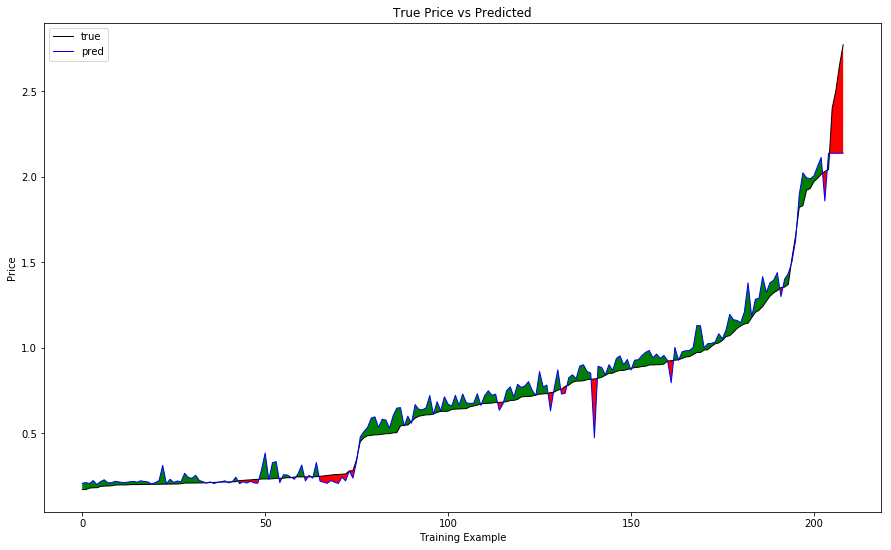

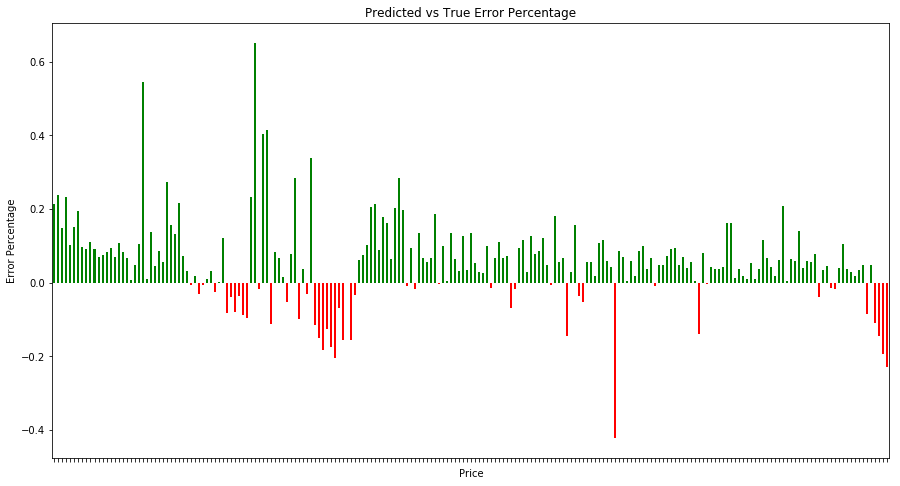

RMSE For These Parameters: 0.09214424340820322



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.666, 2.77]     1.0 -0.228838       NaN -0.228838 -0.228838 -0.228838   
(2.562, 2.666]    1.0 -0.193918       NaN -0.193918 -0.193918 -0.193918   
(2.458, 2.562]    1.0 -0.145553       NaN -0.145553 -0.145553 -0.145553   
(2.354, 2.458]    1.0 -0.109951       NaN -0.109951 -0.109951 -0.109951   
(0.275, 0.379]    3.0 -0.062311  0.081562 -0.154544 -0.093616 -0.032688   
(1.626, 1.73]     1.0 -0.016950       NaN -0.016950 -0.016950 -0.016950   
(1.418, 1.522]    1.0 -0.013486       NaN -0.013486 -0.013486 -0.013486   
(1.938, 2.042]    5.0  0.012524  0.056019 -0.085076  0.017010  0.034831   
(1.834, 1.938]    2.0  0.033663  0.005730  0.029611  0.031637  0.033663   
(1.314, 1.418]    5.0  0.035329  0.044590 -0.038852  0.034308  0.046145   
(0.795, 0.899] 

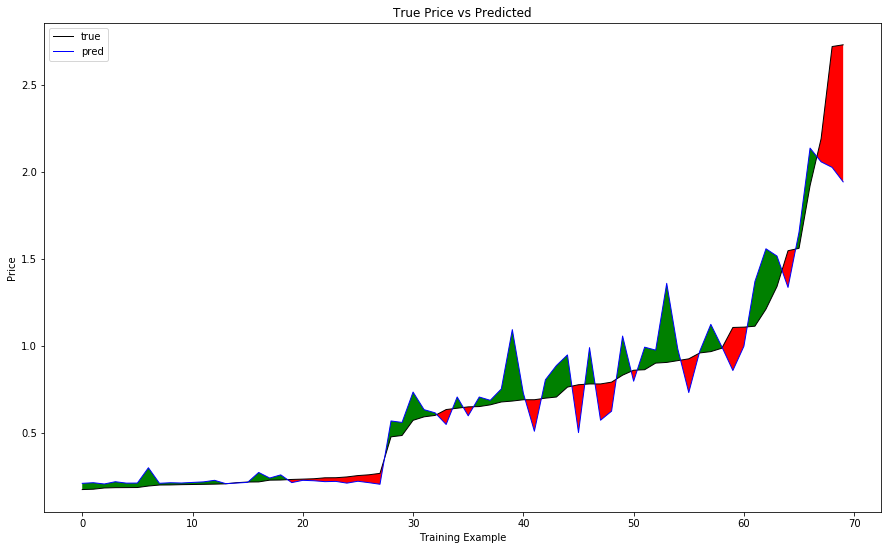

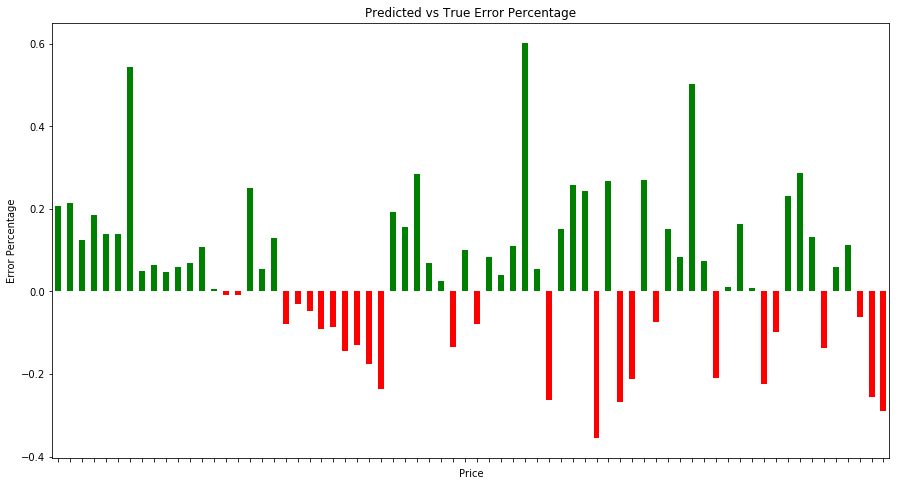

RMSE For These Parameters: 0.18638795407983894



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.628, 2.73]     2.0 -0.272047  0.023510 -0.288671 -0.280359 -0.272047   
(2.116, 2.219]    1.0 -0.060676       NaN -0.060676 -0.060676 -0.060676   
(1.503, 1.605]    2.0 -0.038235  0.138860 -0.136424 -0.087330 -0.038235   
(1.093, 1.196]    3.0 -0.030663  0.235308 -0.224012 -0.161663 -0.099313   
(0.684, 0.787]    8.0  0.011079  0.264021 -0.354906 -0.263830  0.103051   
(0.787, 0.889]    4.0  0.034223  0.216939 -0.211073 -0.107725  0.038613   
(0.17, 0.275]    28.0  0.048305  0.157345 -0.235460 -0.055848  0.051590   
(0.889, 0.991]    7.0  0.090235  0.215581 -0.209795  0.009625  0.074243   
(0.582, 0.684]    9.0  0.090778  0.209133 -0.135556  0.024537  0.069557   
(1.912, 2.014]    1.0  0.112561       NaN  0.112561  0.112561  0.112561   
(1.298, 1.4]   

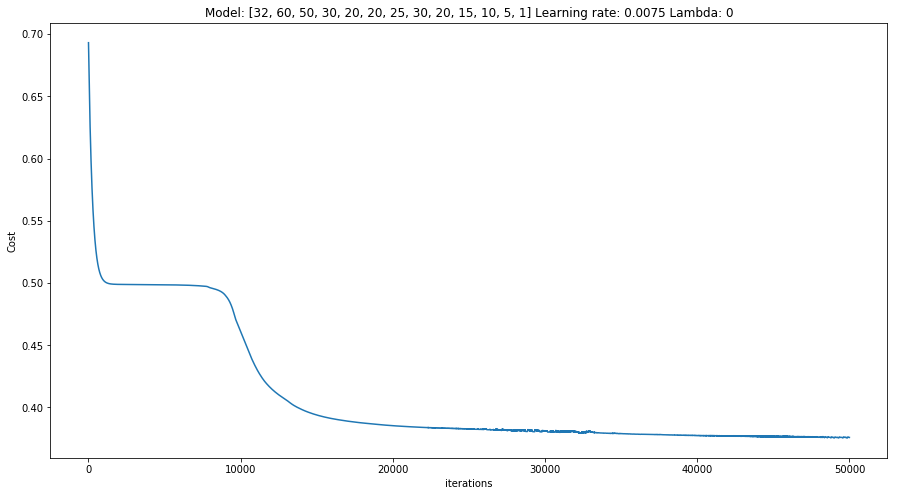






********************************************* Training Set Performance *********************************************


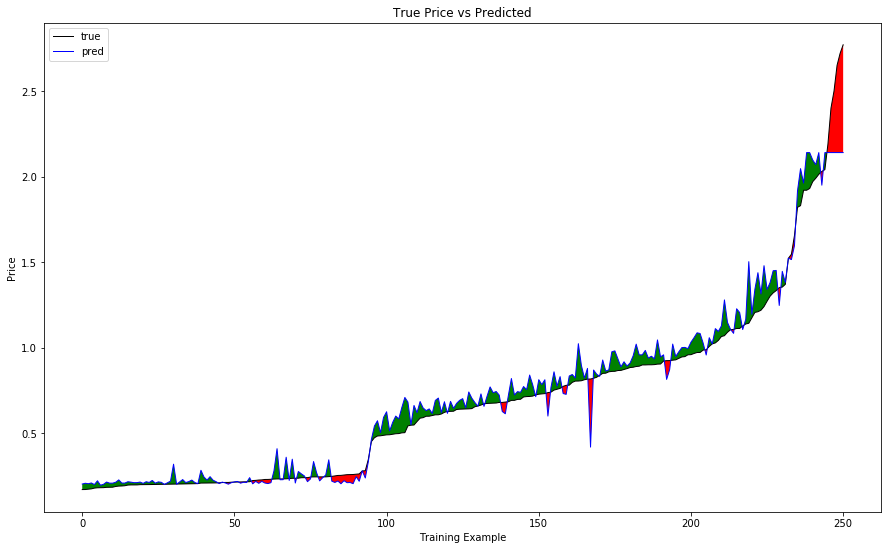

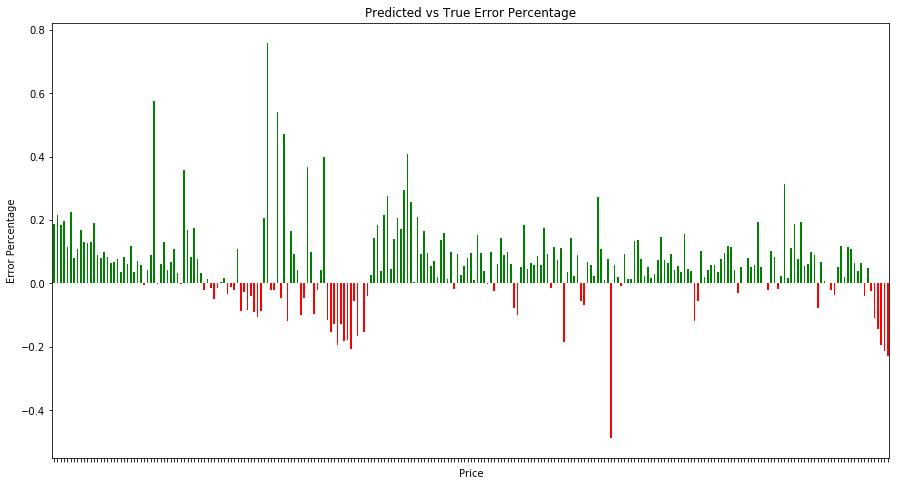

RMSE For These Parameters: 0.10440489797376863



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.666, 2.77]     2.0 -0.220307  0.010042 -0.227408 -0.223857 -0.220307   
(2.562, 2.666]    1.0 -0.192423       NaN -0.192423 -0.192423 -0.192423   
(2.458, 2.562]    1.0 -0.143968       NaN -0.143968 -0.143968 -0.143968   
(2.354, 2.458]    1.0 -0.108300       NaN -0.108300 -0.108300 -0.108300   
(0.275, 0.379]    3.0 -0.062643  0.080287 -0.152153 -0.095475 -0.038796   
(1.626, 1.73]     1.0 -0.036017       NaN -0.036017 -0.036017 -0.036017   
(2.146, 2.25]     1.0 -0.022795       NaN -0.022795 -0.022795 -0.022795   
(1.522, 1.626]    1.0 -0.020196       NaN -0.020196 -0.020196 -0.020196   
(1.418, 1.522]    1.0  0.000756       NaN  0.000756  0.000756  0.000756   
(1.938, 2.042]    5.0  0.035400  0.043145 -0.039639  0.040292  0.048776   
(1.314, 1.418] 

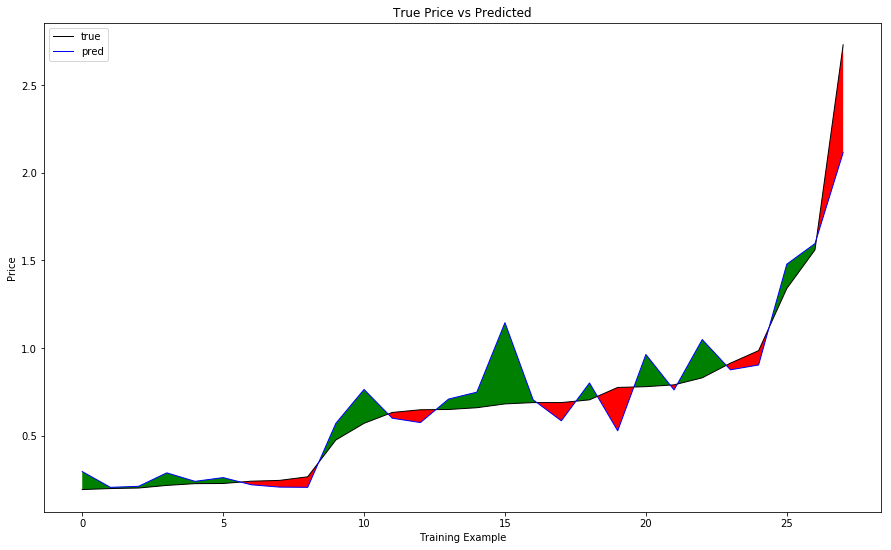

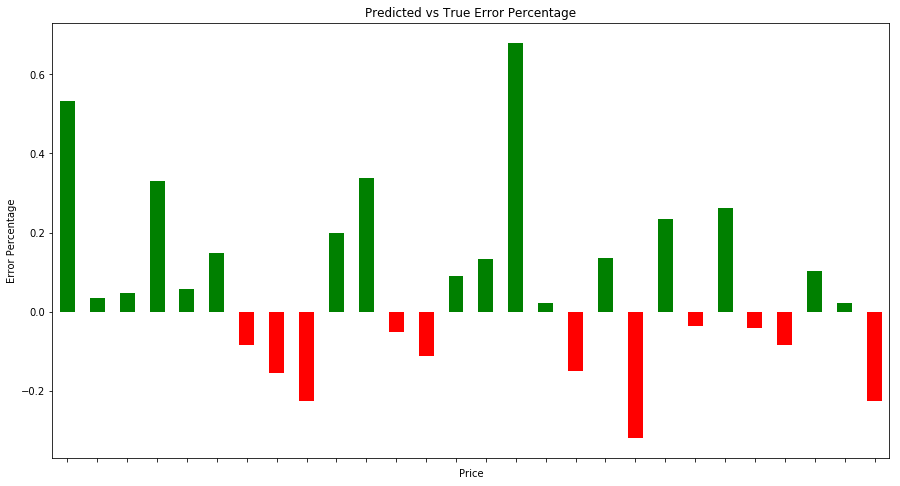

RMSE For These Parameters: 0.17651326902832976



Error Statistics By Price Ranges


                count      mean       std       min       25%       50%  \
bins                                                                      
(2.629, 2.73]     1.0 -0.225320       NaN -0.225320 -0.225320 -0.225320   
(0.904, 1.005]    2.0 -0.062285  0.029256 -0.082972 -0.072628 -0.062285   
(0.701, 0.802]    4.0  0.004056  0.243042 -0.319145 -0.107304  0.050022   
(1.512, 1.614]    1.0  0.023093       NaN  0.023093  0.023093  0.023093   
(0.191, 0.295]    9.0  0.075795  0.237466 -0.226469 -0.085012  0.048507   
(0.599, 0.701]    7.0  0.087623  0.280881 -0.150933 -0.082198  0.023197   
(1.309, 1.411]    1.0  0.103504       NaN  0.103504  0.103504  0.103504   
(0.396, 0.498]    1.0  0.199971       NaN  0.199971  0.199971  0.199971   
(0.802, 0.904]    1.0  0.262784       NaN  0.262784  0.262784  0.262784   
(0.498, 0.599]    1.0  0.338273       NaN  0.338273  0.338273  0.338273   
(0.295, 0.396] 

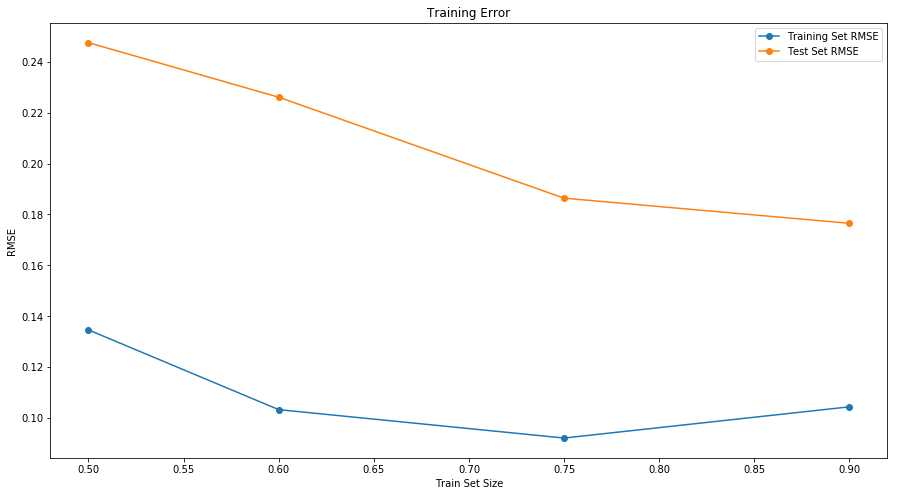

In [42]:
parameters, df = regression_model(X,Y, [32,60,50,30,20,20,25,30,20,15,10,5,1], 0.0075, 0, 50000, yscaler)

Again,even though there is only one NN architectural structure shown above, I played around with several different architectures and hyperparameters to arrive at what seems to be the best performing model above. There are a couple of takeaways from these models. The first is that the RMSE is higher when predicting 30 day prices in comparison to next day prices. This is to be expected since there is a lot more randomness being introduced as time is increased. There's no way to completely account for randomness in a model. Next, there's a very distinct pattern in all the models with more than 60% training data. The model almost always over predicts at the lower price points. And right before the first price spike, it under predicts, right at the elbow. Once the price almost flattens out again after the first spike, the model begins to over predict again with intermittent "under predictions" along the way. These under predictions are almost always at the same spot in every model. And lastly, as the model tops out at the higher price predictions, it greatly under predicts at the end. This trend is happening in every model, and as such might be easy to compensate for. Lastly, when extending the timeline for predictions, we can now learn two things from this model. 
1. Predicted 30 day future price
2. General Price trend over 30 days (will the price go up or down in 30 days from today)

Let's explore the performance of item number 2. First, using the model trained with 90% training data, we need to extract what the original price was for each prediction

In [43]:
#Recreate the same X_train values used for the 90% model
X_train, X_test, y_train, y_test = train_test_split(X,Y, train_size = 0.9, test_size = 0.1, random_state = 42)
#create a copy of the performance dataframe from the last model training session
df4 = df.copy()

In [44]:
#Original Price for each predicted 30 day price
price = pd.DataFrame(xscaler.inverse_transform(X_train)).iloc[:,13:14]

In [45]:
df4['before_price'] = price
df4.head()

,true,pred,error,error_percentage,before_price
223,0.1708,0.203078,0.032278,0.188981,0.1580
233,0.1710,0.207680,0.036680,0.214505,0.2420
2,0.1729,0.204863,0.031963,0.184862,0.2460
4,0.1749,0.209378,0.034478,0.197128,0.2159
162,0.1793,0.200066,0.020766,0.115820,0.2171


In the dataframe above, we have the true 30 day price, the model's predicted 30 day price, the difference between the two prices (error), the error percentage, and the price 30 days before the predicted price (original price). Note that the indices are unsorted due to the train_test_split function randomizing the input/ouput data for the model. Next we will calculate the price change between the original price and the 30 day price

In [46]:
df4['change_true'] = df4.true - df4.before_price
df4['change_pred'] = df4.pred - df4.before_price
df4 = df4.sort_values('change_true').reset_index().drop('index',axis = 1)
df4['change_true_percentage'] = df4.change_true / df4.before_price
df4['change_pred_percentage'] = df4.change_pred / df4.before_price

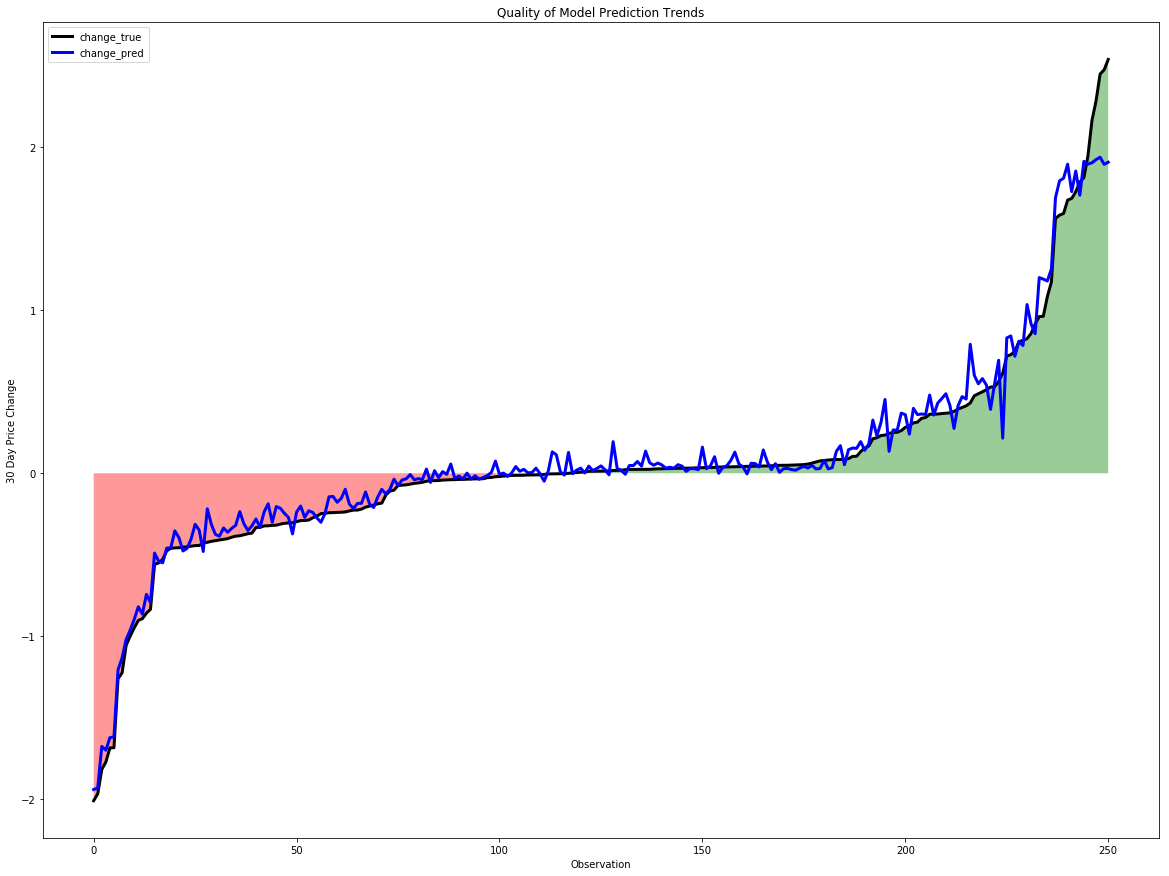

In [47]:
ax = df4[['change_true','change_pred']].plot(figsize = (20,15), color = ['k', 'b'], lw = 3)
ax.fill_between(df4.index, np.zeros(len(df4)), df4.change_true, where = (df4.change_true < 0), facecolor = 'r', alpha = 0.4)
ax.fill_between(df4.index, np.zeros(len(df4)), df4.change_true, where = (df4.change_true > 0), facecolor = 'g', alpha = 0.4)
ax.set_xlabel('Observation')
ax.set_ylabel('30 Day Price Change')
ax.set_title('Quality of Model Prediction Trends')
plt.show()


In the above graph, we can see that when the true price has dropped in 30 days from the original price, the model almost always also predicts a drop in price as well. Remember we aren't measuring the accuracy of the price prediction, but that it at least shows the correct trend. Conversely, the model almost always shows a positive 30 day trend when the true price has increased in 30 days from the original price. With that being said, towards the middle where price change is minimal in 30 days, the model appears to struggle. Let's determine the overall trend accuracy of the model

In [48]:
over = df4[(df4.change_true < 0) & (df4.change_pred > 0)]
under = df4[(df4.change_true >0) & (df4.change_pred < 0)]

In [49]:
print(len(over))
over

20


,true,pred,error,error_percentage,before_price,change_true,change_pred,change_true_percentage,change_pred_percentage
82,0.20870,0.283530,0.074830,0.358553,0.25780,-0.04910,0.025730,-0.190458,0.099806
84,0.64394,0.704879,0.060939,0.094634,0.68928,-0.04534,0.015599,-0.065779,0.022630
86,0.64050,0.692301,0.051801,0.080875,0.68226,-0.04176,0.010041,-0.061208,0.014717
88,0.67477,0.770748,0.095978,0.142238,0.71419,-0.03942,0.056558,-0.055195,0.079192
92,0.20920,0.246092,0.036892,0.176346,0.24550,-0.03630,0.000592,-0.147862,0.002410
98,0.18380,0.214731,0.030931,0.168287,0.20950,-0.02570,0.005231,-0.122673,0.024970
99,1.21879,1.314329,0.095539,0.078389,1.24000,-0.02121,0.074329,-0.017105,0.059943
101,0.20220,0.220071,0.017871,0.088382,0.21950,-0.01730,0.000571,-0.078815,0.002601
103,0.18160,0.196221,0.014621,0.080511,0.19500,-0.01340,0.001221,-0.068718,0.006260
104,0.94582,1.000238,0.054418,0.057536,0.95916,-0.01334,0.041078,-0.013908,0.042827


The DataFrame above contains all points in which the model predicted a positive 30 day price change when in fact the true price change was negative. There are 20 instances of these over predictions on the training data. Let's explore this data graphically

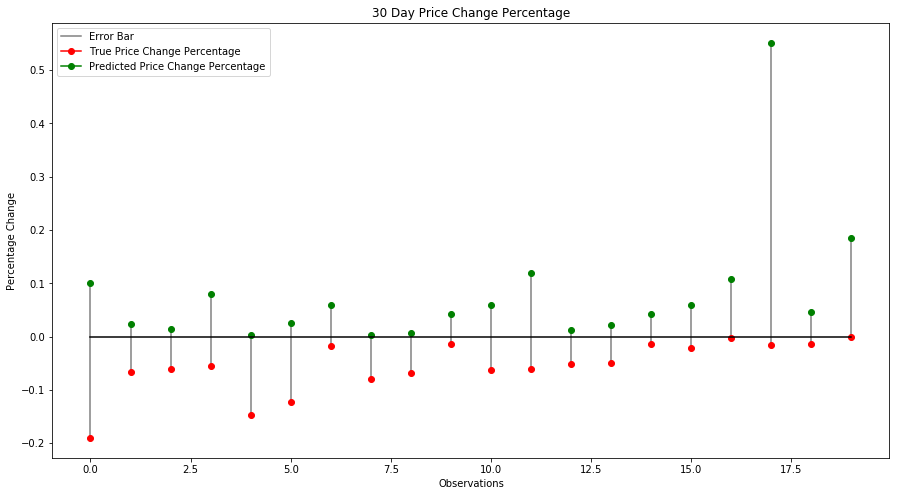

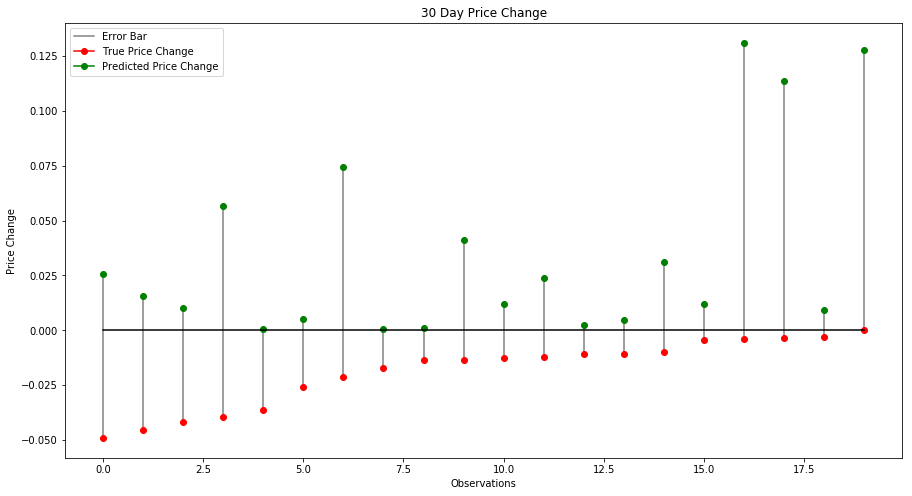

In [50]:
fig, ax = plt.subplots(figsize = (15,8))
for i in range(len(over)): 
    ax.plot([i,i], [over.change_true_percentage.values[i], over.change_pred_percentage.values[i]], color = 'gray')
    ax.plot(i, over.change_true_percentage.values[i], color = 'r', marker = 'o')
    ax.plot(i, over.change_pred_percentage.values[i], color = 'g', marker = 'o')
    
ax.plot(range(len(over)), np.zeros(len(over)), color = 'k')
ax.legend(['Error Bar','True Price Change Percentage', 'Predicted Price Change Percentage'])
ax.set_xlabel('Observations')
ax.set_ylabel('Percentage Change')
ax.set_title('30 Day Price Change Percentage')
plt.show()

 
fig, ax = plt.subplots(figsize = (15,8))
for i in range(len(over)):
    ax.plot([i,i], [over.change_true.values[i], over.change_pred.values[i]], color = 'gray')
    ax.plot(i, over.change_true.values[i], color = 'r', marker = 'o')
    ax.plot(i, over.change_pred.values[i], color = 'g', marker = 'o')
    
ax.plot(range(len(over)), np.zeros(len(over)), color = 'k')
ax.legend(['Error Bar', 'True Price Change', 'Predicted Price Change'])
ax.set_xlabel('Observations')
ax.set_ylabel('Price Change')
ax.set_title('30 Day Price Change')
plt.show()

The graphs above are interpreted as such: Each vertical bar is an individual observation. The horizontal black line represents the original price for each individual observation. The red dots are the true prices, 30 days from the original price and the green dots are the model's predicted price, 30 days from the original price. The biggest error the model made was predicting a 55% percent price increase in 30 days (top graph). The predicted price increase was 0.11 cents (bottom graph). Looking at the table, the original price was approx 0.205 cents. The model predicted 0.31 cents in 30 days and the true 30 day price was 0.202 cents, a difference of 0.003. So although the model predicted a substantial jump in price with this particular observation, at least the loss (if real money had been invested) would be almost negligible. In fact, this is the case with all 20 observations. The biggest loss an investor would have suffered is 20% at a point in which the model only predicted a modest 10% increase. It is doubtful an investor would have made a massive investment with predictions of only 10% short-term return. Next, let's look at the model's under predictions

In [51]:
print(len(under))
under

5


,true,pred,error,error_percentage,before_price,change_true,change_pred,change_true_percentage,change_pred_percentage
118,0.2331,0.228535,-0.004565,-0.019582,0.2310,0.0021,-0.002465,0.009091,-0.010669
127,0.2405,0.216791,-0.023709,-0.098583,0.2265,0.0140,-0.009709,0.061810,-0.042866
131,0.2371,0.209062,-0.028038,-0.118255,0.2150,0.0221,-0.005938,0.102791,-0.027620
154,0.2505,0.212383,-0.038117,-0.152164,0.2124,0.0381,-0.000017,0.179379,-0.000081
161,0.2583,0.211910,-0.046390,-0.179597,0.2162,0.0421,-0.004290,0.194727,-0.019843


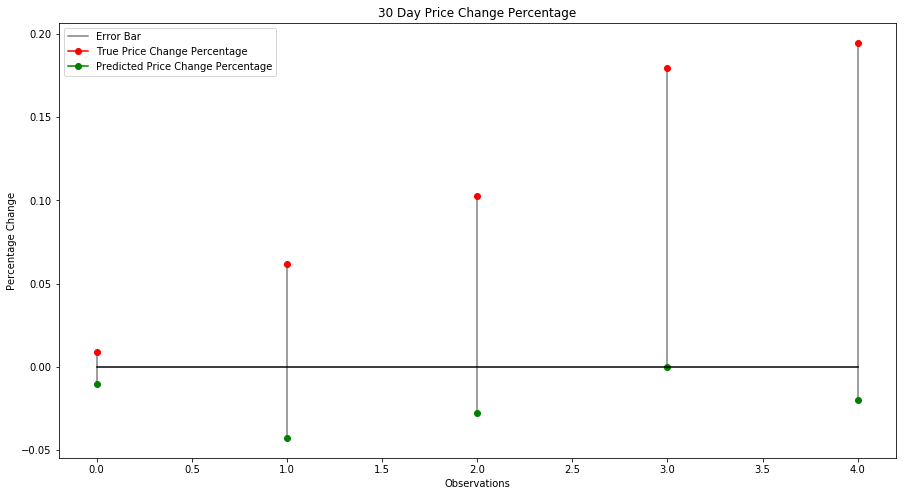

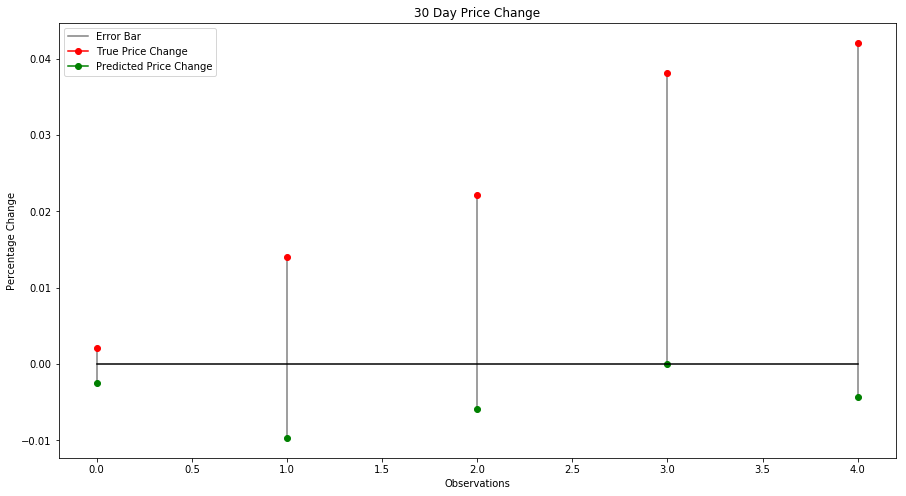

In [52]:
fig, ax = plt.subplots(figsize = (15,8))
for i in range(len(under)):
    ax.plot([i,i], [under.change_true_percentage.values[i], under.change_pred_percentage.values[i]], color = 'gray')
    ax.plot(i, under.change_true_percentage.values[i], color = 'r', marker = 'o')
    ax.plot(i, under.change_pred_percentage.values[i], color = 'g', marker = 'o')
    
ax.plot(range(len(under)), np.zeros(len(under)), color = 'k')
ax.legend(['Error Bar','True Price Change Percentage', 'Predicted Price Change Percentage'])
ax.set_xlabel('Observations')
ax.set_ylabel('Percentage Change')
ax.set_title('30 Day Price Change Percentage')
plt.show()


fig, ax = plt.subplots(figsize = (15,8))
for i in range(len(under)):
    ax.plot([i,i], [under.change_true.values[i], under.change_pred.values[i]], color = 'gray')
    ax.plot(i, under.change_true.values[i], color = 'r', marker = 'o')
    ax.plot(i, under.change_pred.values[i], color = 'g', marker = 'o')
    
ax.plot(range(len(under)), np.zeros(len(under)), color = 'k')
ax.legend(['Error Bar', 'True Price Change', 'Predicted Price Change'])
ax.set_xlabel('Observations')
ax.set_ylabel('Percentage Change')
ax.set_title('30 Day Price Change')
plt.show()

As we can see above, there are only 5 instances in which the model under predicts 30 day prices. In these instances,  the largest missed opportunity is 20% return on investment (ROI). At that point, the model predicted approx a 2% price drop over the course of 30 days.

In [53]:
trend_inaccuracy = (len(over) + len(under)) / len(df4)
over_inaccuracy = len(over) / len(df4)
under_inaccuracy = len(under) / len(df4)

In [54]:
print('Models Overall Trend Accuracy is: {:.2f}%'.format((1-trend_inaccuracy)*100))
print('Percentage of Over Predicted: {:.2f}%'.format(over_inaccuracy*100))
print('Percentage of Under Predicted: {:.2f}%'.format(under_inaccuracy*100))

Models Overall Trend Accuracy is: 90.04%
Percentage of Over Predicted: 7.97%
Percentage of Under Predicted: 1.99%


So our model is 90% accurate at predicting at least a correct 30 day future price trend. When it did predict incorrectly, approx 8% of the time it was over predicting, potentially losing an investor's money (but a negligible amount). And 2% of the time it was under predicting, costing an investor potential gains.

### Price 30 Days From Today:  June 4th, 2018

In [55]:
x,y, xscaler, yscaler = make_xy(df2, one_hots = False)
x = x[-1].reshape(32,1)
AL, _ = L_model_forward(x, parameters[0], layer_dims = [32,60,50,30,20,20,25,30,20,15,10,5,1])
price = yscaler.inverse_transform(AL)

In [56]:
print('Predicted Price for July 4th, 2018 is {:.3f}'.format(np.squeeze(price)))

Predicted Price for July 4th, 2018 is 0.656
